In [2]:
import os, csv, snappy
from pathlib import Path
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from snappy import HashMap
import gc   
from snappy import GPF
jpy = snappy.jpy
from snappy import ProductIO, File
from snappy import WKTReader
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

from rasterio.enums import Resampling
import cartopy.crs as ccrs

import rasterio
import rasterio.mask
from rasterio.enums import Resampling
import fiona

In [3]:
##init variables
File = jpy.get_type('java.io.File') #file type   

pc_base_directory = ('C:/Sentinel 3 Data/') 
laptop_base_directory = ('C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/MassThesis/src/TIF/AllBandsTiff')

base_directory = laptop_base_directory
k=0
path = Path(base_directory)
print(path)


C:\Users\Massimo\Documents\SchoolFolder\ThirdYear\Thesis\MassThesis\src\TIF\AllBandsTiff


In [4]:
##Malta polygon
shpMalta = gpd.read_file(r'Malta Shape File/MaltaShapeFile.shp') 
geomMalta =str(shpMalta['geometry'][0])# get the geometry of polygon shapefile as string. 
geomMalta = WKTReader().read(geomMalta) #create WKT file from the Shapefile.

##Maltese island only polygon
shpMaltaOnly = gpd.read_file(r'Malta Shape File/MaltaOnly.shp') 
geomMaltaOnly =str(shpMaltaOnly['geometry'][0])# get the geometry of polygon shapefile as string. 
geomMaltaOnly = WKTReader().read(geomMaltaOnly) #create WKT file from the Shapefile.

##Gozo & Comino polygon
shpGozo = gpd.read_file(r'Malta Shape File/Gozo&Comino.shp') 
geomGozo =str(shpGozo['geometry'][0])# get the geometry of polygon shapefile as string. 
geomGozo = WKTReader().read(geomGozo) #create WKT file from the Shapefile.

##West polygon
shpWest = gpd.read_file(r'Malta Shape File/WestMalta.shp') 
geomWest =str(shpWest['geometry'][0])# get the geometry of polygon shapefile as string. 
geomWest = WKTReader().read(geomWest) #create WKT file from the Shapefile.

##North polygon
'''
shpNorth = gpd.read_file(r'Malta Shape File/NorthMalta.shp') 
geomNorth = str(shpNorth['geometry'][0])# get the geometry of polygon shapefile as string. 
geomNorth = WKTReader().read(geomNorth) #create WKT file from the Shapefile.
'''

##East polygon
shpEast = gpd.read_file(r'Malta Shape File/EastMalta.shp') 
geomEast = str(shpEast['geometry'][0])# get the geometry of polygon shapefile as string. 
geomEast = WKTReader().read(geomEast) #create WKT file from the Shapefile.

In [5]:
#CSV
def write_to_csv( sat, date_format, sensor, time_format, full_name, lst_mean, lst_max, ndvi, lst_mean_east, lst_max_east, lst_mean_west, lst_max_west, ndvi_east, ndvi_west, suhi_max, suhi_mean):
    #print(sat, date_format, sensor, time_format)
    with open('./CSV/ProcessedDataCSV.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["FileName", "Satellite", "Sensor", "Date", "Time", "LST_MEAN", "LST_MAX", "LST_MEAN_EAST", "LST_MAX_EAST", "LST_MEAN_WEST", "LST_MAX_WEST", "NDVI_MEAN", "NDVI_EAST", "NDVI_WEST","SUHI_MAX", "SUHI_MEAN"])

        for i in range(len(sat)):
            writer.writerow([full_name[i], sat[i], sensor[i], date_format[i], time_format[i], lst_mean[i], lst_max[i], lst_mean_east[i], lst_max_east[i], lst_mean_west[i], lst_max_west[i], ndvi[i], ndvi_east[i], ndvi_west[i],suhi_max[i], suhi_mean[i]]) 

##########################################


In [6]:
def Subset(product, geom):
    par = HashMap()
    par.put('copyMetadata', True)
    par.put('geoRegion', geom)
    product = GPF.createProduct('Subset', par, product) #Spatial subset.
    return product

In [7]:
#Plot Image
def plotLstNdvi(lst_band_data, ndvi_band_data, date, time, area):
    ##Heatmap colours
    color = cm.jet
    color.set_bad('white')

    colormap = plt.cm.RdYlGn
    '''
    #plt
    plt.figure(figsize=(20,10))

    #LST    
    plt.subplot(121)     
    plt.imshow(lst_band_data, cmap= color), plt.title(area + ' LST ' + date + ' ' + time)
    plt.colorbar(mappable=color) 
    plt.axis('off')

    #NDVI
    plt.subplot(122)
    #plt.imshow(ndvi_band_data, cmap ='gray'), plt.title('NDVI')
    plt.imshow(ndvi_band_data, cmap = colormap), plt.title(area + ' NDVI ' + date + ' ' + time)
    plt.axis('off')

    plt.show()
    '''
    ##LST
    min = np.nanmin(lst_band_data)
    max = np.nanmax(lst_band_data)

    
    try:
        fig1 = plt.figure(figsize=(20,10))
        fig1.clf()
        ax = fig1.add_subplot(1,1,1)
        ax.set_title(area + ' LST ' + date + ' ' + time + '\n (C°)', fontsize=17, fontweight='bold')
        img = ax.imshow(lst_band_data - 273, cmap=color, interpolation='nearest', vmin=min-273, vmax=max-273)
        
        fig1.colorbar(img)
        plt.savefig('./PNG/LST/' + area + 'LST' + date.replace('/', '') + '.png')
        plt.show()
    except ValueError: 
        print('LST '+ date + 'Error') 
        pass
    
    
    ##NDVI
    min = np.nanmin(ndvi_band_data)
    max = np.nanmax(ndvi_band_data)

    try:
        fig2 = plt.figure(figsize=(20,10))
        fig2.clf()
        ax = fig2.add_subplot(1,1,1) 
        ax.set_title(area + ' NDVI ' + date + ' ' + time, fontsize=17, fontweight='bold')
        img = ax.imshow(ndvi_band_data, cmap=colormap, interpolation='nearest', vmin=min, vmax=max)
        fig2.colorbar(img)
        plt.savefig('./PNG/NDVI/' + area + 'NDVI' + date.replace('/', '') + '.png')
        plt.show()
    except ValueError:
        print('NDVI '+ date + 'Error')
        pass
    

##########################################


In [8]:
def histogram(no_nan_lst_band_data, no_nan_ndvi_band_data):
    #NDVI
    fig1 = plt.figure(figsize=(20,10))
    # Give this new figure a subplot, which will contain the histogram itself
    ax = fig1.add_subplot(111)
    # Add a title & (x,y) labels to the plot
    plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
    plt.xlabel("NDVI values", fontsize=14)
    plt.ylabel("Number of pixels", fontsize=14)
    # For the x-axis, we want to count every pixel that is not an empty value
    x = no_nan_ndvi_band_data
    color = 'g'
    # call 'hist` with our x-axis, bins, and color details
    ax.hist(x,bins=30,color=color,histtype='bar', ec='black')
    # Save the generated figure to an external image file
    #fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)
    plt.show()

    #LST
    # Define a new figure
    fig2 = plt.figure(figsize=(20,10))
    # Give this new figure a subplot, which will contain the histogram itself
    ax = fig2.add_subplot(111)
    # Add a title & (x,y) labels to the plot
    plt.title("LST Histogram", fontsize=18, fontweight='bold')
    plt.xlabel("LST values", fontsize=14)
    plt.ylabel("Number of pixels", fontsize=14)
    # For the x-axis, we want to count every pixel that is not an empty value
    x = no_nan_lst_band_data
    color = 'b'
    # call 'hist` with our x-axis, bins, and color details
    ax.hist(x,bins=30,color=color,histtype='bar', ec='black')
    # Save the generated figure to an external image file
    #fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)
    plt.show()

In [33]:
##Details about Products
full_name = []
product_name = []
product_paths = []
sat = []
sensor = []
date_format = []
time_format = []

##LST
#Malta
lst_mean = []
lst_max = []
#West
lst_mean_west = []
lst_max_west = []
#East
lst_mean_east = []
lst_max_east = []
#Gozo&Comino
lst_mean_gozo = []
lst_max_gozo = []

##NDVI
ndvi = []
ndvi_east = []
ndvi_west = []
ndvi_gozo = []

##Data
suhi_max = []
suhi_mean = []

lst_urb_max = [] #hottest pixel
lst_urb_mean = [] #average temp of study area
lst_sur = [] #average temp of surrounding study area
##########################################

Directory open:
['C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/MassThesis/src/TIF/AllBandsTiff']
LST mean:
293.0140380859375 Kelvin
20.0140380859375 Celcius
Max LST Pixel value: 
22.33599853515625 Kelvin
22.33599853515625 Celcius

LST mean West:
565.8801879882812 Kelvin
292.8802 Celcius

Max LST Pixel value West: 
294.20001220703125 Kelvin
21.20001220703125 Celcius

LST mean East:
293.0179443359375 Kelvin
20.0179443359375 Celcius

Max LST Pixel value East: 
295.33599853515625 Kelvin
22.33599853515625 Celcius

NDVI mean Malta:
0.43252257

NDVI mean West:
0.467879

NDVI mean East:
0.41041943

SUHI MAX:
-251.13188046216965

SUHI MEAN:
-0.057459563


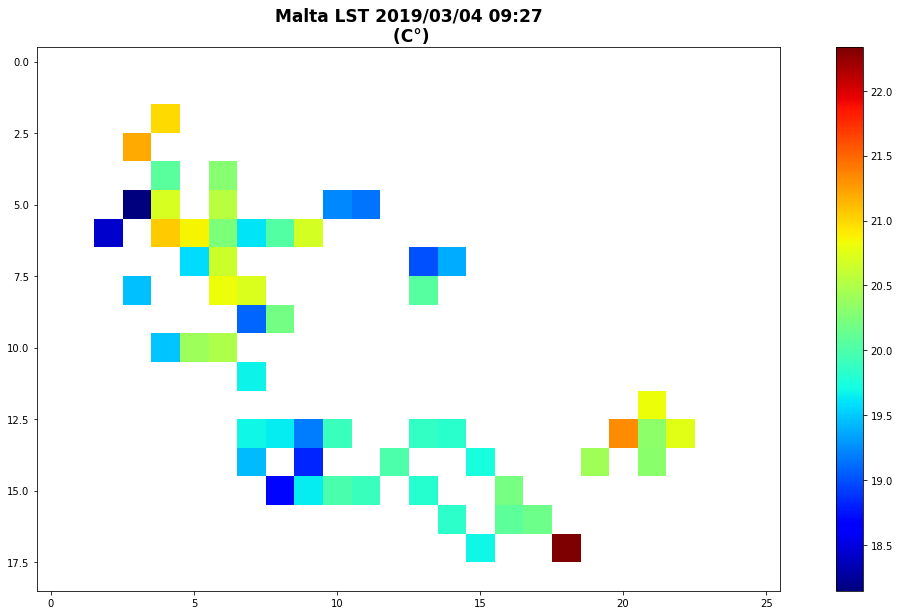

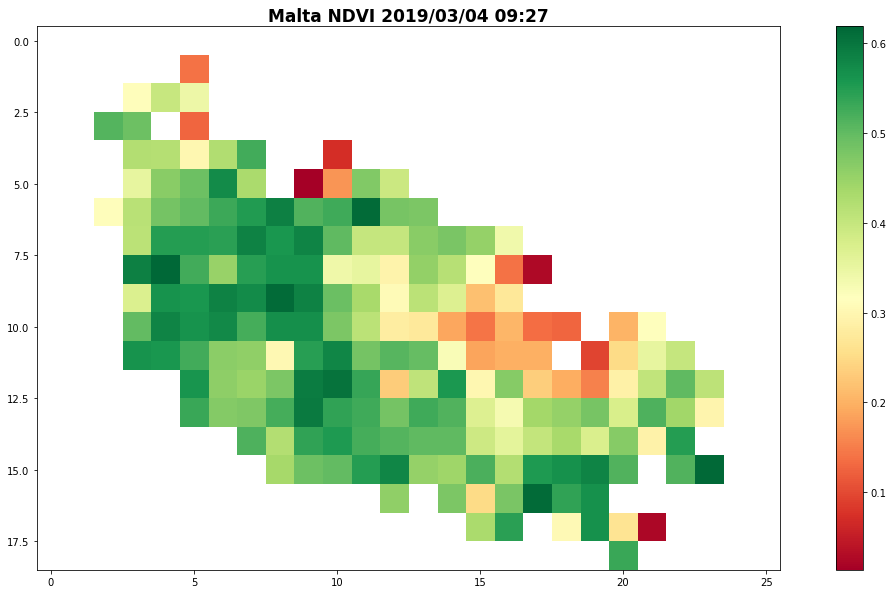

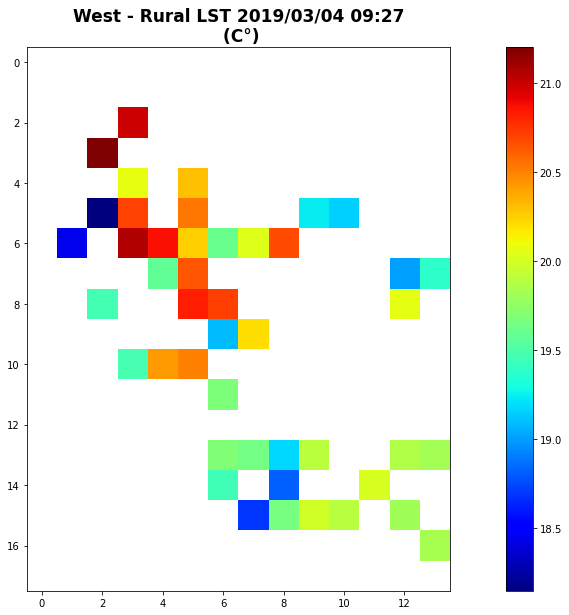

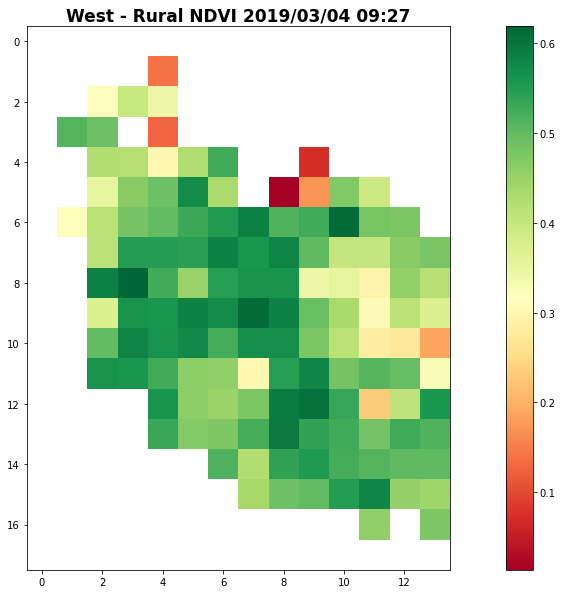

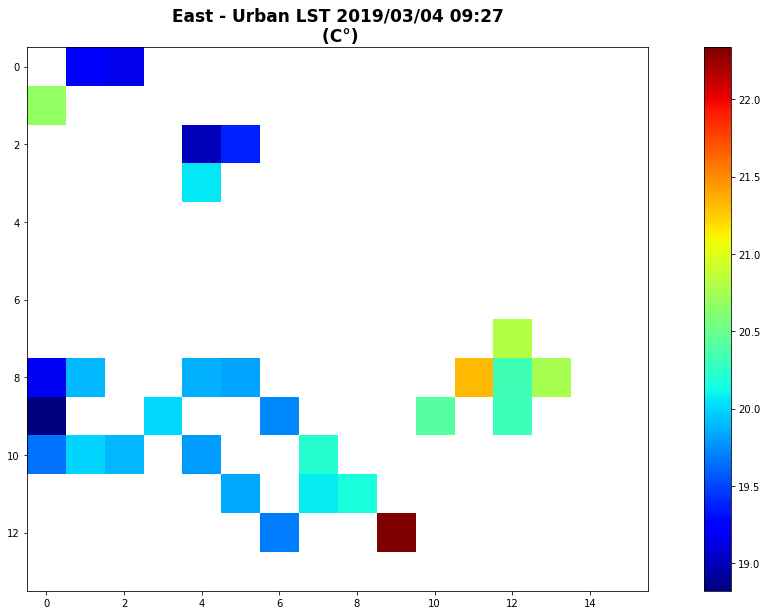

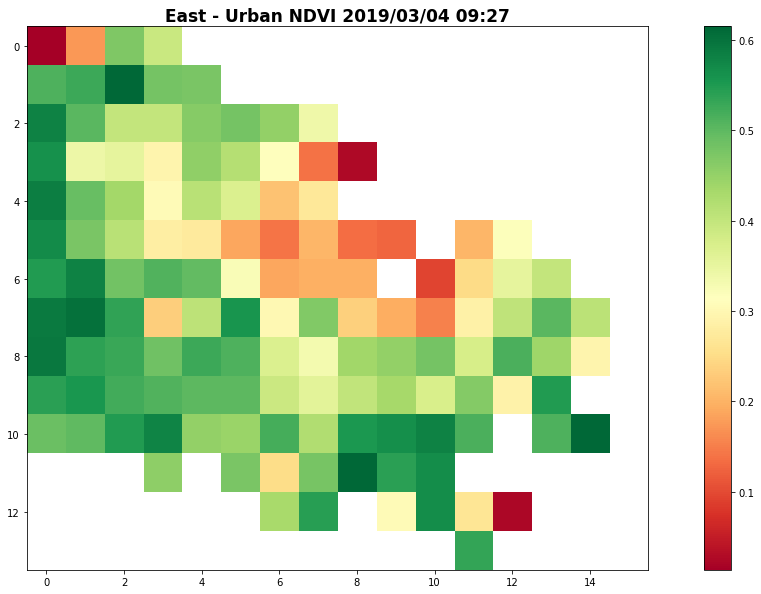

c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: All-NaN slice encountered
c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: All-NaN slice encountered


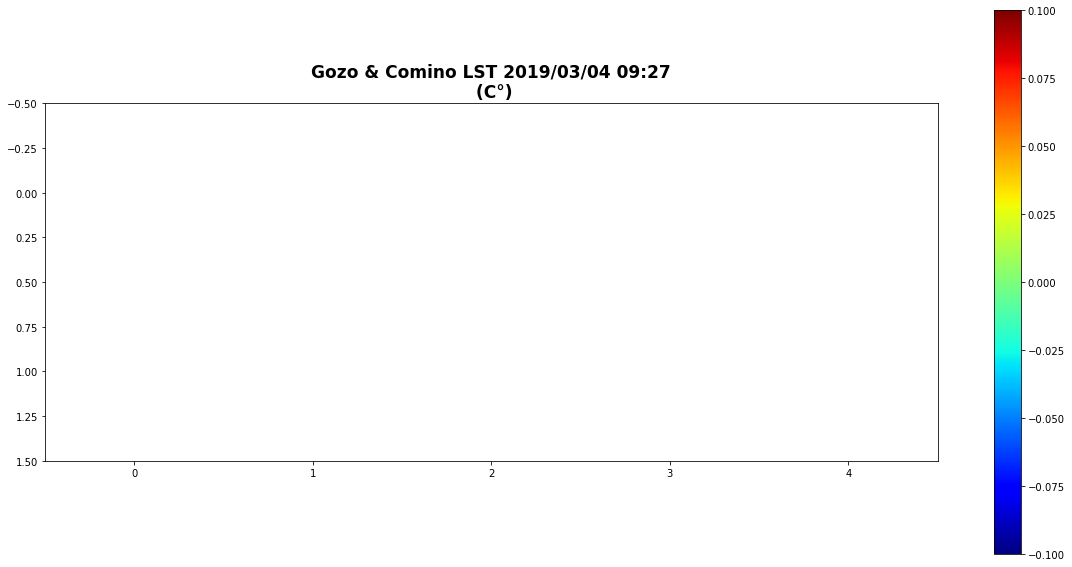

c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: All-NaN slice encountered
c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: All-NaN slice encountered


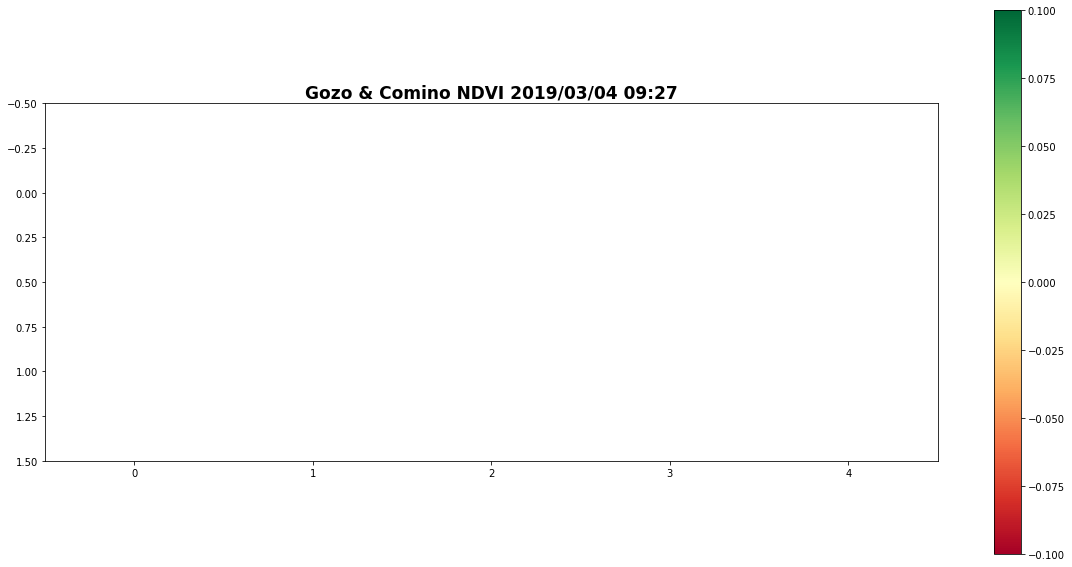

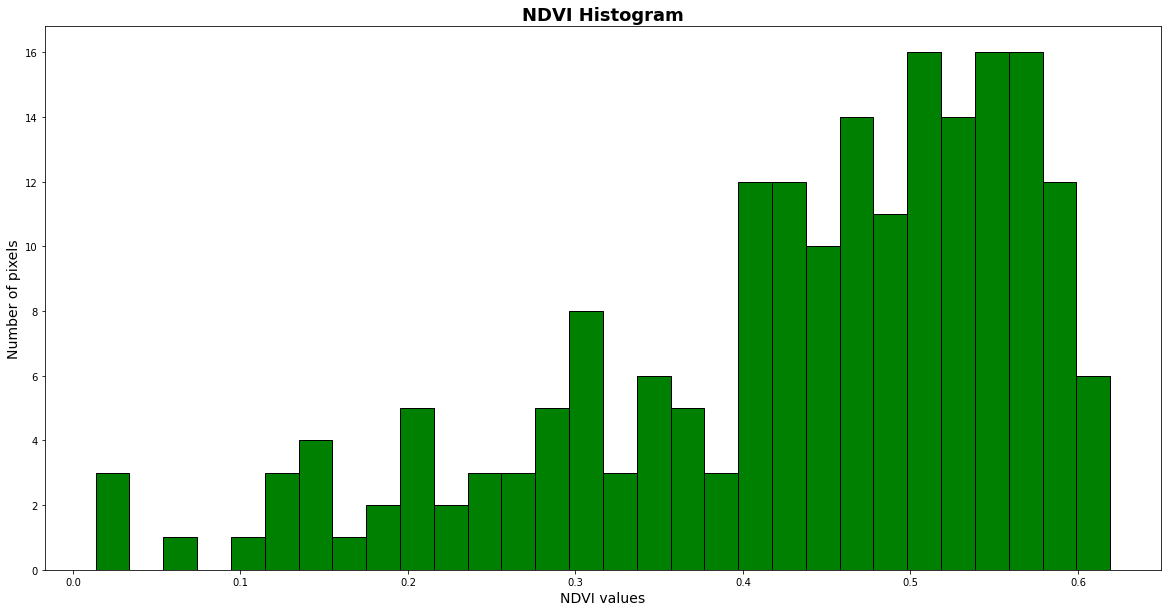

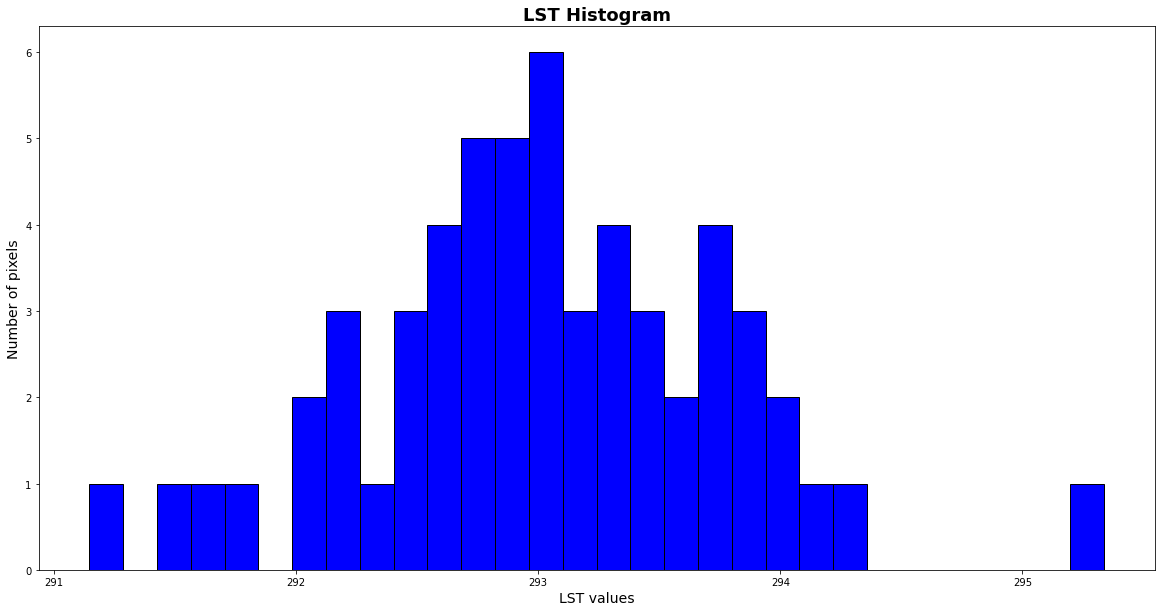

###################


LST mean:
295.34832763671875 Kelvin
22.34832763671875 Celcius
Max LST Pixel value: 
25.9320068359375 Kelvin
25.9320068359375 Celcius

LST mean West:
567.890625 Kelvin
294.89062 Celcius

Max LST Pixel value West: 
298.9320068359375 Kelvin
25.9320068359375 Celcius

LST mean East:
295.9575500488281 Kelvin
22.957550048828125 Celcius

Max LST Pixel value East: 
298.9320068359375 Kelvin
25.9320068359375 Celcius

NDVI mean Malta:
0.37107667

NDVI mean West:
0.40088332

NDVI mean East:
0.3594616

SUHI MAX:
-247.4688764810562

SUHI MEAN:
-0.04142171


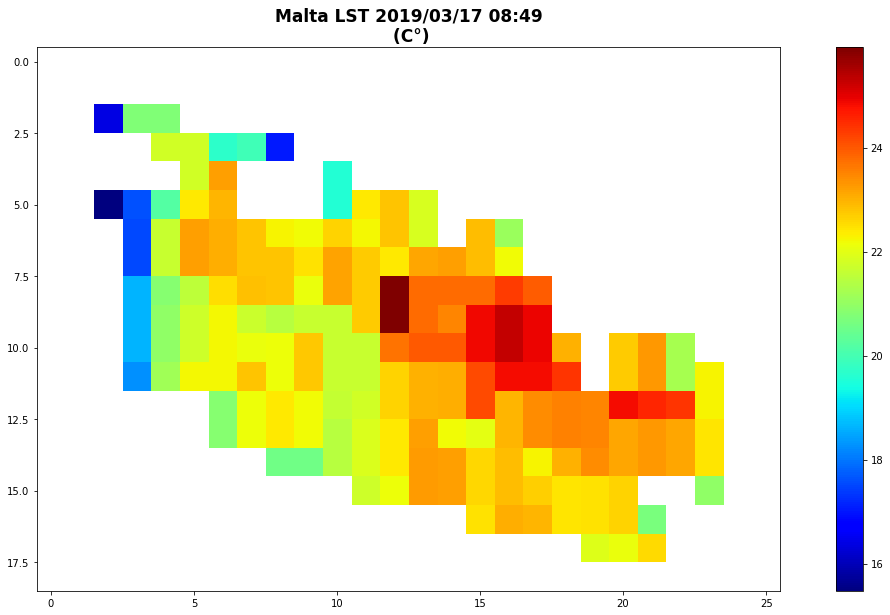

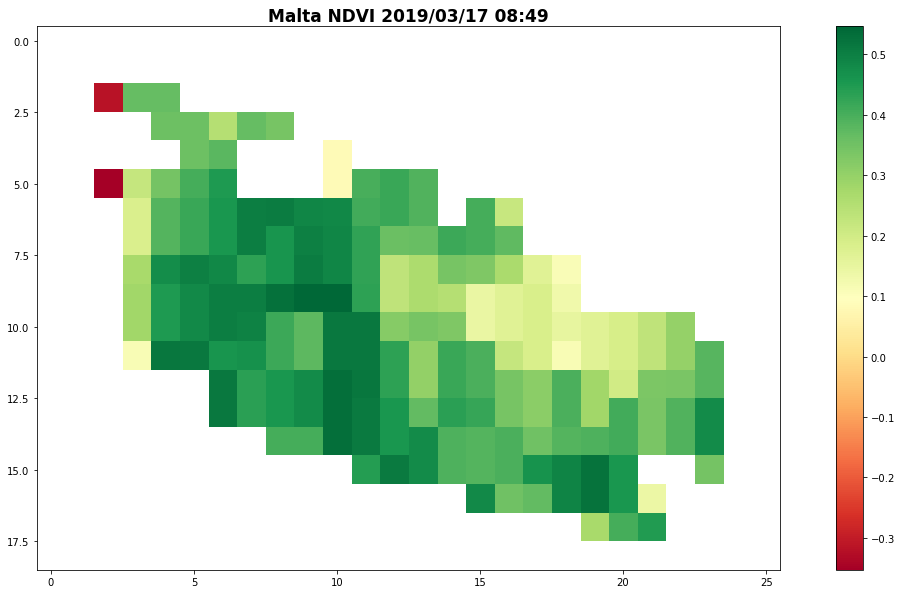

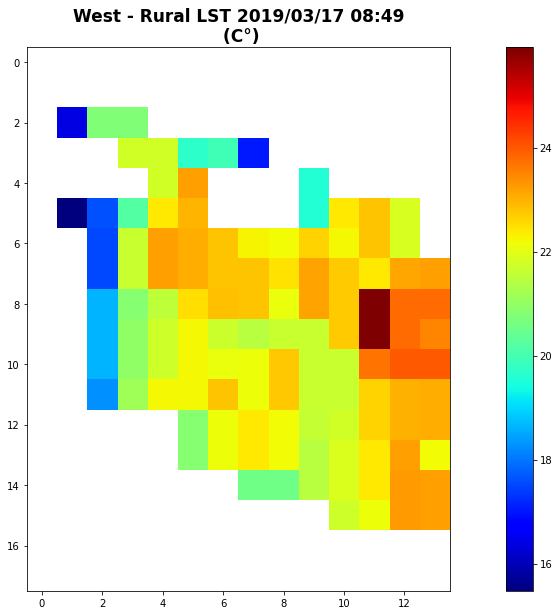

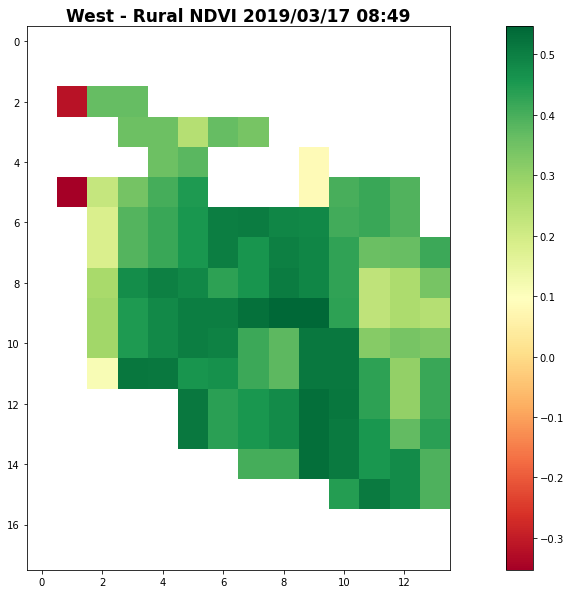

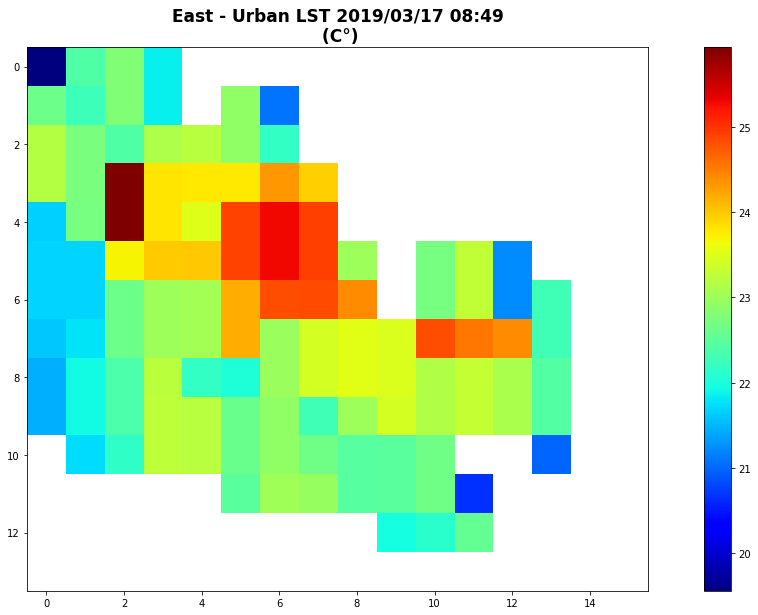

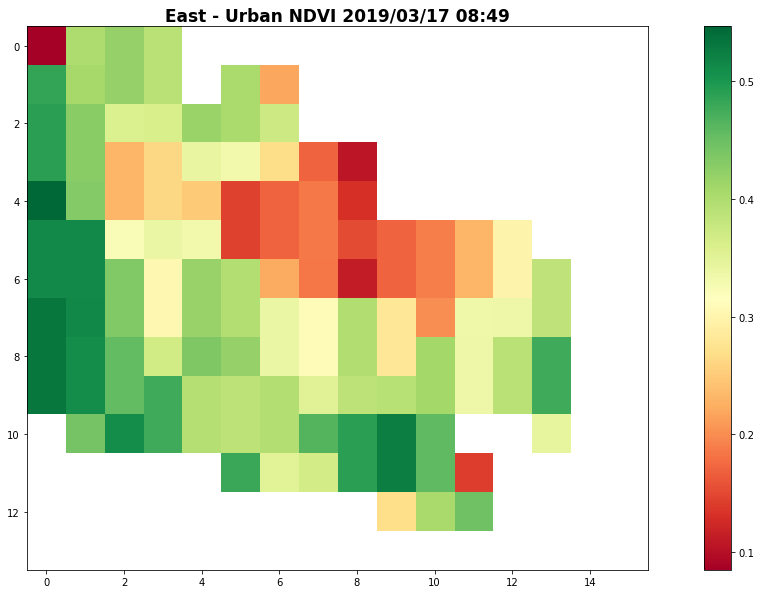

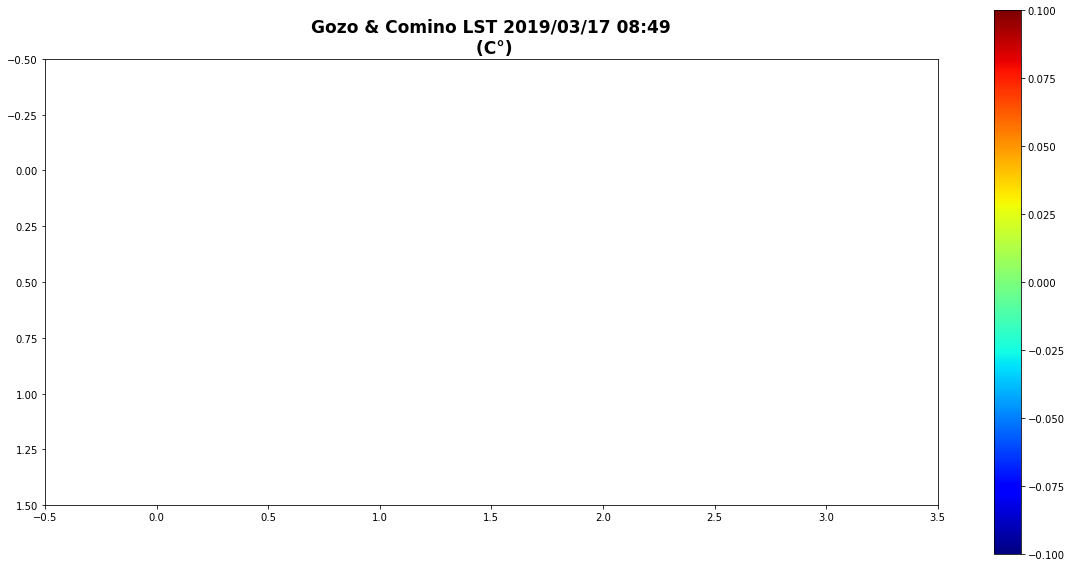

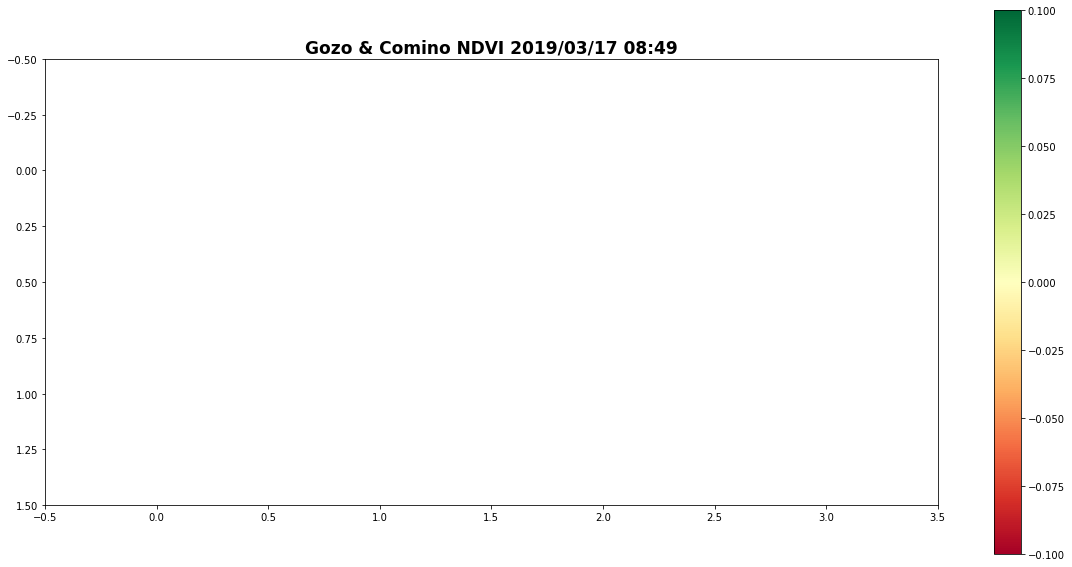

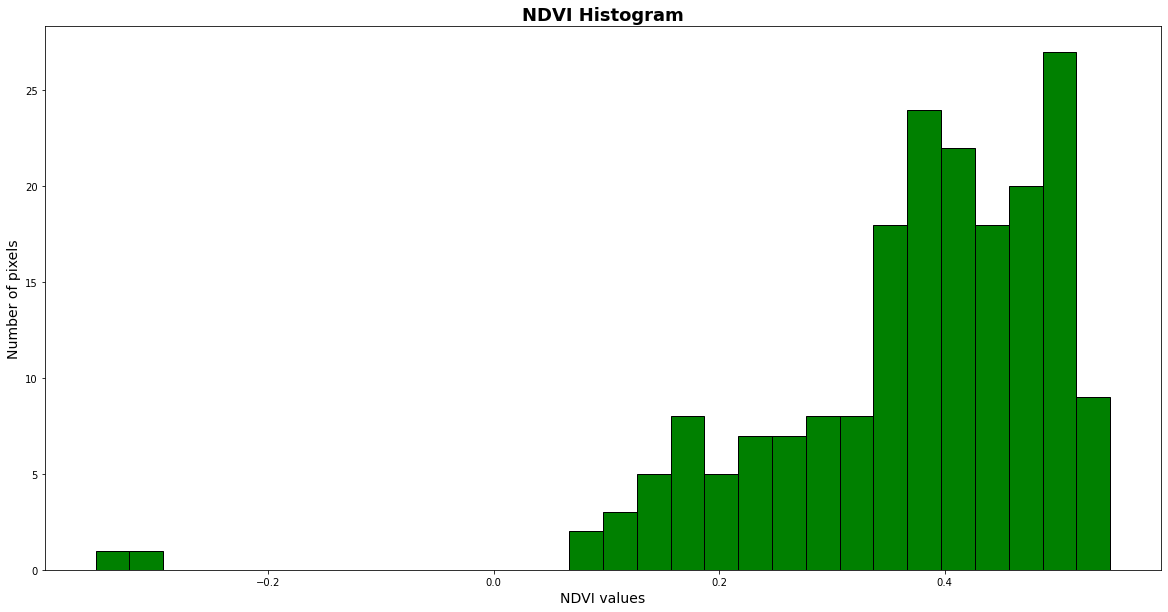

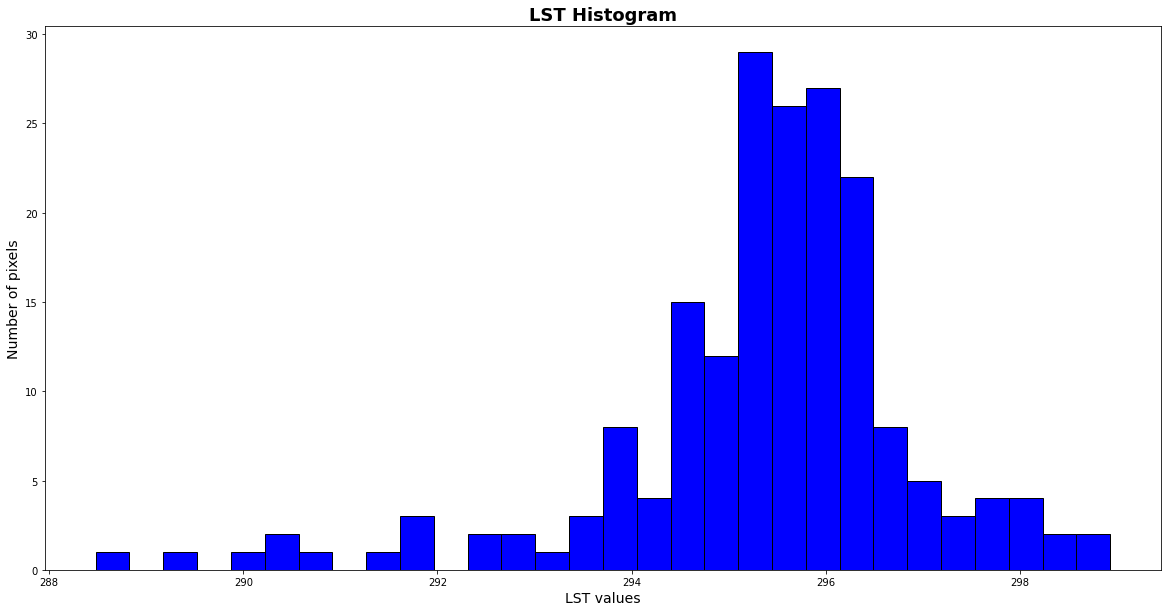

###################


LST mean:
315.1742858886719 Kelvin
42.174285888671875 Celcius
Max LST Pixel value: 
47.6820068359375 Kelvin
47.6820068359375 Celcius

LST mean West:
587.9098815917969 Kelvin
314.90988 Celcius

Max LST Pixel value West: 
320.6820068359375 Kelvin
47.6820068359375 Celcius

LST mean East:
316.1131286621094 Kelvin
43.113128662109375 Celcius

Max LST Pixel value East: 
320.6820068359375 Kelvin
47.6820068359375 Celcius

NDVI mean Malta:
0.22475173

NDVI mean West:
0.24673498

NDVI mean East:
0.20611477

SUHI MAX:
-225.564728140831

SUHI MEAN:
-0.040620208


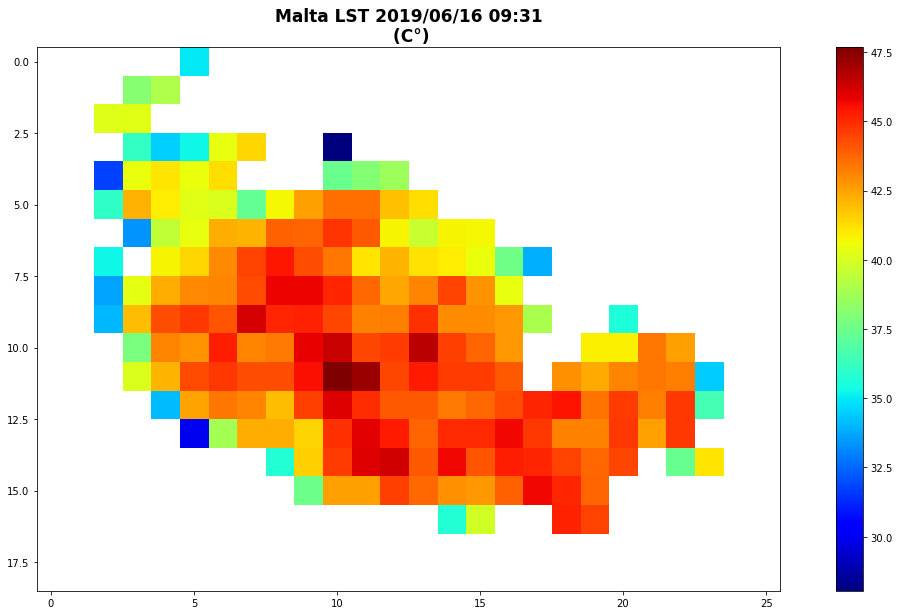

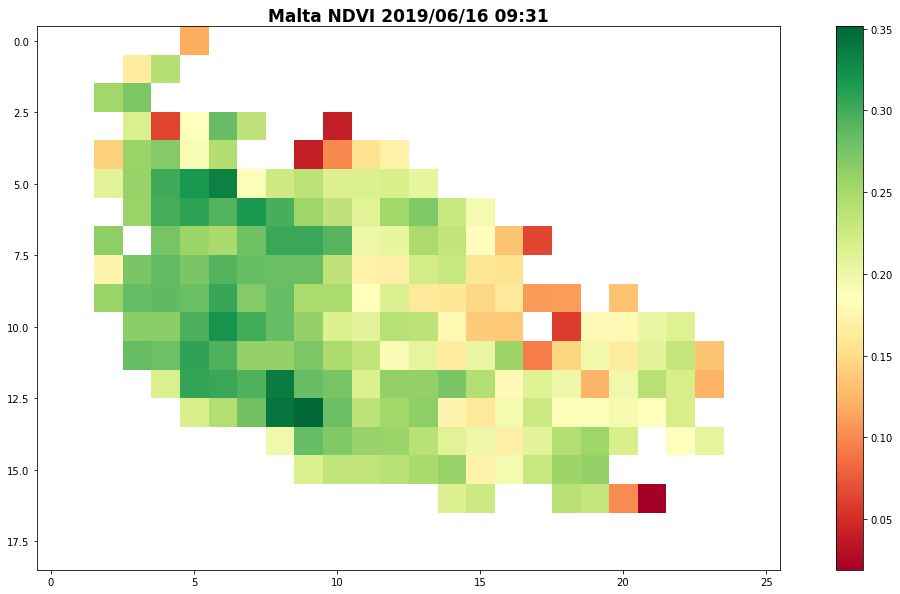

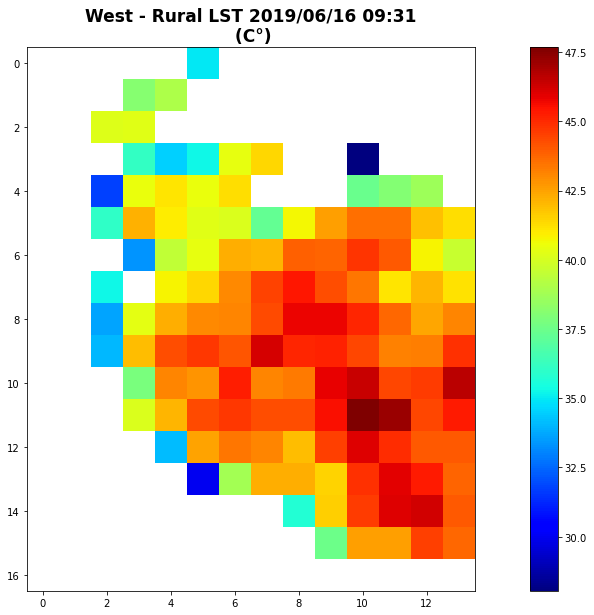

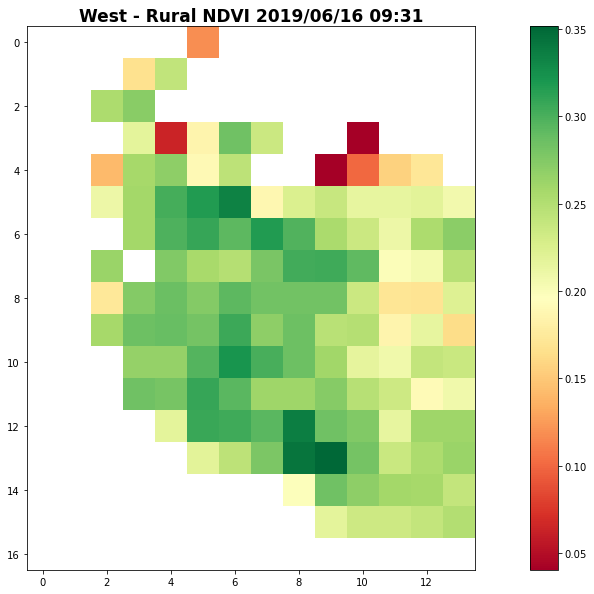

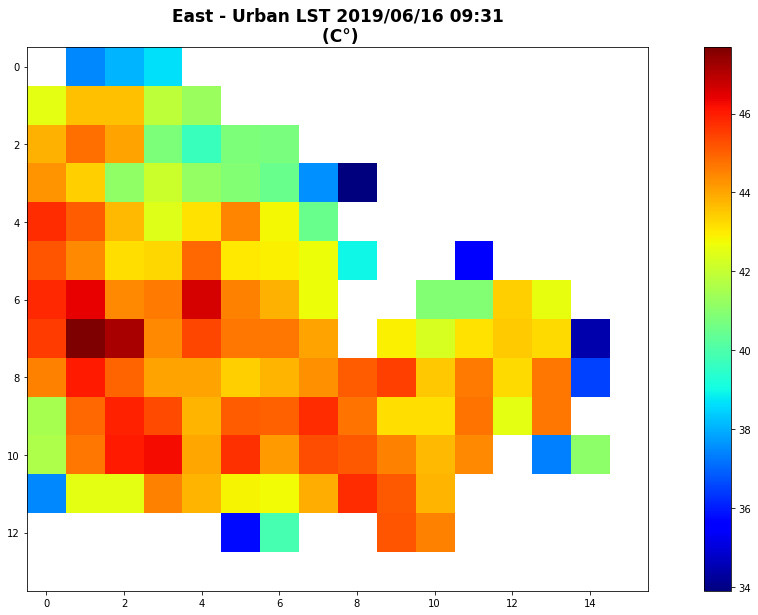

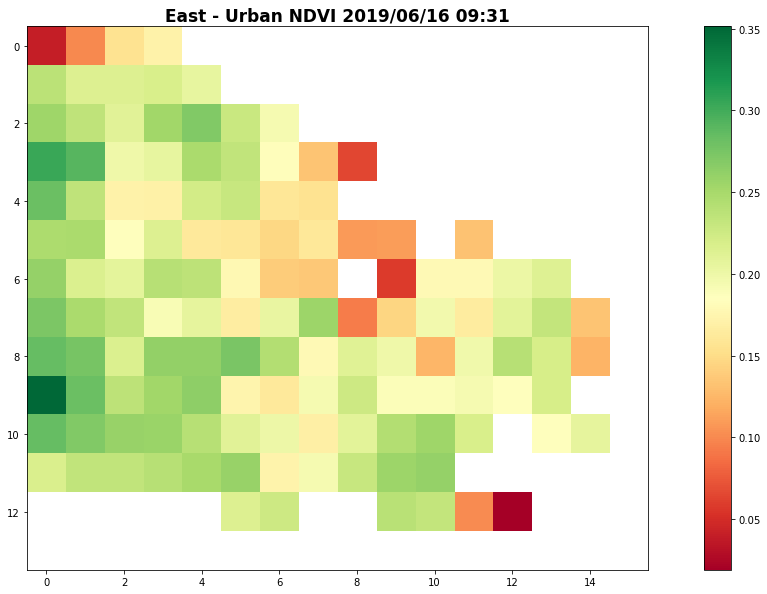

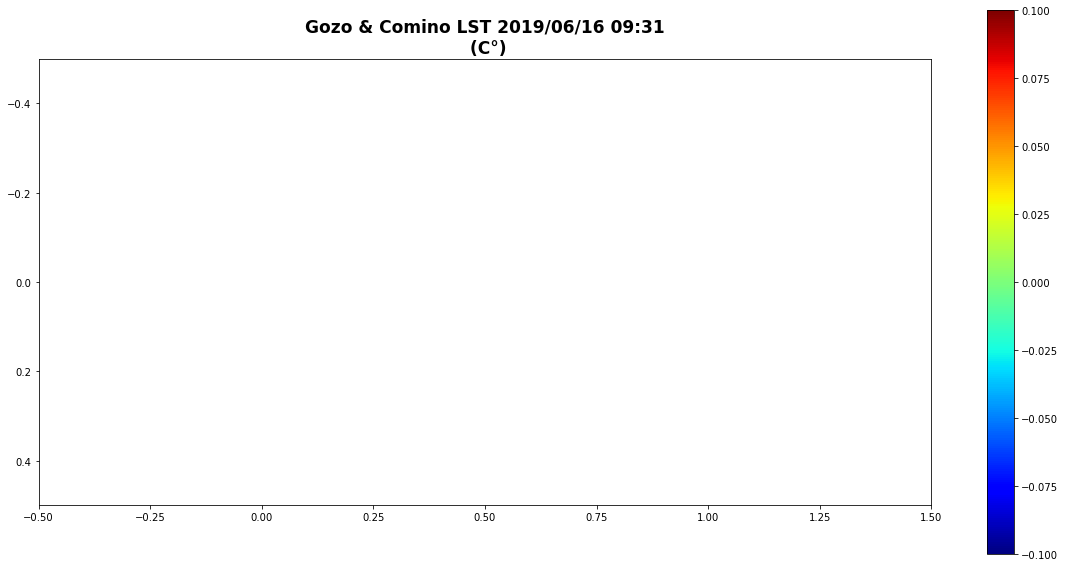

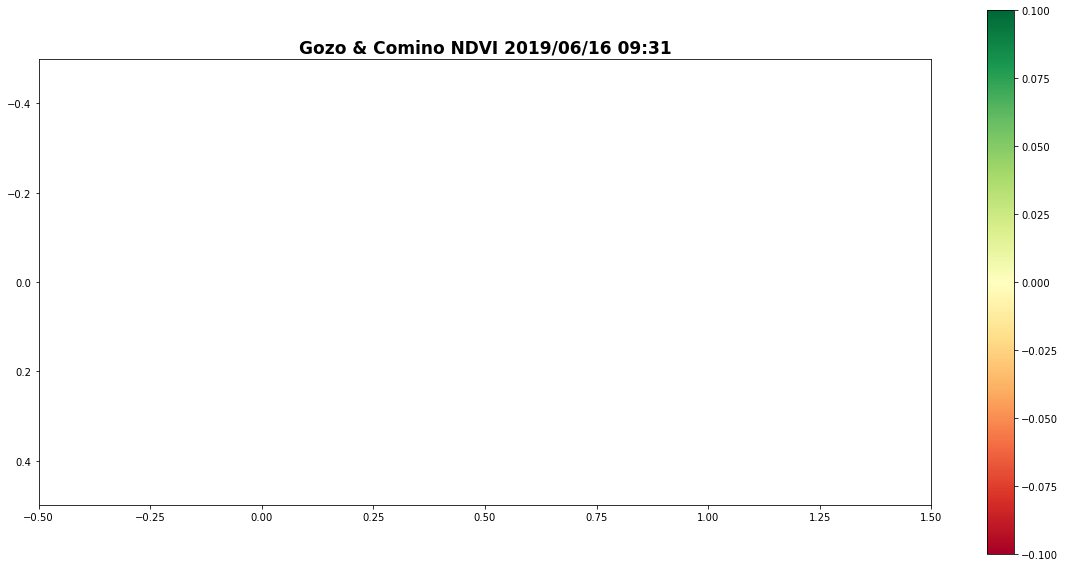

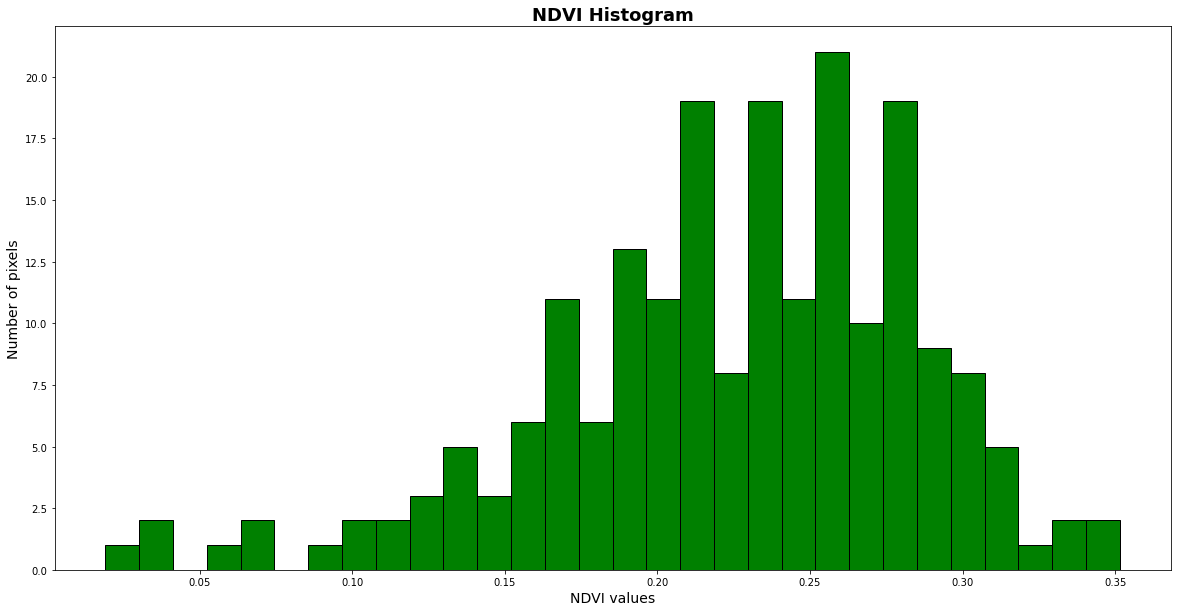

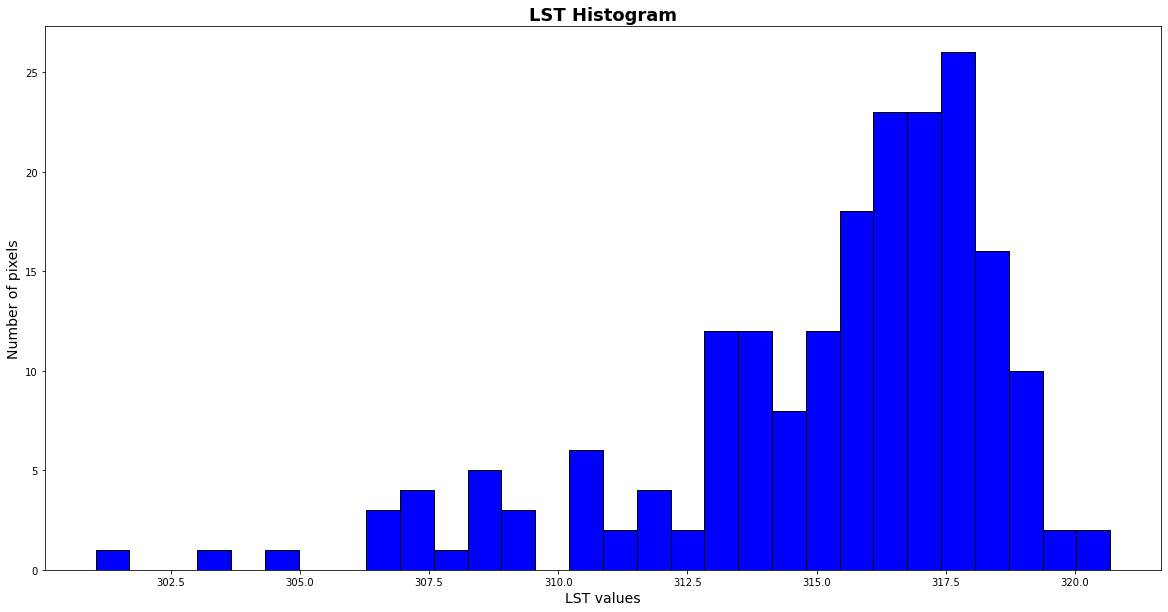

###################


LST mean:
315.11944580078125 Kelvin
42.11944580078125 Celcius
Max LST Pixel value: 
47.178009033203125 Kelvin
47.178009033203125 Celcius

LST mean West:
587.2365112304688 Kelvin
314.2365 Celcius

Max LST Pixel value West: 
318.85198974609375 Kelvin
45.85198974609375 Celcius

LST mean East:
316.0919189453125 Kelvin
43.0919189453125 Celcius

Max LST Pixel value East: 
320.1780090332031 Kelvin
47.178009033203125 Celcius

NDVI mean Malta:
0.22753341

NDVI mean West:
0.25066003

NDVI mean East:
0.20706667

SUHI MAX:
-226.0726509988308

SUHI MEAN:
-0.043593362


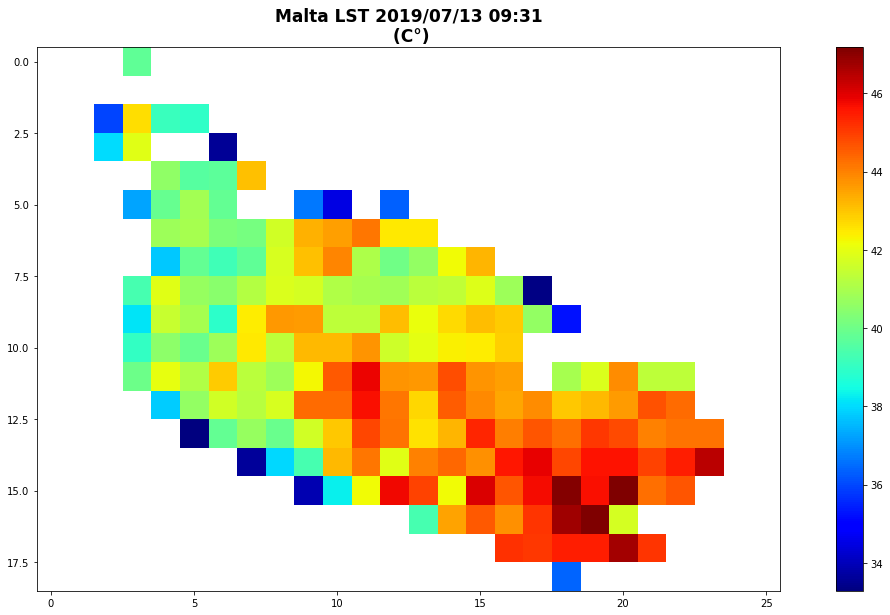

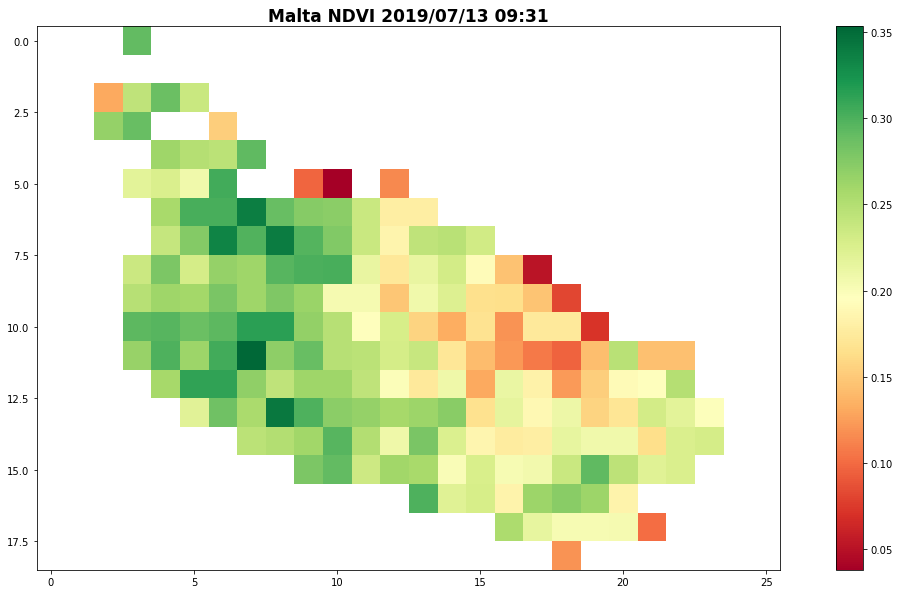

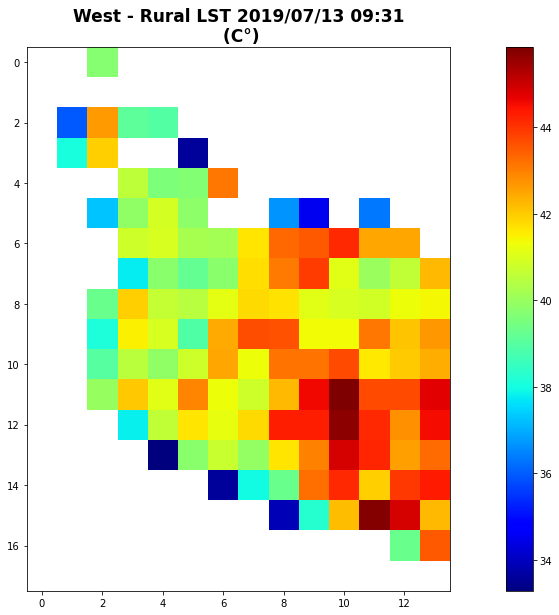

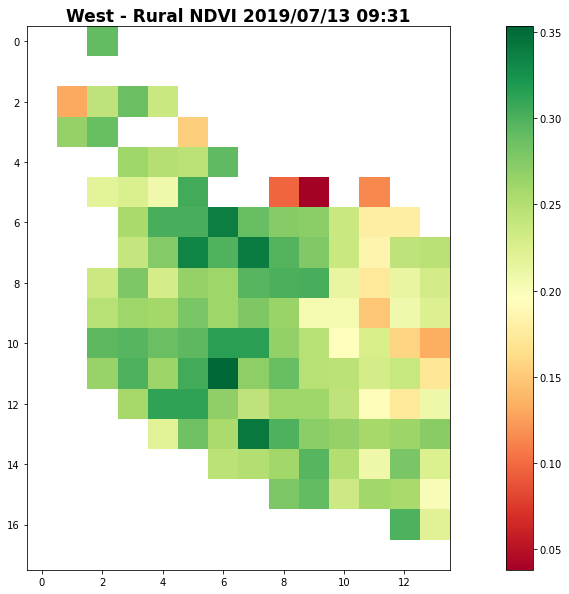

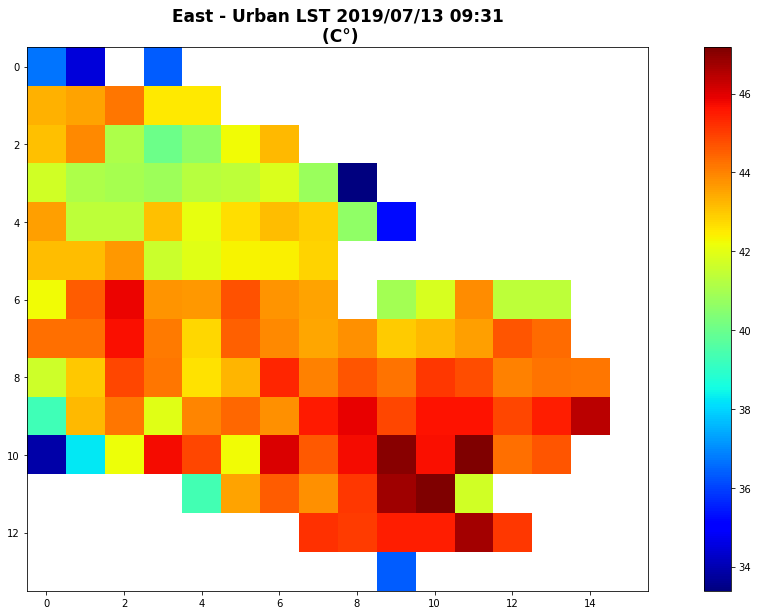

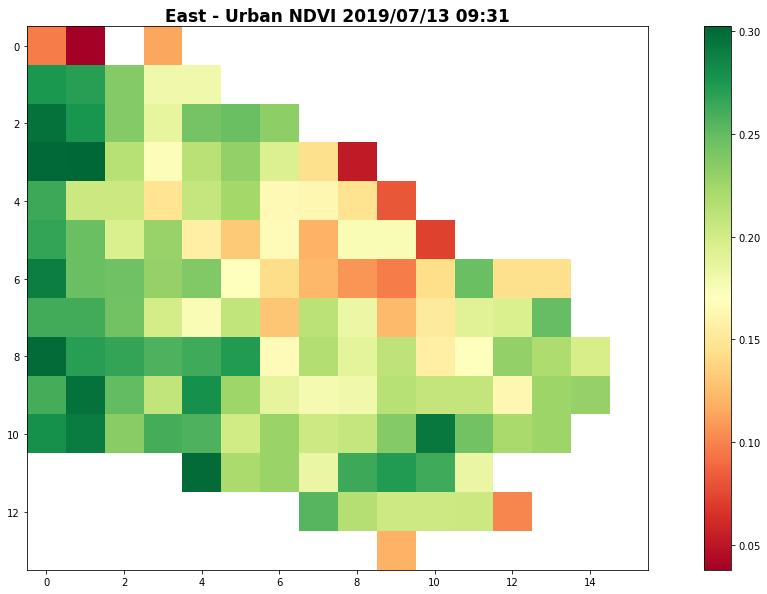

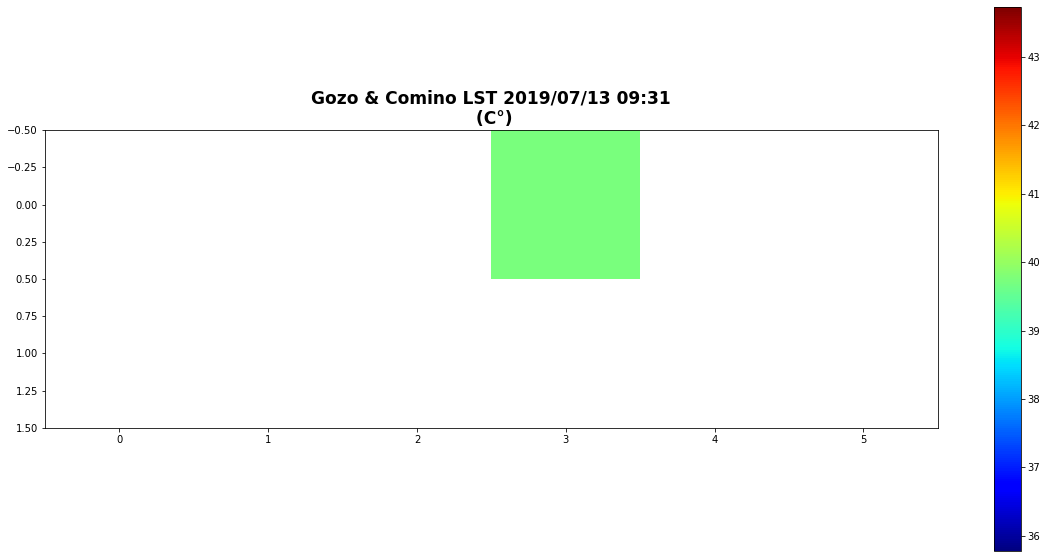

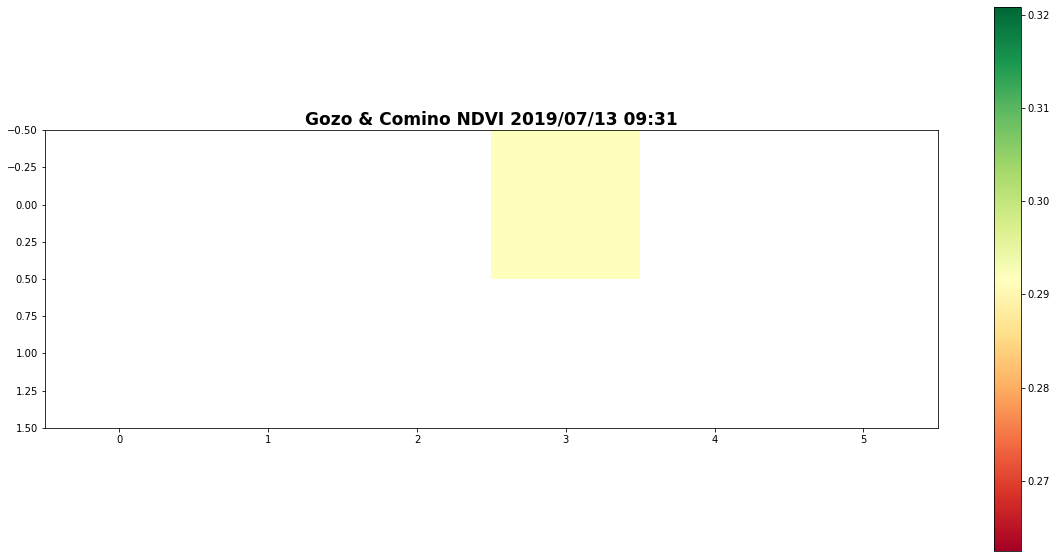

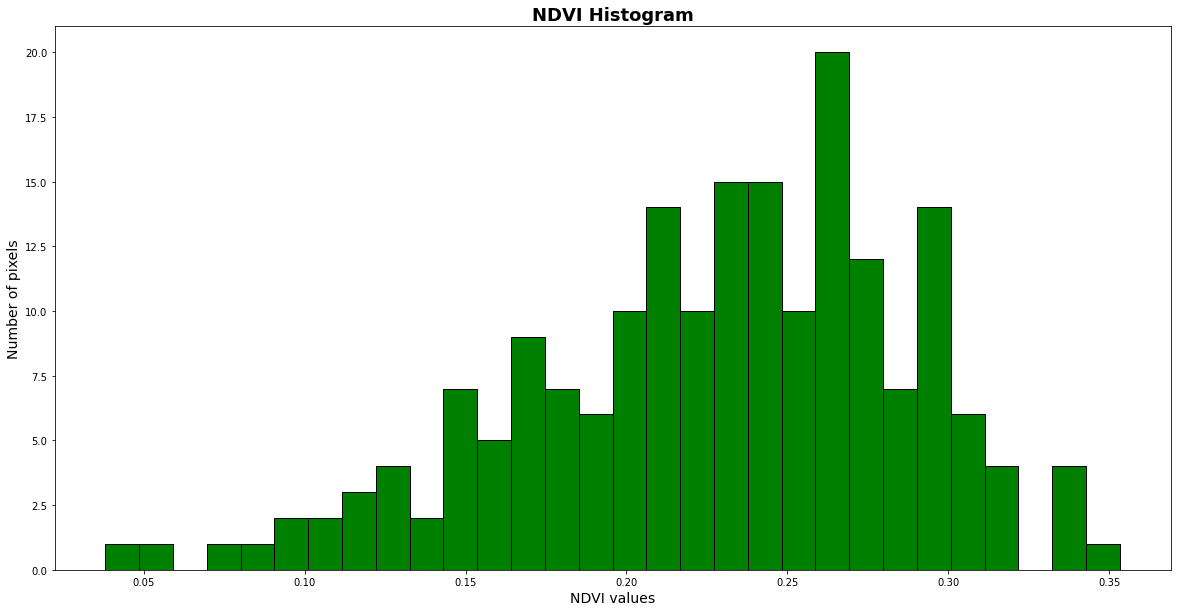

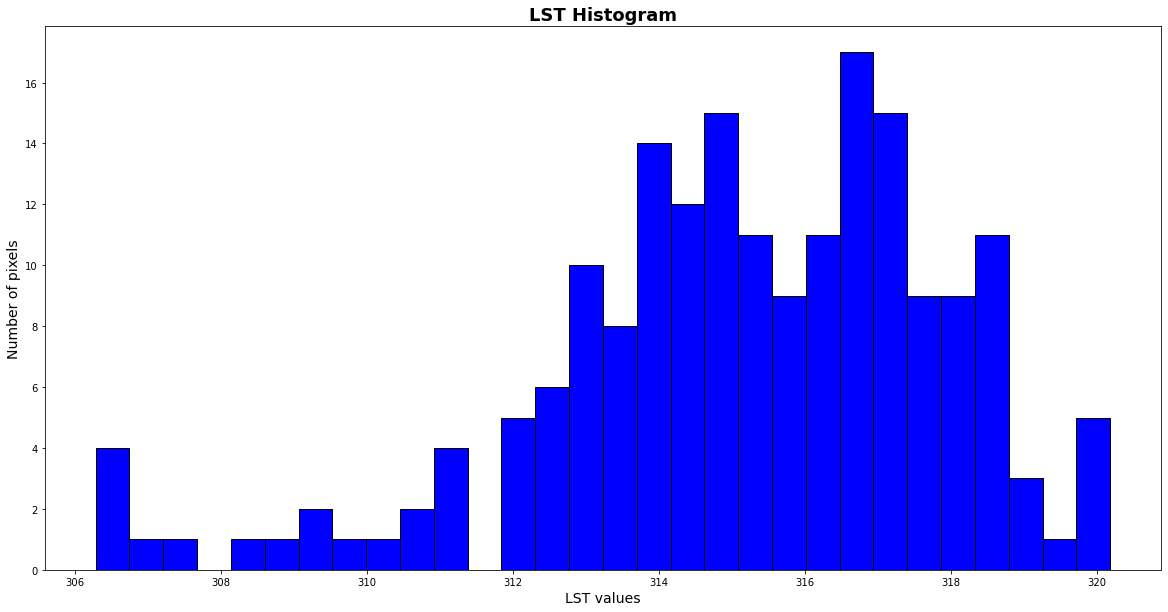

###################


LST mean:
290.5429382324219 Kelvin
17.542938232421875 Celcius
Max LST Pixel value: 
23.0 Kelvin
23.0 Celcius

LST mean West:
563.8201904296875 Kelvin
290.8202 Celcius

Max LST Pixel value West: 
296.0 Kelvin
23.0 Celcius

LST mean East:
290.93438720703125 Kelvin
17.93438720703125 Celcius

Max LST Pixel value East: 
296.0 Kelvin
23.0 Celcius

NDVI mean Malta:
0.13309097

NDVI mean West:
0.15745607

NDVI mean East:
0.12417507

SUHI MAX:
-250.1574560701847

SUHI MEAN:
-0.033281


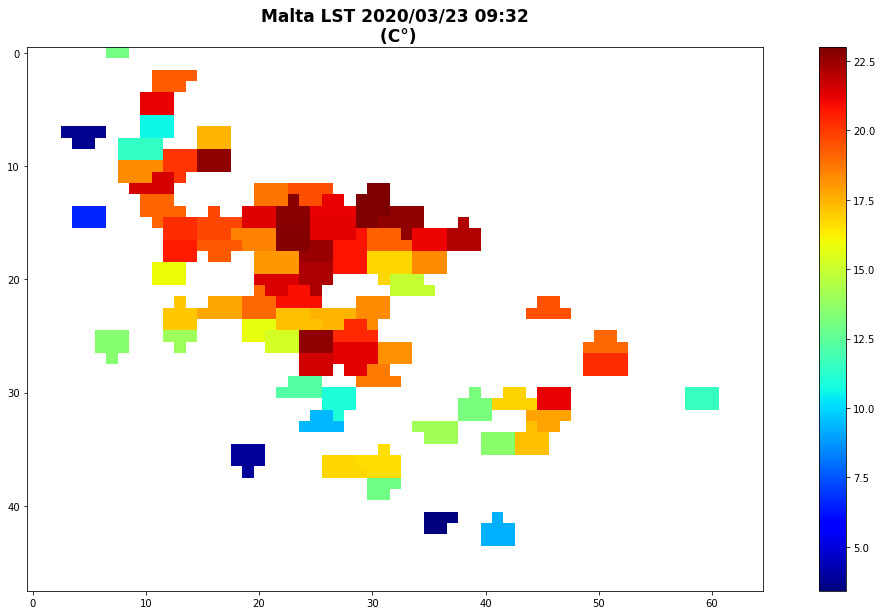

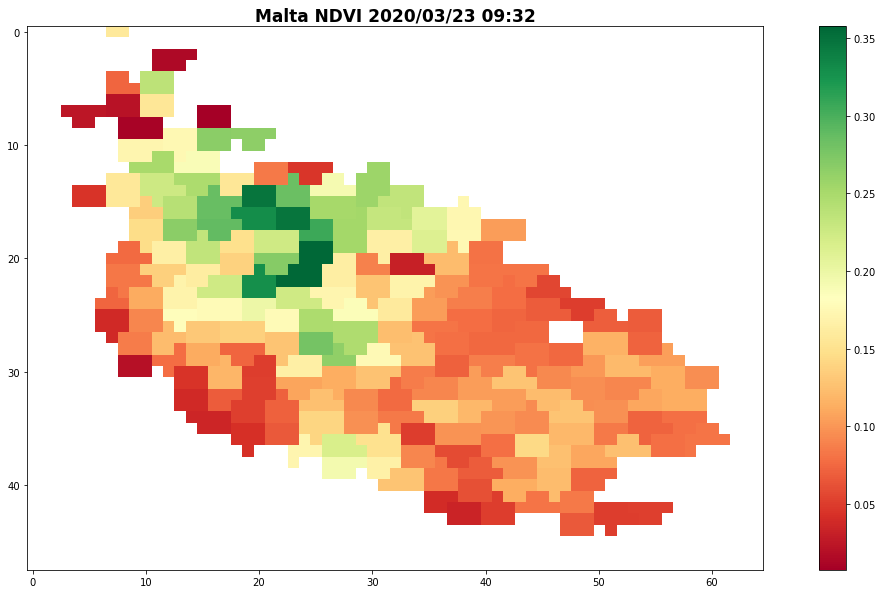

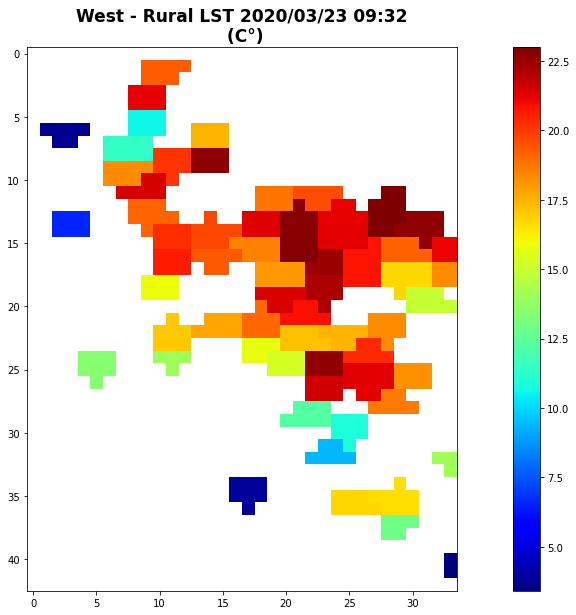

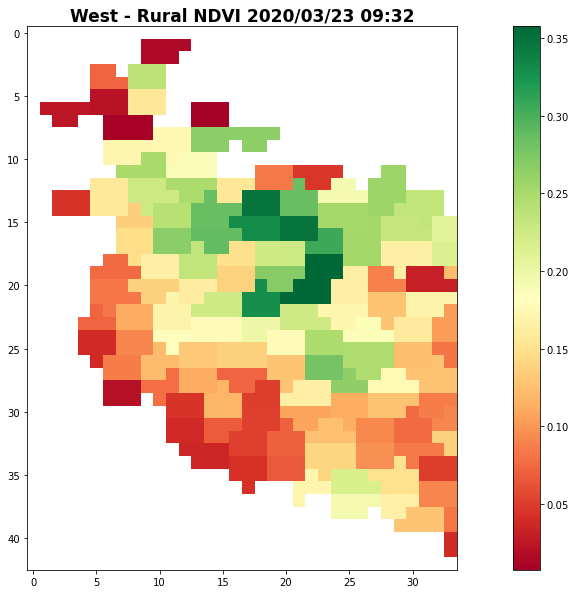

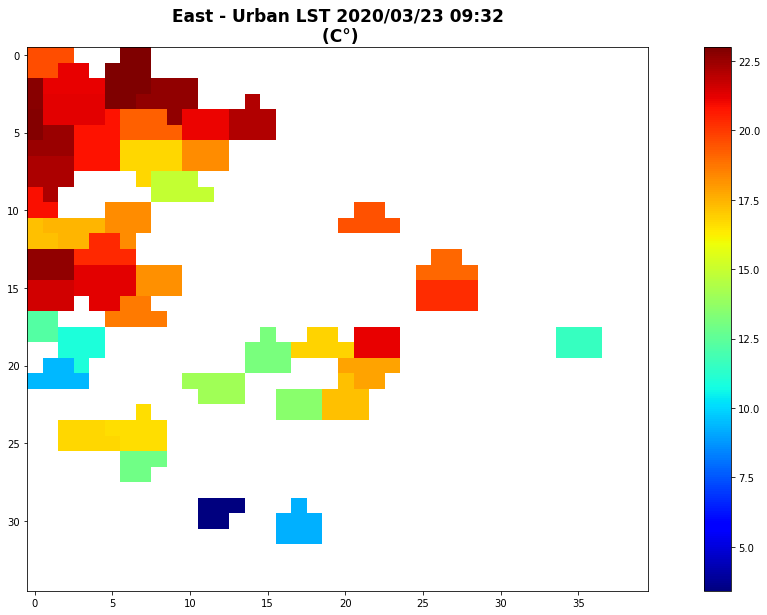

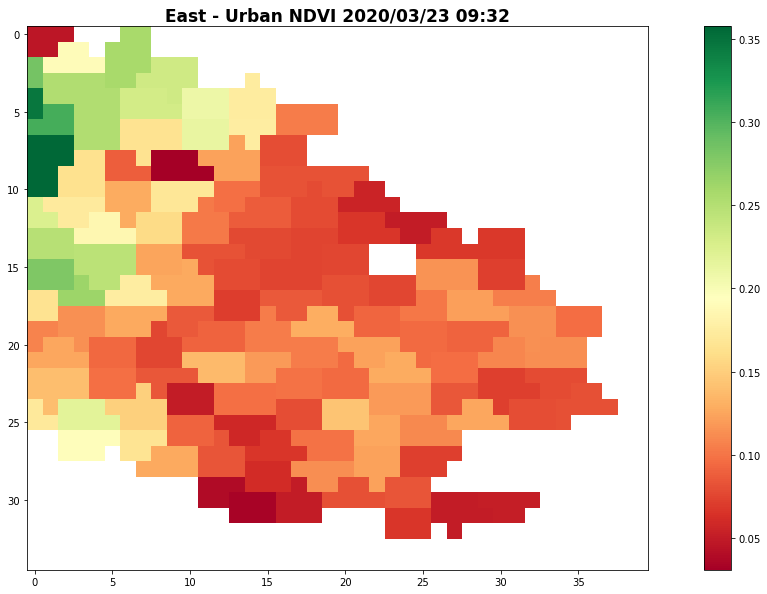

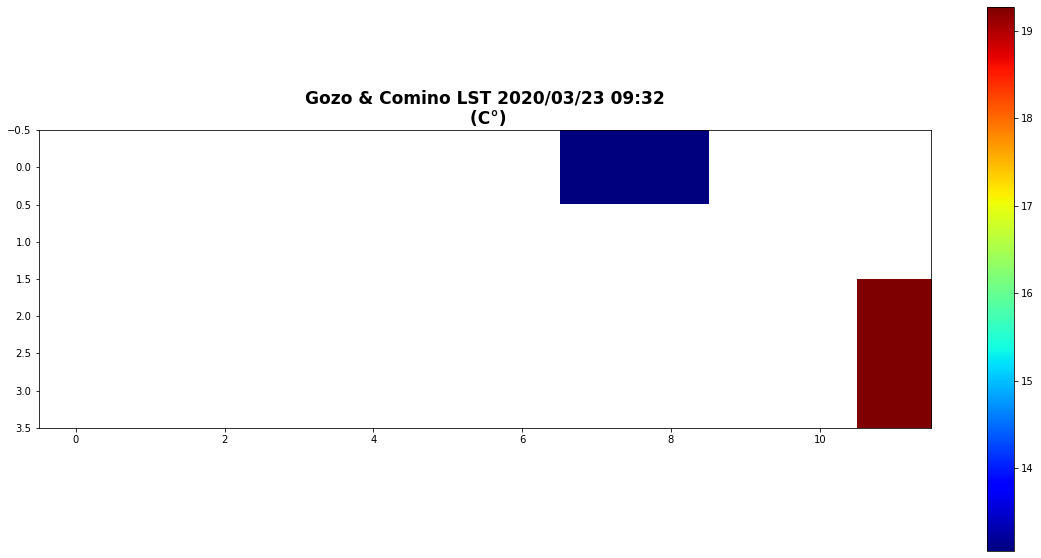

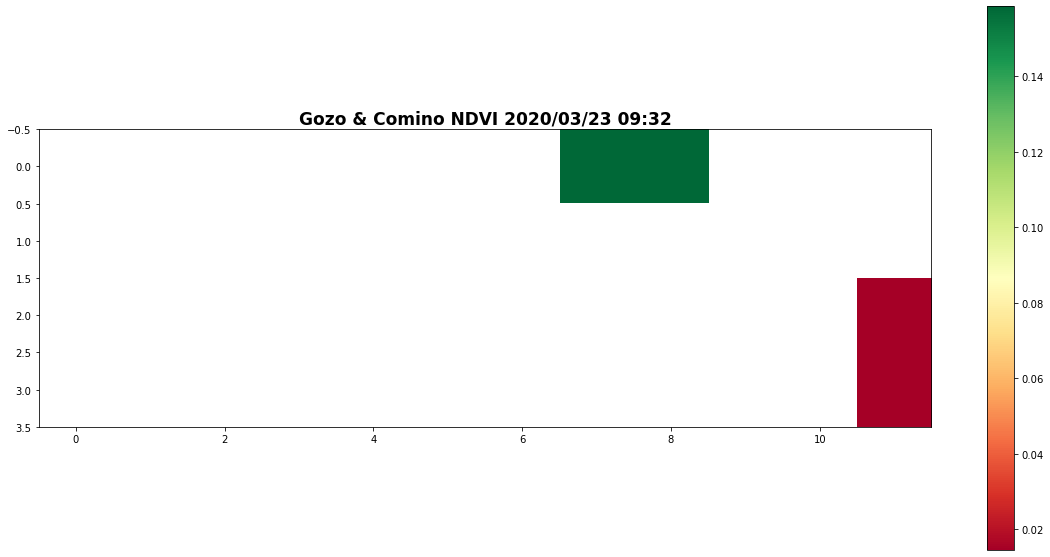

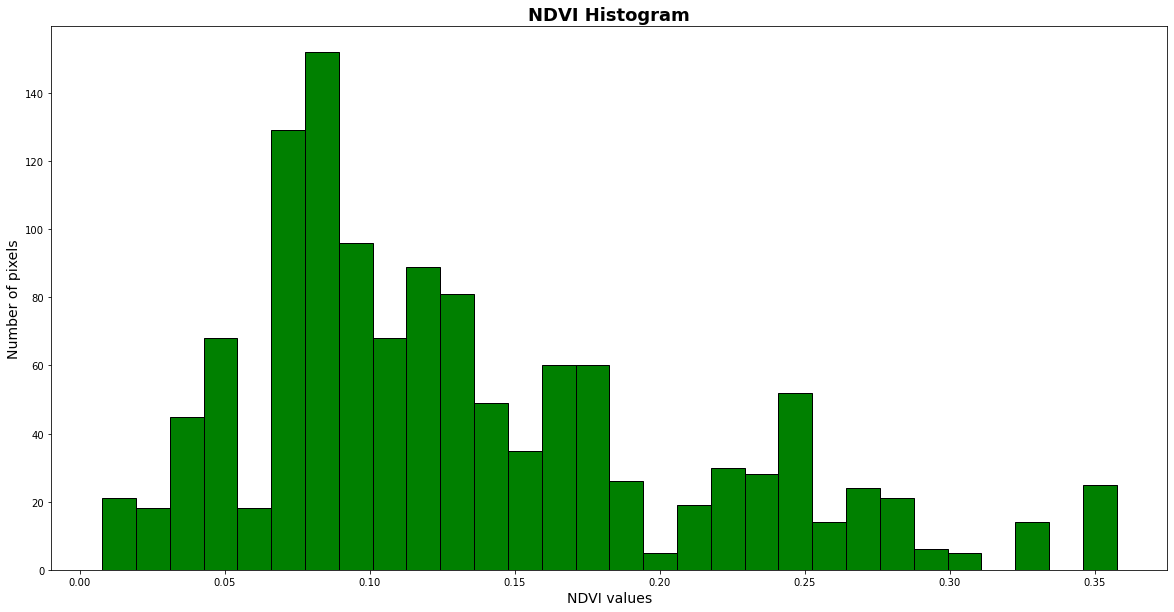

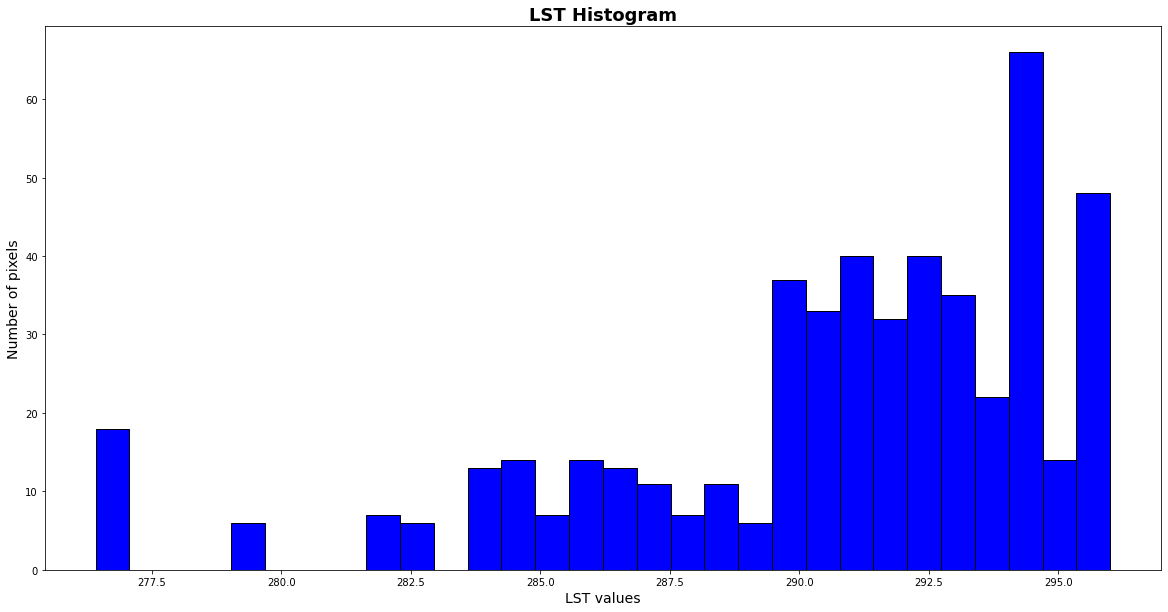

###################


LST mean:
306.3526916503906 Kelvin
33.352691650390625 Celcius
Max LST Pixel value: 
38.183990478515625 Kelvin
38.183990478515625 Celcius

LST mean West:
578.7729797363281 Kelvin
305.77298 Celcius

Max LST Pixel value West: 
311.1839904785156 Kelvin
38.183990478515625 Celcius

LST mean East:
307.2271423339844 Kelvin
34.227142333984375 Celcius

Max LST Pixel value East: 
311.1839904785156 Kelvin
38.183990478515625 Celcius

NDVI mean Malta:
0.23081122

NDVI mean West:
0.25764483

NDVI mean East:
0.21275188

SUHI MAX:
-235.07365435361862

SUHI MEAN:
-0.04489295


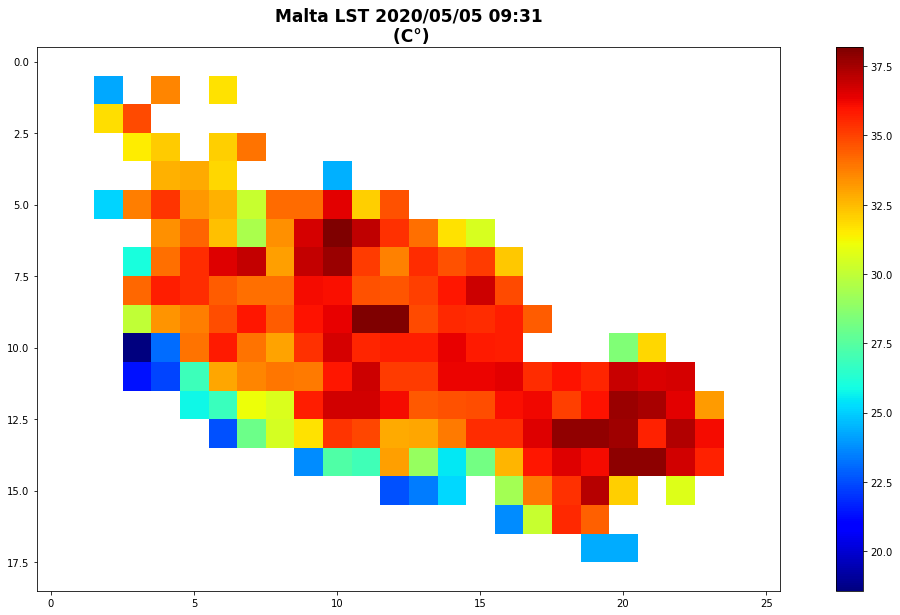

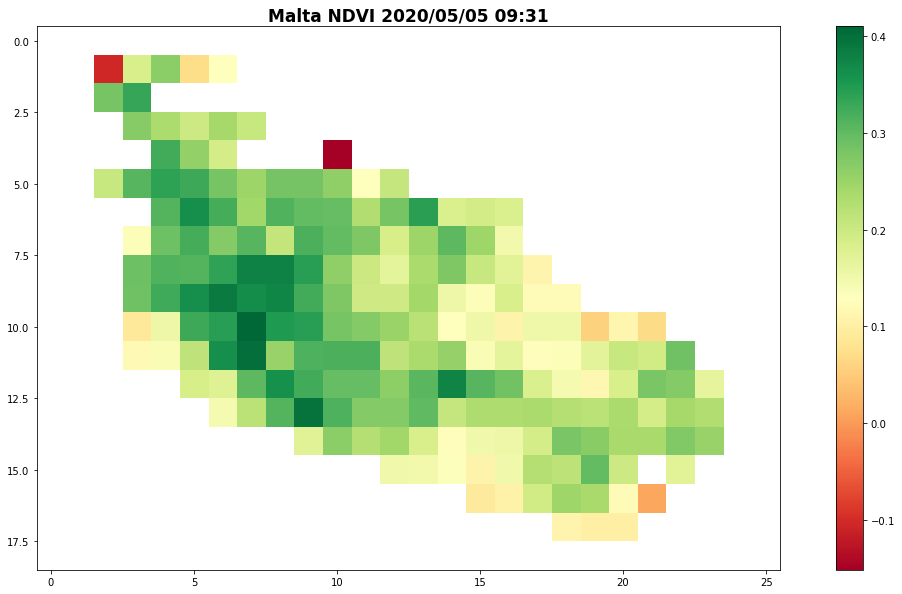

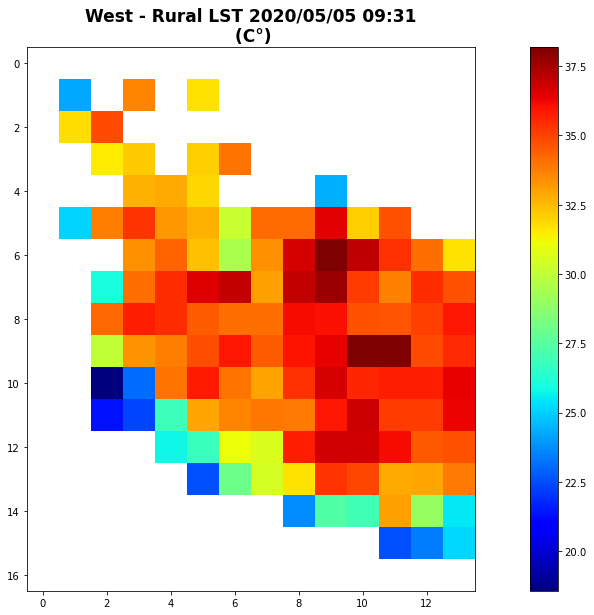

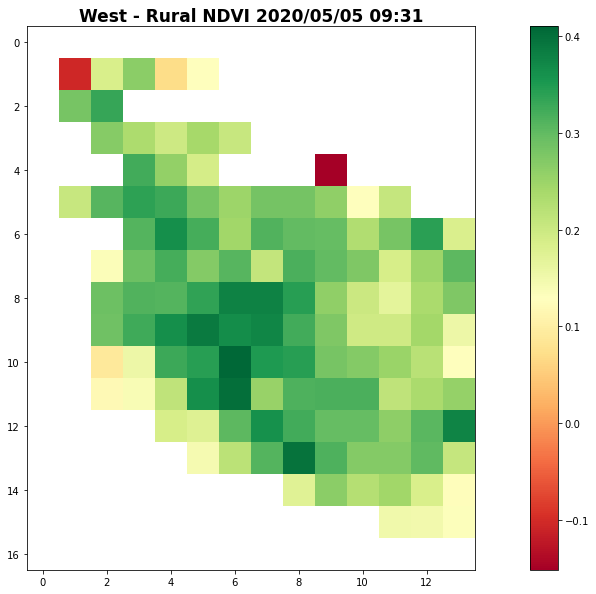

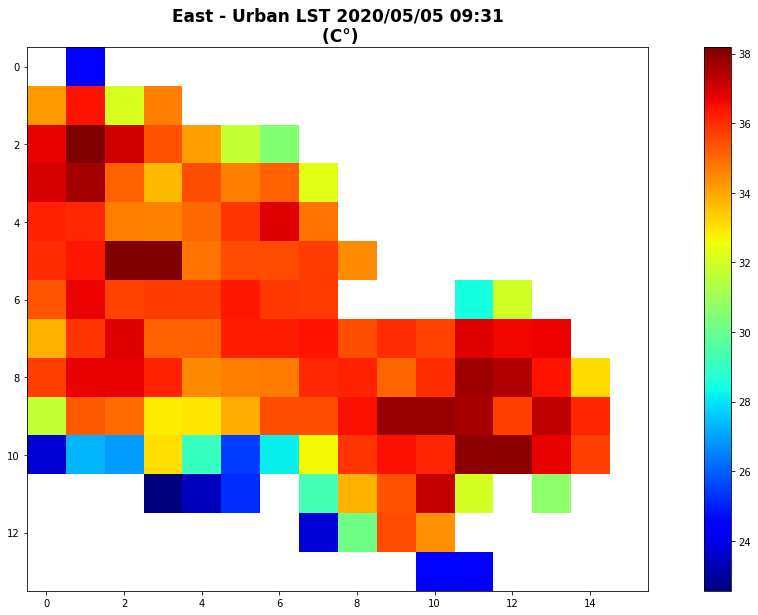

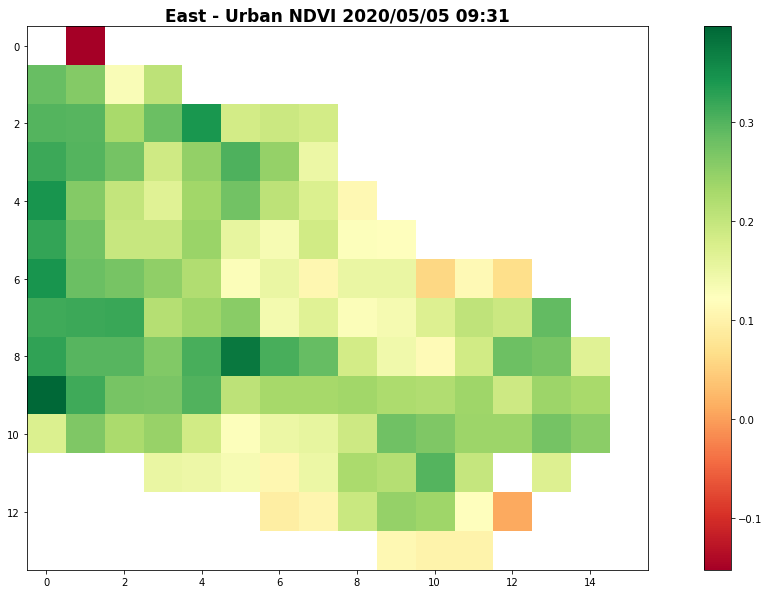

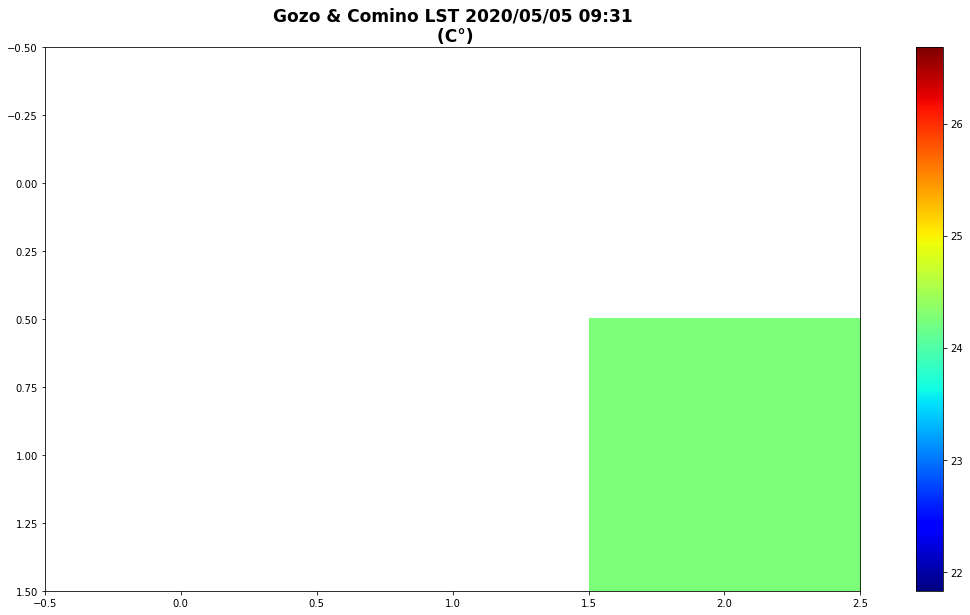

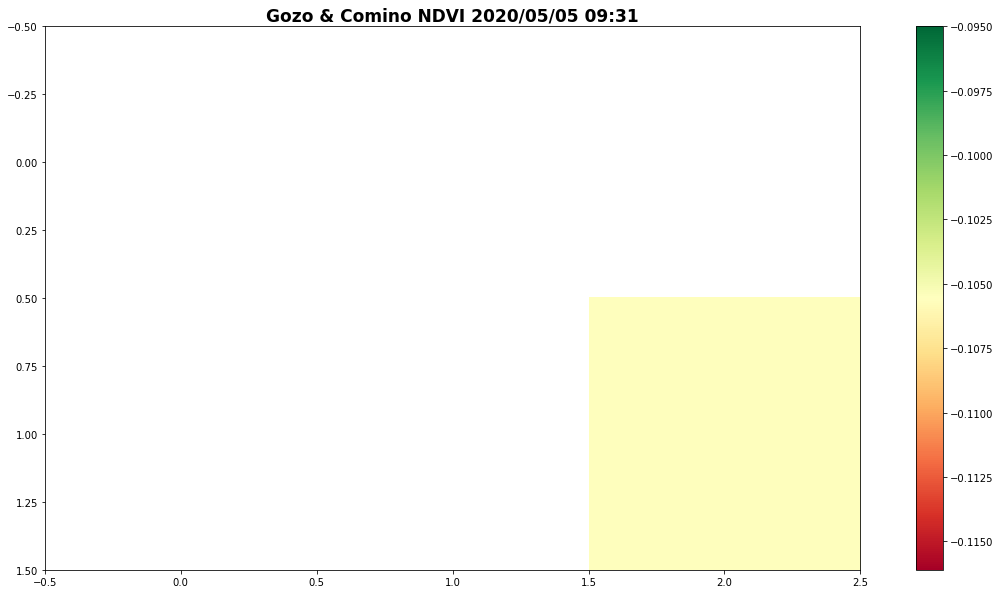

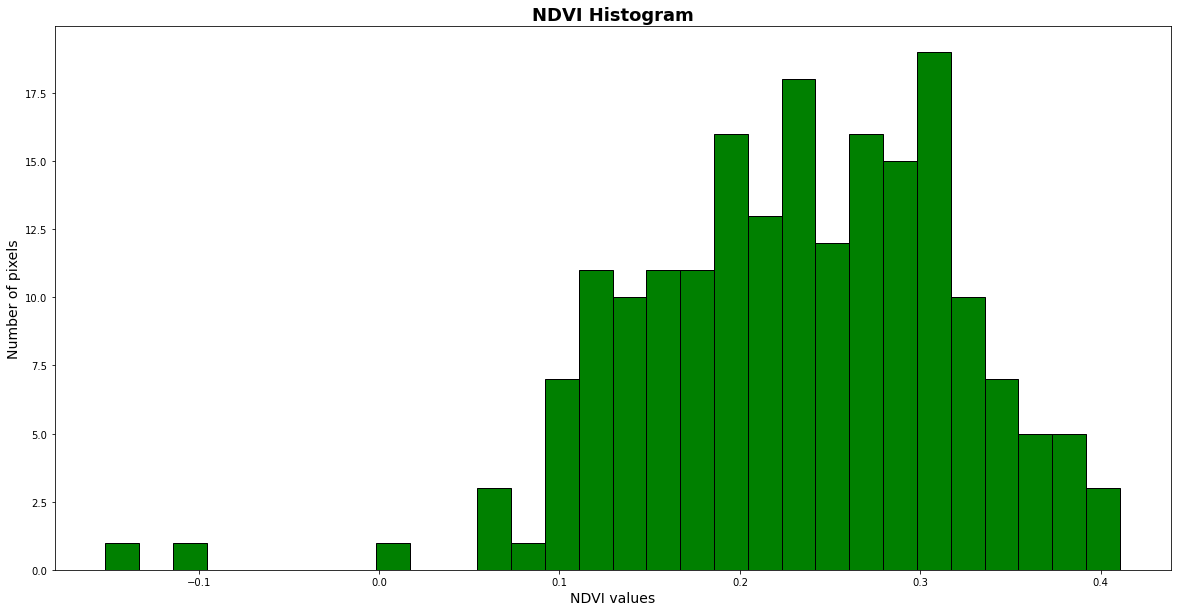

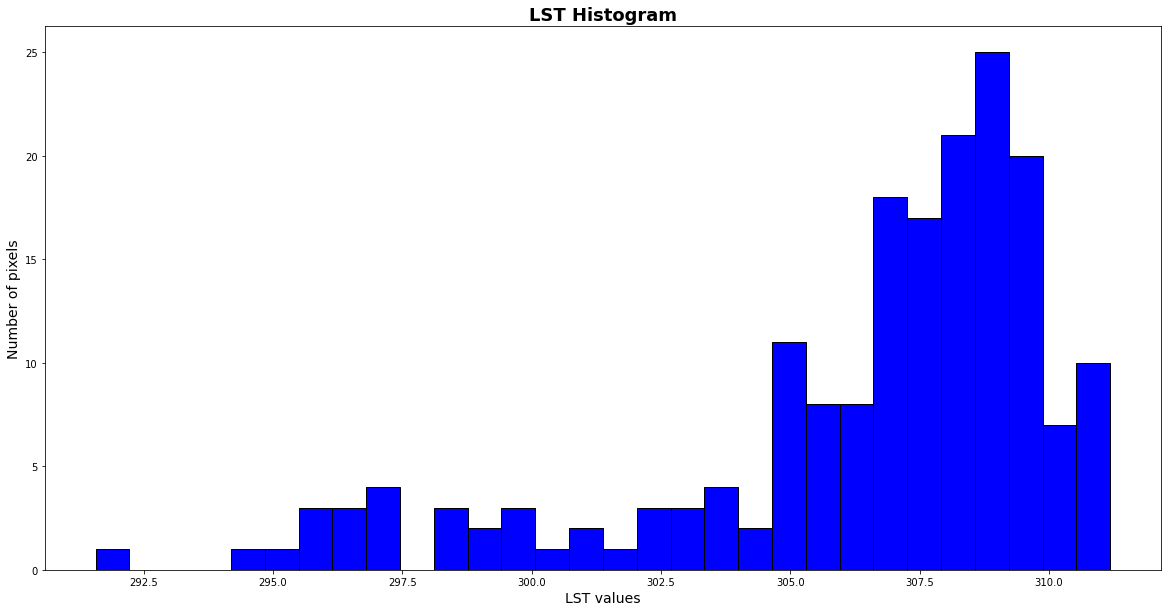

###################


LST mean:
312.7675476074219 Kelvin
39.767547607421875 Celcius
Max LST Pixel value: 
44.614013671875 Kelvin
44.614013671875 Celcius

LST mean West:
586.1281433105469 Kelvin
313.12814 Celcius

Max LST Pixel value West: 
317.614013671875 Kelvin
44.614013671875 Celcius

LST mean East:
313.1372375488281 Kelvin
40.137237548828125 Celcius

Max LST Pixel value East: 
317.4800109863281 Kelvin
44.480010986328125 Celcius

NDVI mean Malta:
0.18512307

NDVI mean West:
0.2155434

NDVI mean East:
0.16539192

SUHI MAX:
-228.7355324178934

SUHI MEAN:
-0.050151482


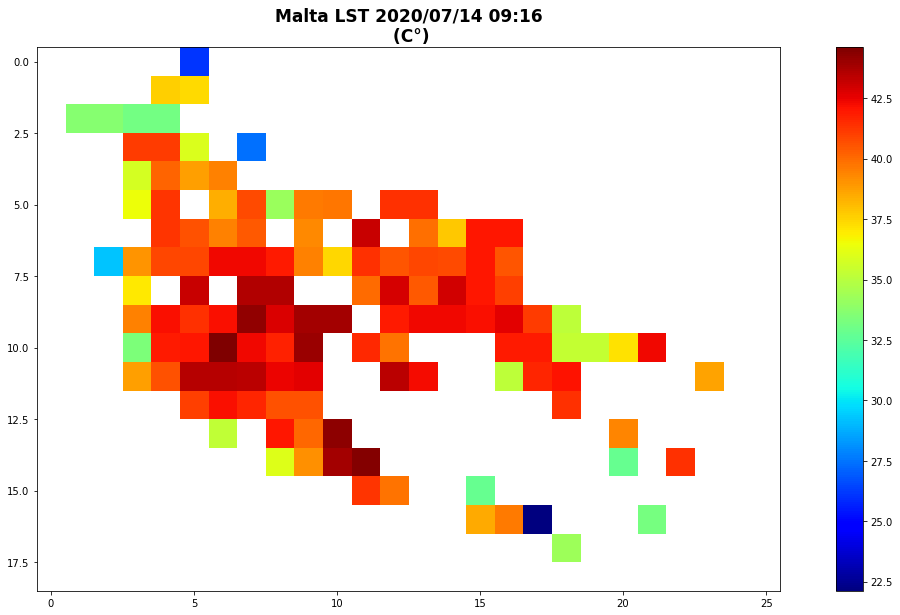

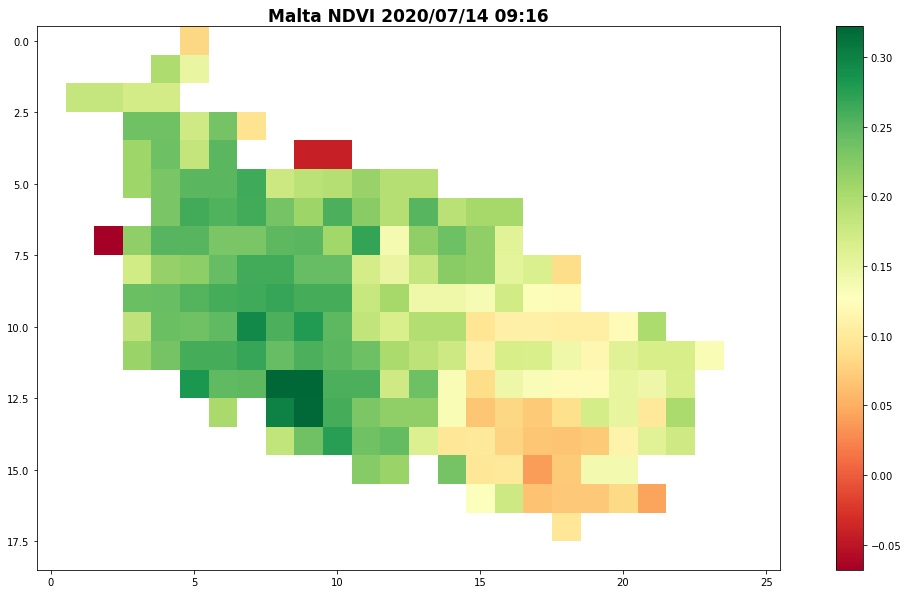

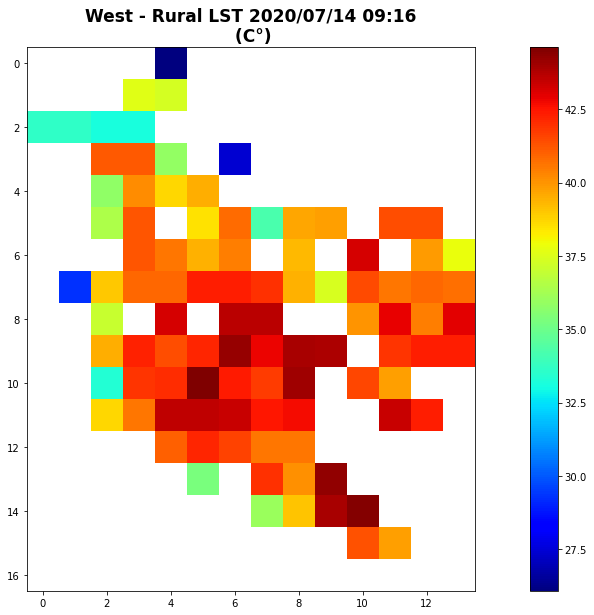

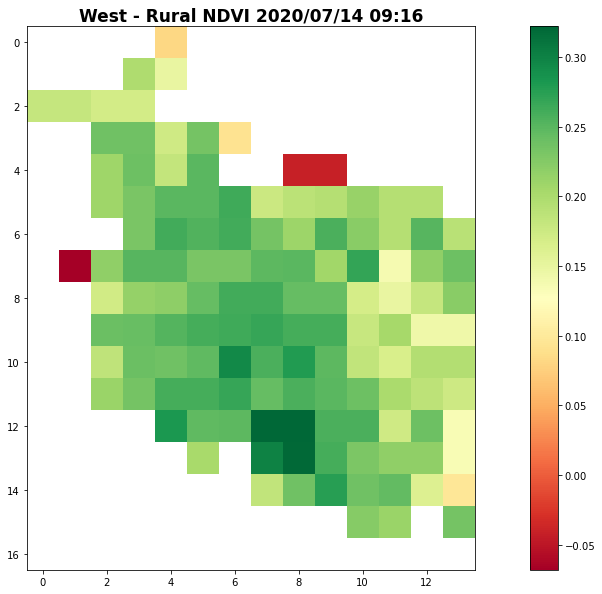

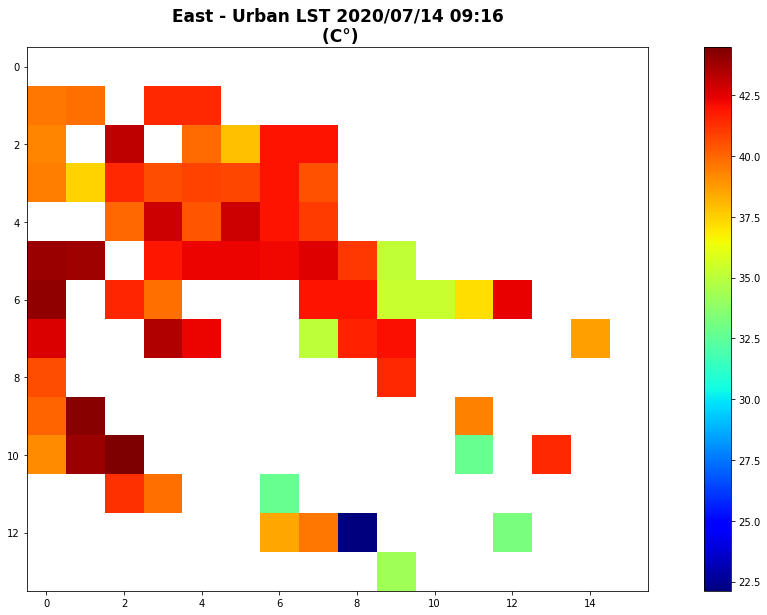

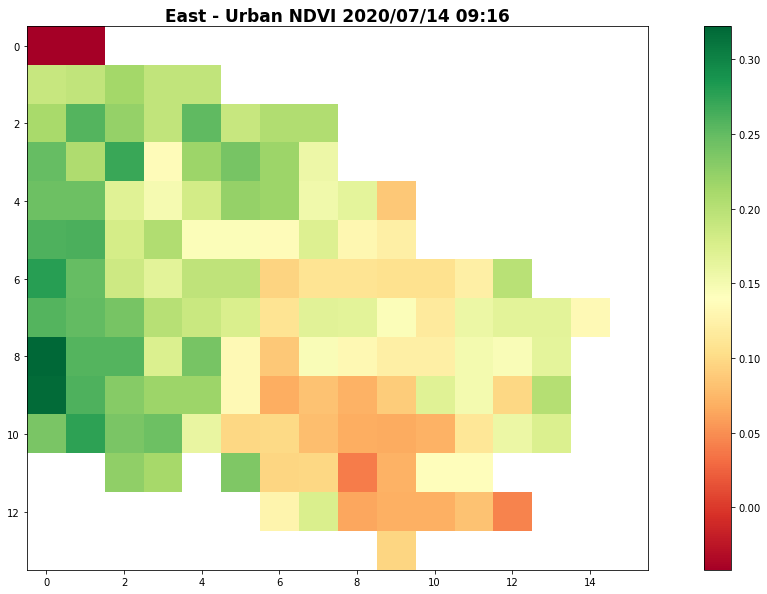

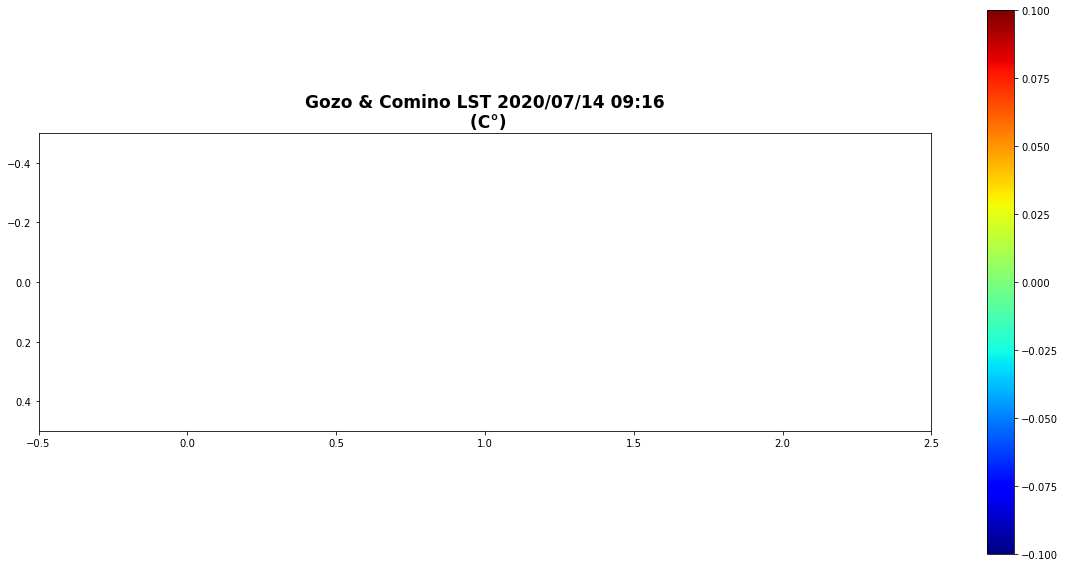

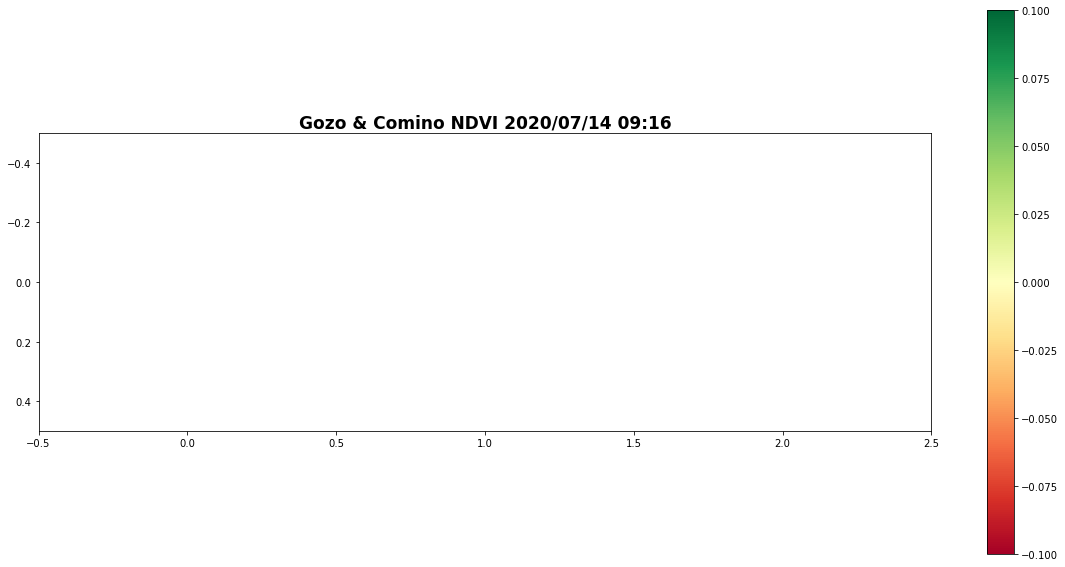

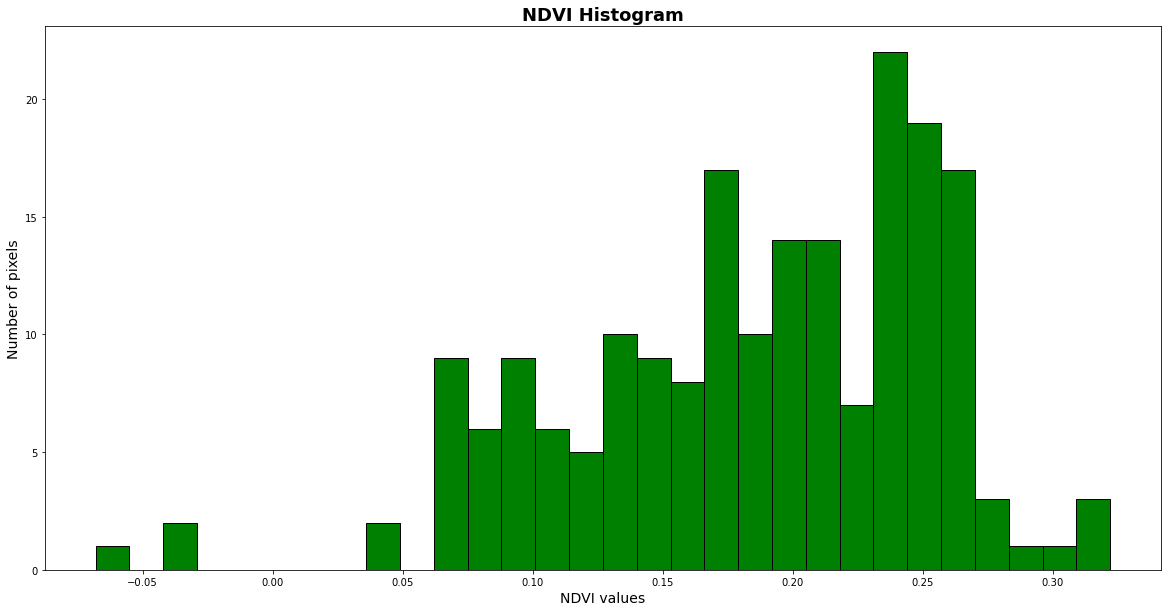

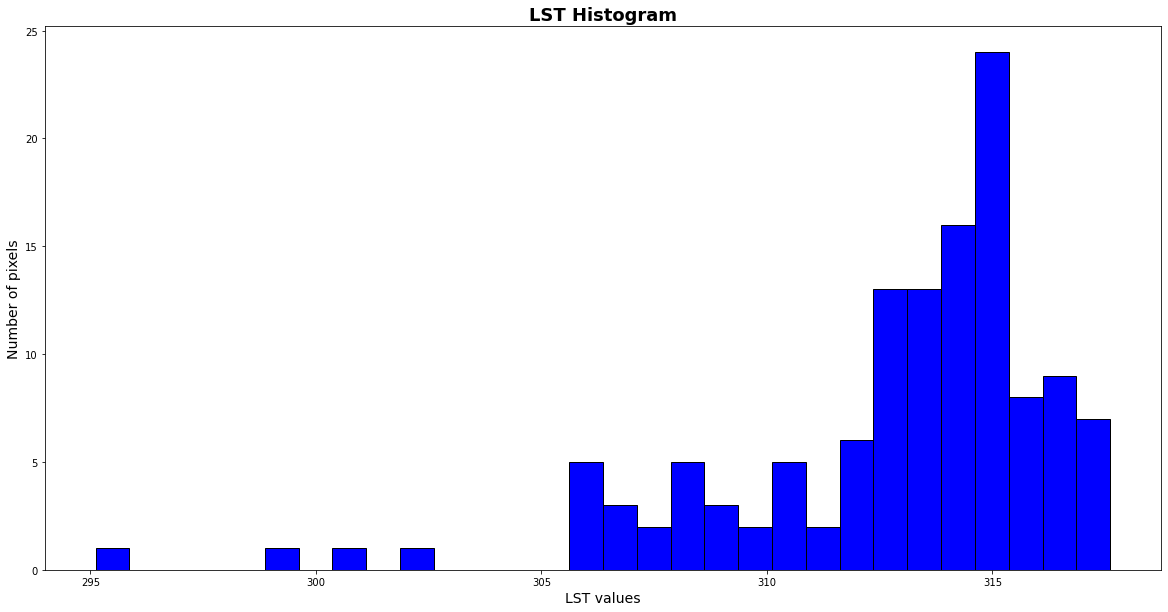

###################


LST mean:
255.64662170410156 Kelvin
-17.353378295898438 Celcius
Max LST Pixel value: 
30.105987548828125 Kelvin
30.105987548828125 Celcius

LST mean West:
535.279296875 Kelvin
262.2793 Celcius

Max LST Pixel value West: 
303.010009765625 Kelvin
30.010009765625 Celcius

LST mean East:
270.8192138671875 Kelvin
-2.1807861328125 Celcius

Max LST Pixel value East: 
303.1059875488281 Kelvin
30.105987548828125 Celcius

NDVI mean Malta:
0.3239096

NDVI mean West:
0.34268844

NDVI mean East:
0.30617705

SUHI MAX:
-243.23670089244843

SUHI MEAN:
-0.03651139


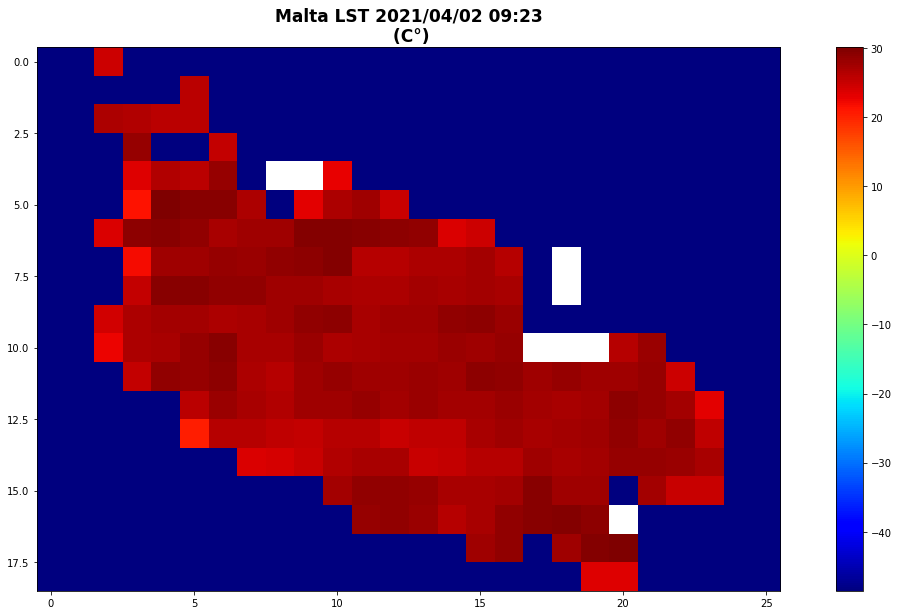

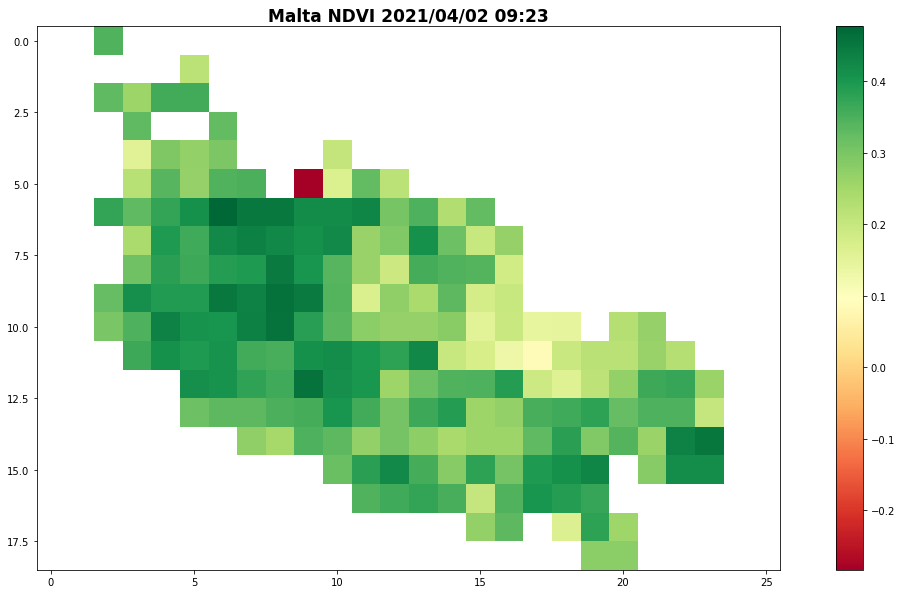

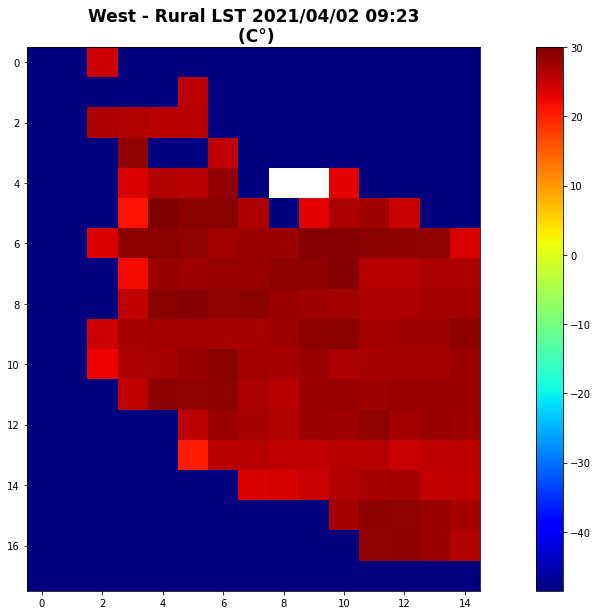

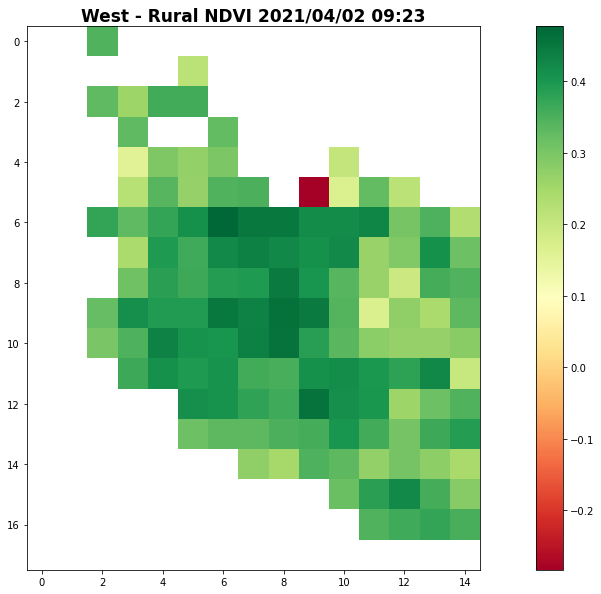

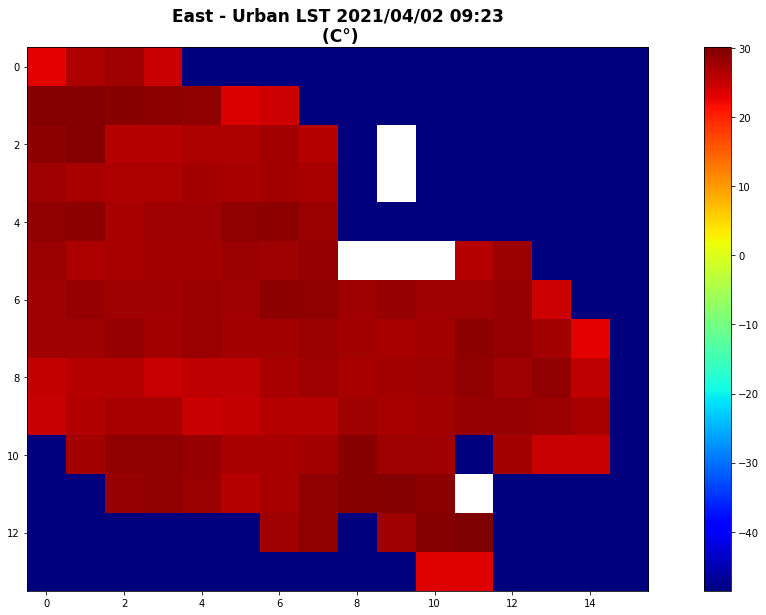

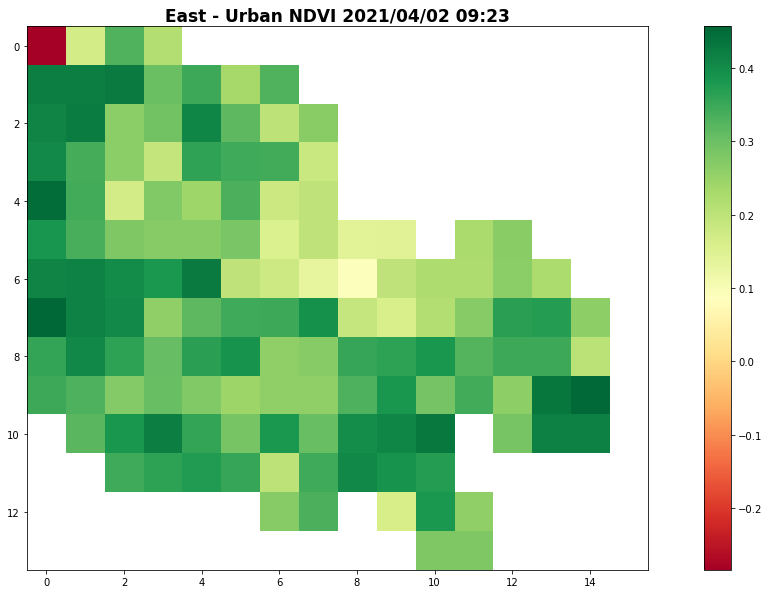

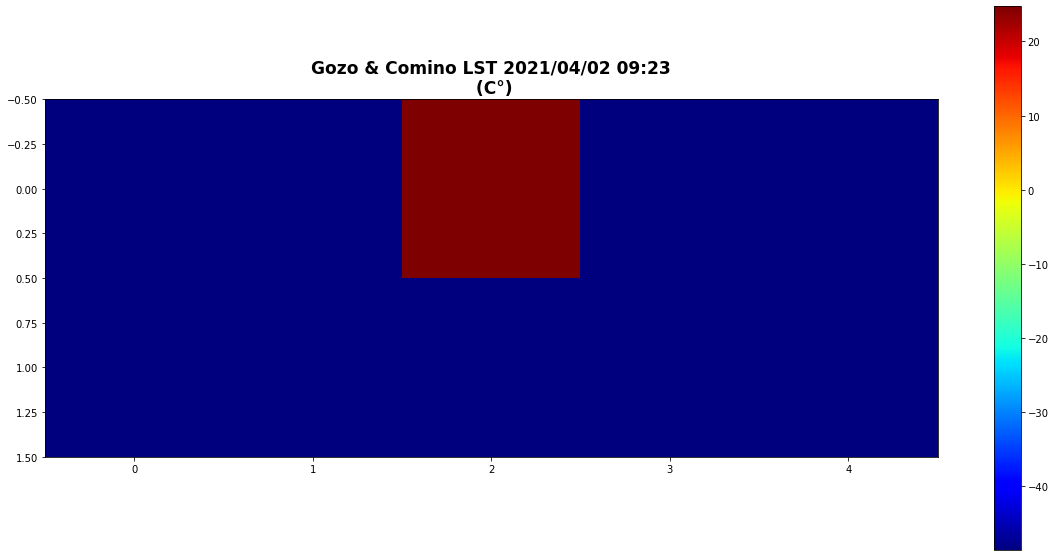

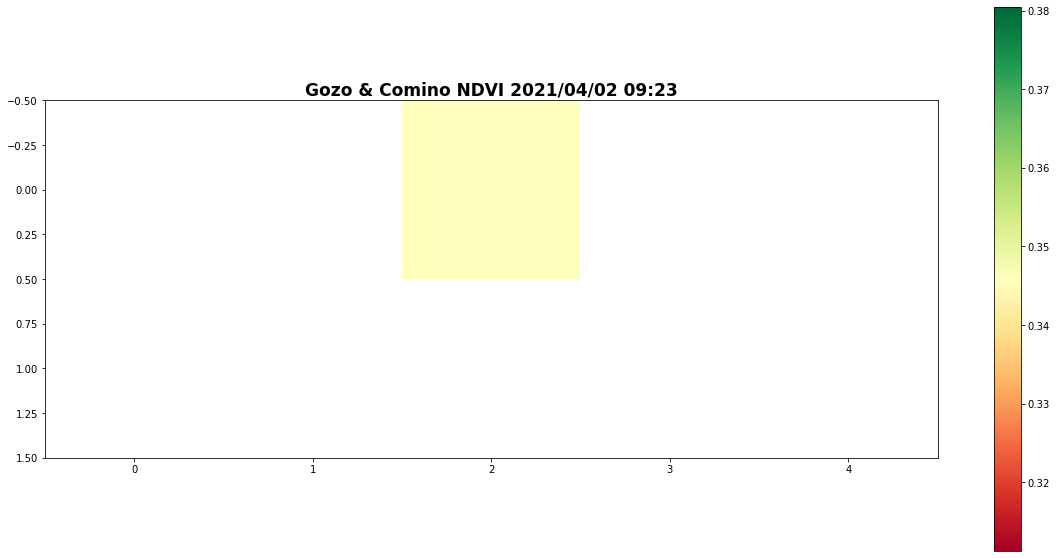

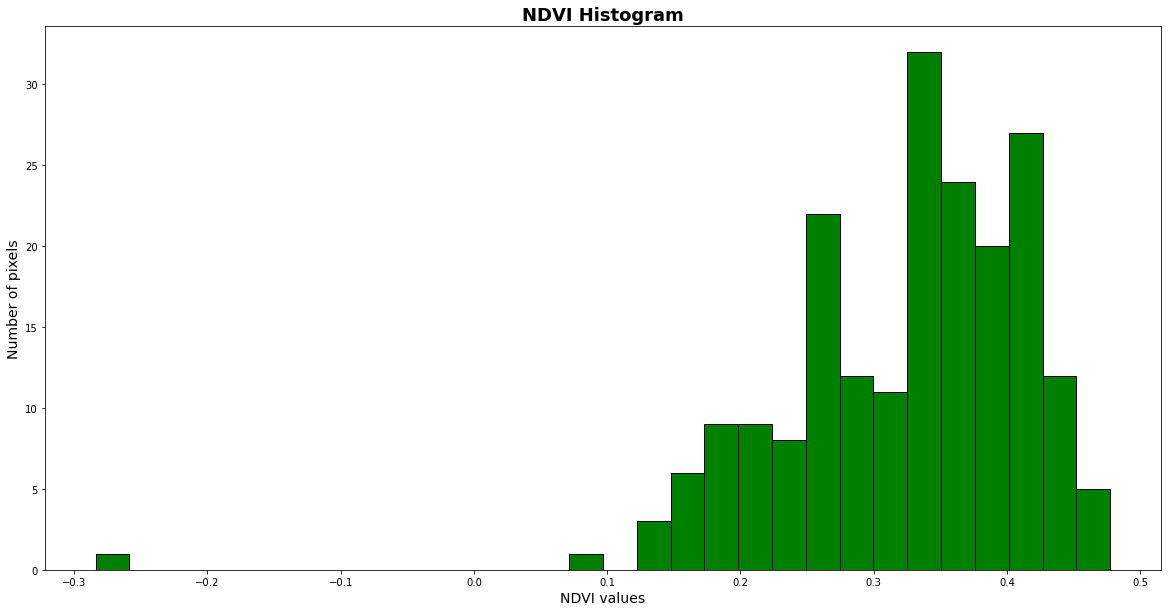

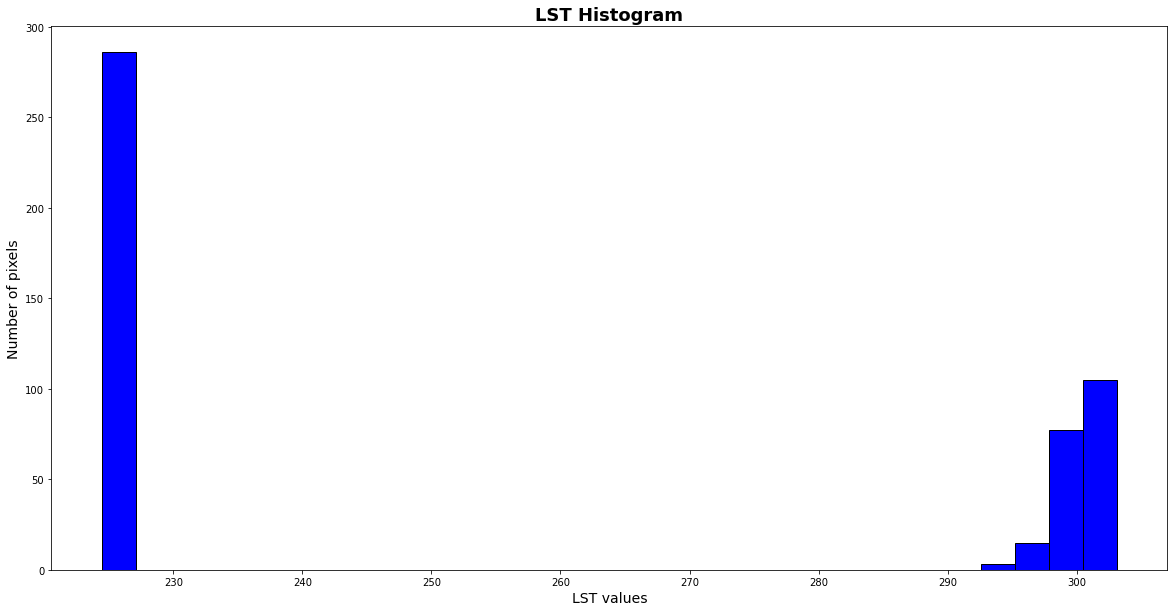

###################


LST mean:
nan Kelvin
nan Celcius
Max LST Pixel value: 
Error: 2022/04/19


c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


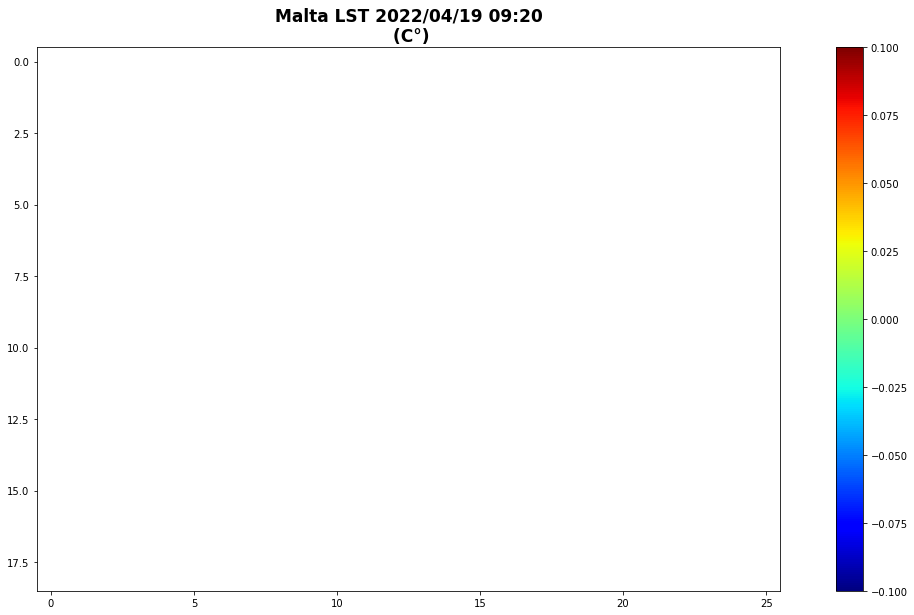

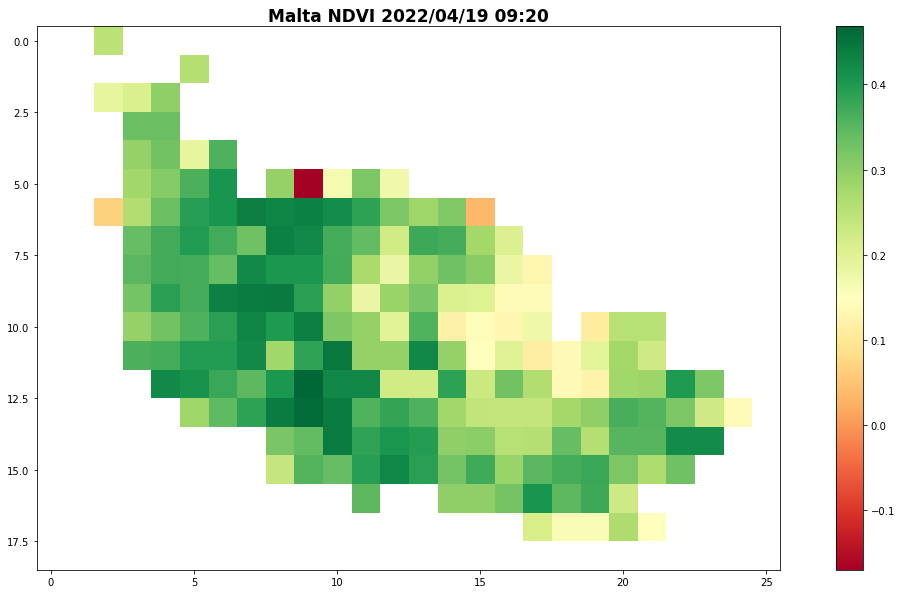

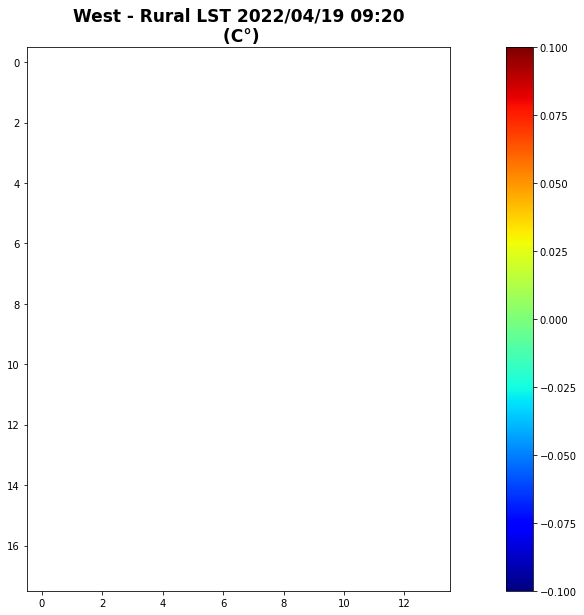

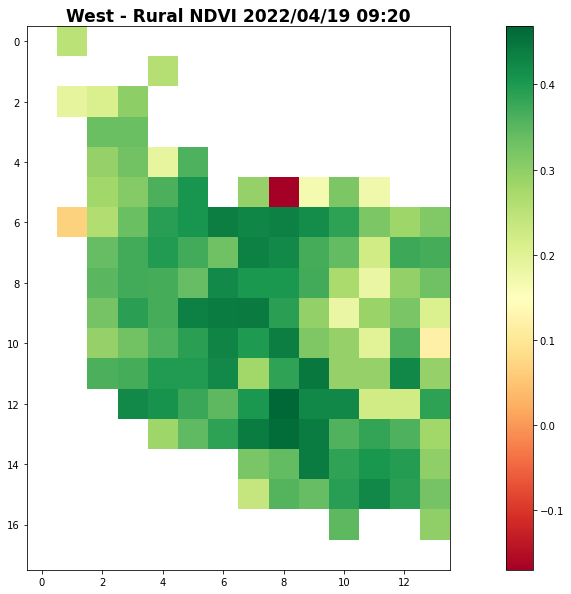

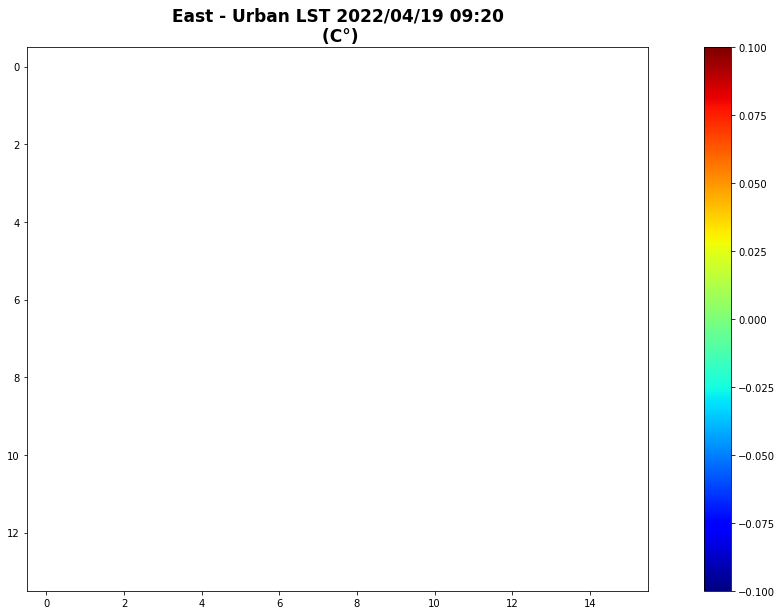

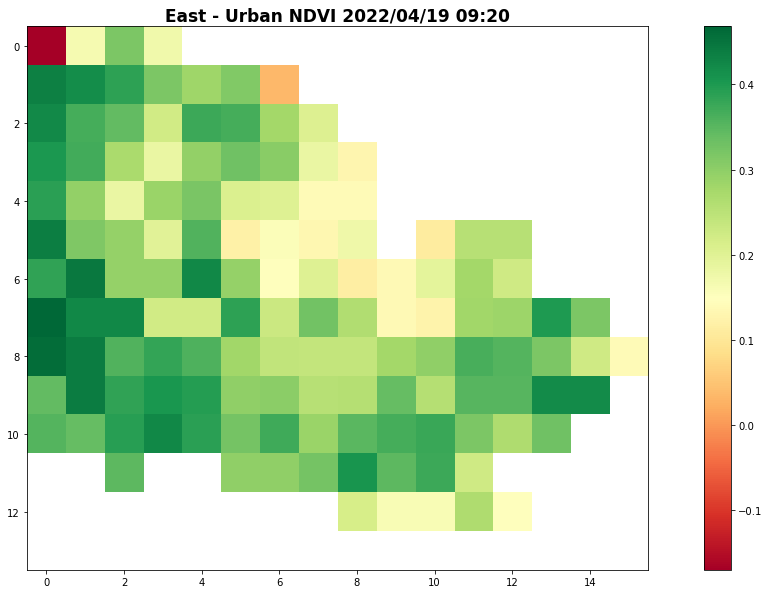

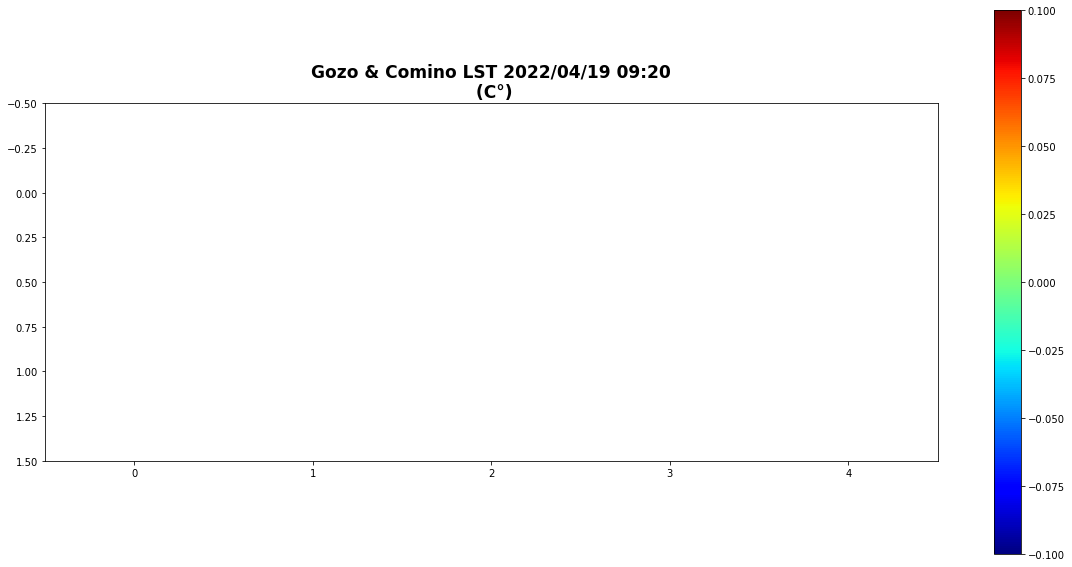

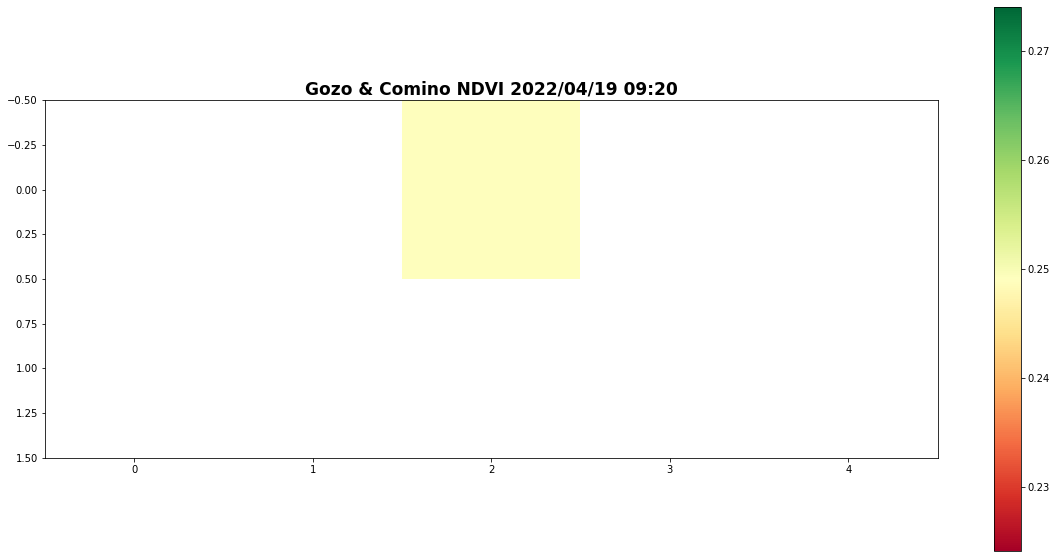

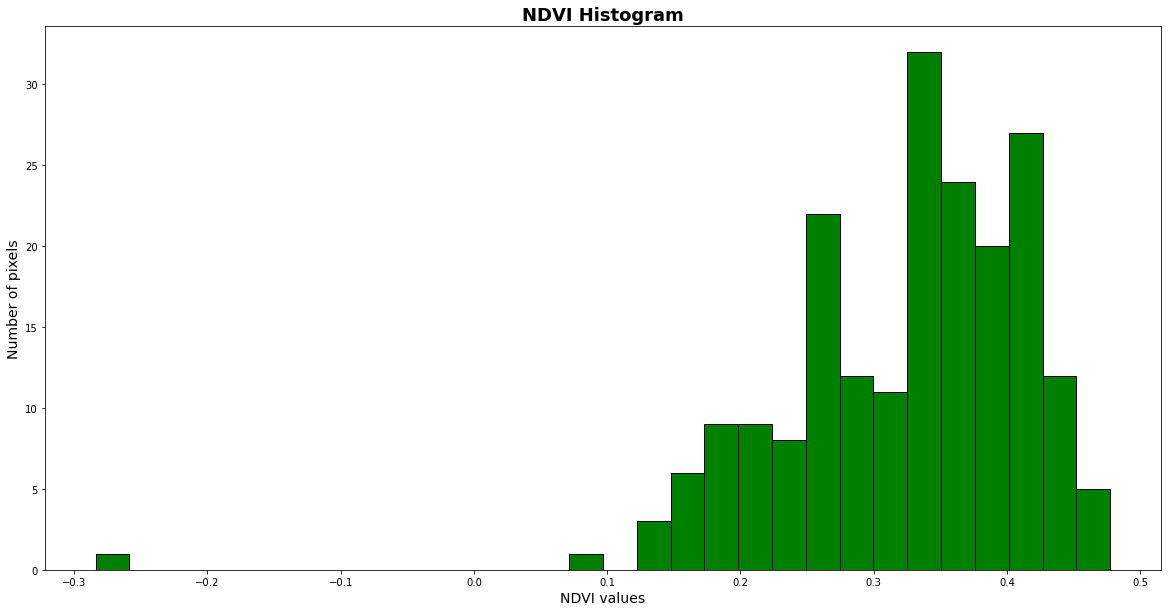

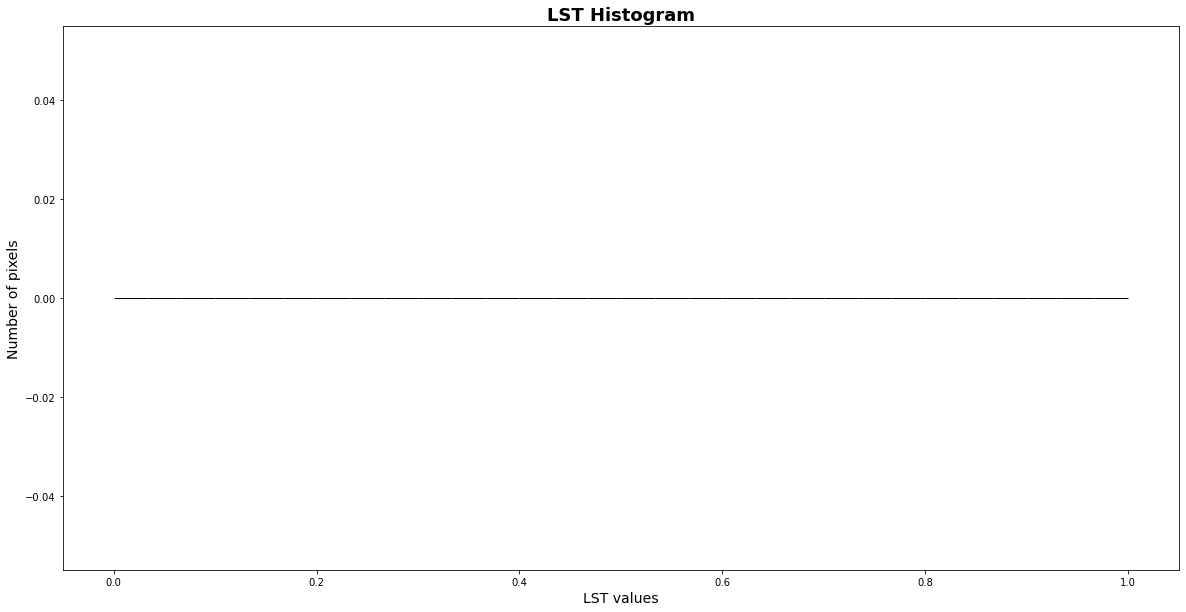

###################




In [34]:
for root, dirs, files in os.walk(base_directory):
    path = root.split(os.sep)
    print('Directory open:')
    print(path)    
    ###Gathering Product details such as date & time and storing them
    for name in files:       

        temp_product = str(name)[17:46] #30chars include: (0-2)Sat, (4-8)Sensor, (13-31)Type, Year, Month, Date, Time

        date = temp_product[16:24]
        date = date[:4] + '/' + date[4:6] + '/' + date[6:]       

        time = temp_product[25:29]
        time = time[:2] + ':' + time[2:]        

        ####
        ####
        #product to be used
        product_path = str(os.path.join(root, name))
        print(product_path)
        
        archi=File(product_path)
        product = ProductIO.readProduct(archi)
        reader = snappy.ProductIO.getProductReader('SEN3')

        ##Subset to Malta
        product = Subset(product, geomMaltaOnly)
        ##Subset to West
        productWest = Subset(product, geomWest)
        ##Subset to East
        productEast = Subset(product, geomEast)
        ##Subset to East
        productGozo = Subset(product, geomGozo)
        
        ##
        ##Get LST Band
        #Malta
        lst_band = product.getBand('LST')
        lst_w = product.getSceneRasterWidth() # Get Band Width
        lst_h = product.getSceneRasterHeight() # Get Band Height
        #West
        lst_band_west = productWest.getBand('LST')
        lst_w_west = productWest.getSceneRasterWidth()
        lst_h_west = productWest.getSceneRasterHeight() 
        #East
        lst_band_east = productEast.getBand('LST')
        lst_w_east = productEast.getSceneRasterWidth()
        lst_h_east = productEast.getSceneRasterHeight()  
        #Gozo
        lst_band_gozo = productGozo.getBand('LST')
        lst_w_gozo = productGozo.getSceneRasterWidth()
        lst_h_gozo = productGozo.getSceneRasterHeight()         

        ##Get NDVI Band
        #Malta
        ndvi_band = product.getBand('NDVI')
        ndvi_w = product.getSceneRasterWidth() # Get Band Width
        ndvi_h = product.getSceneRasterHeight() # Get Band Height
        #West
        ndvi_band_west = productWest.getBand('NDVI')
        ndvi_w_west = productWest.getSceneRasterWidth() # Get Band Width
        ndvi_h_west = productWest.getSceneRasterHeight()
        #East
        ndvi_band_east = productEast.getBand('NDVI')
        ndvi_w_east = productEast.getSceneRasterWidth() # Get Band Width
        ndvi_h_east = productEast.getSceneRasterHeight()
        #Gozo
        ndvi_band_gozo = productGozo.getBand('NDVI')
        ndvi_w_gozo = productGozo.getSceneRasterWidth() # Get Band Width
        ndvi_h_gozo = productGozo.getSceneRasterHeight()

        ##Create empty arrays
        #Malta
        lst_band_data = np.zeros(lst_w * lst_h, np.float32)
        ndvi_band_data = np.zeros(ndvi_w * ndvi_h, np.float32)
        #West
        lst_band_data_west = np.zeros(lst_w_west * lst_h_west, np.float32)
        ndvi_band_data_west = np.zeros(ndvi_w_west * ndvi_h_west, np.float32)
        #East
        lst_band_data_east = np.zeros(lst_w_east * lst_h_east, np.float32)
        ndvi_band_data_east = np.zeros(ndvi_w_east * ndvi_h_east, np.float32)
        #Gozo
        lst_band_data_gozo = np.zeros(lst_w_gozo * lst_h_gozo, np.float32)
        ndvi_band_data_gozo = np.zeros(ndvi_w_gozo * ndvi_h_gozo, np.float32)

        ##Populate arrays with pixel value
        #Malta
        lst_band.readPixels(0, 0, lst_w, lst_h, lst_band_data) 
        ndvi_band.readPixels(0, 0, ndvi_w, ndvi_h, ndvi_band_data)
        #East
        lst_band_east.readPixels(0, 0, lst_w_east, lst_h_east, lst_band_data_east) 
        ndvi_band_east.readPixels(0, 0, ndvi_w_east, ndvi_h_east, ndvi_band_data_east)
        #West
        lst_band_west.readPixels(0, 0, lst_w_west, lst_h_west, lst_band_data_west) 
        ndvi_band_west.readPixels(0, 0, ndvi_w_west, ndvi_h_west, ndvi_band_data_west)
        #Gozo
        lst_band_gozo.readPixels(0, 0, lst_w_gozo, lst_h_gozo, lst_band_data_gozo) 
        ndvi_band_gozo.readPixels(0, 0, ndvi_w_gozo, ndvi_h_gozo, ndvi_band_data_gozo)

        ##Reshape
        #Malta
        lst_band_data.shape = lst_h, lst_w
        ndvi_band_data.shape = ndvi_h, ndvi_w
        #East
        lst_band_data_east.shape = lst_h_east, lst_w_east
        ndvi_band_data_east.shape = ndvi_h_east, ndvi_w_east
        #West
        lst_band_data_west.shape = lst_h_west, lst_w_west
        ndvi_band_data_west.shape = ndvi_h_west, ndvi_w_west
        #Gozo
        lst_band_data_gozo.shape = lst_h_gozo, lst_w_gozo
        ndvi_band_data_gozo.shape = ndvi_h_gozo, ndvi_w_gozo

        ###Collecting Data
        ##LST
        #Malta
        try:
            no_nan_lst_band_data = lst_band_data[~np.isnan(lst_band_data)]
            print('LST mean:')
            mean = np.mean(no_nan_lst_band_data) - 273
            print(str(mean + 273) + ' Kelvin')
            print(str(mean) + ' Celcius')
            

            print('Max LST Pixel value: ')
            max = np.amax(no_nan_lst_band_data) - 273
            print(str(max) + ' Kelvin')
            print(str((max)) + ' Celcius')
            
            #West
            no_nan_lst_band_data_west = lst_band_data_west[~np.isnan(lst_band_data_west)]
            print('\nLST mean West:')
            mean_west = np.mean(no_nan_lst_band_data_west)
            print(str(mean_west + 273) + ' Kelvin')
            print(str(mean_west) + ' Celcius')
            

            print('\nMax LST Pixel value West: ')
            max_west = np.amax(no_nan_lst_band_data_west) - 273
            print(str(max_west + 273) + ' Kelvin')
            print(str((max_west)) + ' Celcius')
            
            #East
            no_nan_lst_band_data_east = lst_band_data_east[~np.isnan(lst_band_data_east)]
            print('\nLST mean East:')
            mean_east = np.mean(no_nan_lst_band_data_east) - 273
            print(str(mean_east + 273) + ' Kelvin')
            print(str(mean_east) + ' Celcius')
            

            print('\nMax LST Pixel value East: ')
            max_east = np.amax(no_nan_lst_band_data_east) - 273
            print(str(max_east + 273) + ' Kelvin')
            print(str((max_east)) + ' Celcius')
            

            ##NDVI
            #Malta
            no_nan_ndvi_band_data = ndvi_band_data[~np.isnan(ndvi_band_data)]
            print('\nNDVI mean Malta:')
            mean = np.mean(no_nan_ndvi_band_data)
            print(str(mean))        
            
            #West
            no_nan_ndvi_band_data_west = ndvi_band_data_west[~np.isnan(ndvi_band_data_west)]
            print('\nNDVI mean West:')
            mean_west = np.mean(no_nan_ndvi_band_data_west)
            print(str(mean_west))      
            
            #East
            no_nan_ndvi_band_data_east = ndvi_band_data_east[~np.isnan(ndvi_band_data_east)]
            print('\nNDVI mean East:')
            mean_east = np.mean(no_nan_ndvi_band_data_east)
            print(str(mean_east))  
            

            ##SUHI_MAX
            suhi_m = max_east - mean_west            
            print('\nSUHI MAX:\n' + str(suhi_m - 273))
            ##SUHI_MEAN
            suhi_mn = mean_east - mean_west            
            print('\nSUHI MEAN:\n' + str(suhi_mn))
        except ValueError:
            '''
            arrLen = len(full_name)
            arrLen = arrLen - 1

            del full_name[-1]
            del product_name[-1]
            del product_paths[-1]
            del sat[-1]
            del sensor[-1]
            del date_format[-1]
            del time_format[-1]
            del lst_mean[-1]
            del lst_max[-1]
            del lst_mean_west[-1]
            del lst_max_west[-1]
            del lst_mean_east[-1]
            del lst_max_east[-1]
            del ndvi[-1]
            del ndvi_east[-1]
            del ndvi_west[-1]
            del suhi_max[-1]
            del suhi_mean[-1]
            '''

            print('Error: ' + date)
            pass

        ###
        #Plot the band       
        #Malta
        plotLstNdvi(lst_band_data, ndvi_band_data, date, time, "Malta")
        #West
        plotLstNdvi(lst_band_data_west, ndvi_band_data_west, date, time, "West - Rural")
        #East
        plotLstNdvi(lst_band_data_east, ndvi_band_data_east, date, time, "East - Urban")
        #East
        plotLstNdvi(lst_band_data_gozo, ndvi_band_data_gozo, date, time, "Gozo & Comino")

        ####
        #Histogram
        histogram(no_nan_lst_band_data, no_nan_ndvi_band_data)

        full_name.append(str(name))
        product_name.append(temp_product) 
        date_format.append(date)
        sat.append(temp_product[:3])
        sensor.append(temp_product[4:12])
        time_format.append(time)
        product_paths.append(product_path)
        lst_mean.append(mean)
        lst_max.append(max)
        lst_mean_west.append(mean_west)
        lst_max_west.append(max_west)
        lst_mean_east.append(mean_east)
        lst_max_east.append(max_east)
        ndvi.append(mean)
        ndvi_east.append(mean_east)  
        ndvi_west.append(mean_west) 
        suhi_max.append(suhi_m)  
        suhi_mean.append(suhi_mn)

        #end
        print('###################\n\n')

In [36]:
write_to_csv( sat, date_format, sensor, time_format, full_name, lst_mean, lst_max, ndvi, lst_mean_east, lst_max_east, lst_mean_west, lst_max_west, ndvi_east, ndvi_west, suhi_max, suhi_mean)
##https://forum.step.esa.int/t/sentinel-3-slstr-level-2-lst-cloud-mask/16471/2

In [7]:
##Analysis
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt


In [8]:
def generatePlotQuota(df, column_name1, column_name2, quota_count, quota_legend, title, subtitle): 

    fig1, ax = plt.subplots(1, 2, figsize=(30,15))
    ax[0].plot(dataframe['Date'], dataframe[column_name1])
    ax[0].set_title(column_name1)
    ax[0].set_xticks(dataframe.Date)
    ax[0].set_xticklabels(dataframe.Date, rotation=90)

    ax[1].plot(dataframe['Date'], dataframe[column_name2])
    ax[1].set_title(column_name2)
    ax[1].set_xticks(dataframe.Date)
    ax[1].set_xticklabels(dataframe.Date, rotation=90)   
    plt.savefig('./PNG/LineGraphs/' + subtitle + '.png') 
    plt.show()

    fig2, ax = plt.subplots(1, 1, figsize=(10,5))
    fig2.set_facecolor('lightgrey')
    ax.pie(quota_count, labels=quota_count)
    ax.set_title(title)
    ax.legend(quota_legend)
    fig2.suptitle(subtitle)
    plt.savefig('./PNG/Pies/' + subtitle + '.png') 
    plt.show()

In [15]:
#First we prepare data:
dataframe = pd.read_csv('./CSV/ProcessedDataCsv.csv', delimiter=',', header='infer')
dataframe = dataframe.dropna(axis=0, how='any') #Remove null values
dataframe['Date'] = pd.to_datetime(dataframe['Date'], format='%Y/%m/%d') #turn Date from str to datetime

##Subsets
#Malta
malta_ss = dataframe[['FileName','Date','Time','LST_MEAN','LST_MAX','NDVI_MEAN','SUHI_MAX','SUHI_MEAN']]
#Malta Covid
malta_2019Covid_ss = dataframe[(dataframe['Date'] > '2019-03-01') & (dataframe['Date'] < '2019-05-31')]
malta_2019Covid_ss = malta_2019Covid_ss[['FileName','Date','Time','LST_MEAN','LST_MAX','LST_MEAN_WEST','LST_MEAN_EAST','NDVI_MEAN', 'NDVI_WEST', 'NDVI_EAST','SUHI_MAX','SUHI_MEAN']]

malta_2020Covid_ss = dataframe[(dataframe['Date'] > '2020-03-01') & (dataframe['Date'] < '2020-05-31')]
malta_2020Covid_ss = malta_2020Covid_ss[['FileName','Date','Time','LST_MEAN','LST_MAX','LST_MEAN_WEST','LST_MEAN_EAST','NDVI_MEAN', 'NDVI_WEST', 'NDVI_EAST','SUHI_MAX','SUHI_MEAN']]

malta_2021Covid_ss = dataframe[(dataframe['Date'] > '2021-03-01') & (dataframe['Date'] < '2021-05-31')]
malta_2021Covid_ss = malta_2021Covid_ss[['FileName','Date','Time','LST_MEAN','LST_MAX','LST_MEAN_WEST','LST_MEAN_EAST','NDVI_MEAN', 'NDVI_WEST', 'NDVI_EAST','SUHI_MAX','SUHI_MEAN']]

malta_2022Covid_ss = dataframe[(dataframe['Date'] > '2022-03-01') & (dataframe['Date'] < '2022-05-31')]
malta_2022Covid_ss = malta_2022Covid_ss[['FileName','Date','Time','LST_MEAN','LST_MAX','LST_MEAN_WEST','LST_MEAN_EAST','NDVI_MEAN', 'NDVI_WEST', 'NDVI_EAST','SUHI_MAX','SUHI_MEAN']]
#Malta Summer
malta_2019Summer_ss = dataframe[(dataframe['Date'] > '2019-06-01') & (dataframe['Date'] < '2019-08-31')]
malta_2019Summer_ss = malta_2019Summer_ss[['FileName','Date','Time','LST_MEAN','LST_MAX','LST_MEAN_WEST','LST_MEAN_EAST','NDVI_MEAN', 'NDVI_WEST', 'NDVI_EAST','SUHI_MAX','SUHI_MEAN']]

malta_2020Summer_ss = dataframe[(dataframe['Date'] > '2020-06-01') & (dataframe['Date'] < '2020-08-31')]
malta_2020Summer_ss = malta_2020Summer_ss[['FileName','Date','Time','LST_MEAN','LST_MAX','LST_MEAN_WEST','LST_MEAN_EAST','NDVI_MEAN', 'NDVI_WEST', 'NDVI_EAST','SUHI_MAX','SUHI_MEAN']]

malta_2021Summer_ss = dataframe[(dataframe['Date'] > '2021-06-01') & (dataframe['Date'] < '2021-08-31')]
malta_2021Summer_ss = malta_2021Covid_ss[['FileName','Date','Time','LST_MEAN','LST_MAX','LST_MEAN_WEST','LST_MEAN_EAST','NDVI_MEAN', 'NDVI_WEST', 'NDVI_EAST','SUHI_MAX','SUHI_MEAN']]
#

#West
west_ss = dataframe[['FileName','Date','Time','LST_MEAN_WEST','LST_MAX_WEST','NDVI_WEST']]
#West Covid
west_2019Covid_ss = dataframe[(dataframe['Date'] > '2019-03-01') & (dataframe['Date'] < '2019-05-31')]
west_2019Covid_ss = west_2019Covid_ss[['FileName','Date','Time','LST_MEAN_WEST','LST_MAX_WEST','NDVI_WEST']]

west_2020Covid_ss = dataframe[(dataframe['Date'] > '2020-03-01') & (dataframe['Date'] < '2020-05-31')]
west_2020Covid_ss = west_2020Covid_ss[['FileName','Date','Time','LST_MEAN_WEST','LST_MAX_WEST','NDVI_WEST']]

west_2021Covid_ss = dataframe[(dataframe['Date'] > '2021-03-01') & (dataframe['Date'] < '2021-05-31')]
west_2021Covid_ss = west_2021Covid_ss[['FileName','Date','Time','LST_MEAN_WEST','LST_MAX_WEST','NDVI_WEST']]

west_2022Covid_ss = dataframe[(dataframe['Date'] > '2022-03-01') & (dataframe['Date'] < '2022-05-31')]
west_2022Covid_ss = west_2022Covid_ss[['FileName','Date','Time','LST_MEAN_WEST','LST_MAX_WEST','NDVI_WEST']]
#West Summer
west_2019Summer_ss = dataframe[(dataframe['Date'] > '2019-06-01') & (dataframe['Date'] < '2019-08-31')]
west_2019Summer_ss = west_2019Summer_ss[['FileName','Date','Time','LST_MEAN_WEST','LST_MAX_WEST','NDVI_WEST']]

west_2020Summer_ss = dataframe[(dataframe['Date'] > '2020-06-01') & (dataframe['Date'] < '2020-08-31')]
west_2020Summer_ss = west_2020Summer_ss[['FileName','Date','Time','LST_MEAN_WEST','LST_MAX_WEST','NDVI_WEST']]

west_2021Summer_ss = dataframe[(dataframe['Date'] > '2021-06-01') & (dataframe['Date'] < '2021-08-31')]
west_2021Summer_ss = west_2021Summer_ss[['FileName','Date','Time','LST_MEAN_WEST','LST_MAX_WEST','NDVI_WEST']]
#

#East
east_ss = dataframe[['FileName','Date','Time','LST_MEAN_EAST','LST_MAX_EAST','NDVI_EAST']]
#East Covid
east_2019Covid_ss = dataframe[(dataframe['Date'] > '2019-03-01') & (dataframe['Date'] < '2019-05-31')]
east_2019Covid_ss = east_2019Covid_ss[['FileName','Date','Time','LST_MEAN_EAST','LST_MAX_EAST','NDVI_EAST']]

east_2020Covid_ss = dataframe[(dataframe['Date'] > '2020-03-01') & (dataframe['Date'] < '2020-05-31')]
east_2020Covid_ss = east_2020Covid_ss[['FileName','Date','Time','LST_MEAN_EAST','LST_MAX_EAST','NDVI_EAST']]

east_2021Covid_ss = dataframe[(dataframe['Date'] > '2021-03-01') & (dataframe['Date'] < '2021-05-31')]
east_2021Covid_ss = east_2021Covid_ss[['FileName','Date','Time','LST_MEAN_EAST','LST_MAX_EAST','NDVI_EAST']]

east_2022Covid_ss = dataframe[(dataframe['Date'] > '2022-03-01') & (dataframe['Date'] < '2022-05-31')]
east_2022Covid_ss = east_2022Covid_ss[['FileName','Date','Time','LST_MEAN_EAST','LST_MAX_EAST','NDVI_EAST']]
#East Summer
east_2019Summer_ss = dataframe[(dataframe['Date'] > '2019-06-01') & (dataframe['Date'] < '2019-08-31')]
east_2019Summer_ss = east_2019Summer_ss[['FileName','Date','Time','LST_MEAN_EAST','LST_MAX_EAST','NDVI_EAST']]

east_2020Summer_ss = dataframe[(dataframe['Date'] > '2020-06-01') & (dataframe['Date'] < '2020-08-31')]
east_2020Summer_ss = east_2020Summer_ss[['FileName','Date','Time','LST_MEAN_EAST','LST_MAX_EAST','NDVI_EAST']]

east_2021Summer_ss = dataframe[(dataframe['Date'] > '2021-06-01') & (dataframe['Date'] < '2021-08-31')]
east_2021Summer_ss = east_2021Summer_ss[['FileName','Date','Time','LST_MEAN_EAST','LST_MAX_EAST','NDVI_EAST']]
#Gozo
#gozo_ss = dataframe[['FileName','Date','Time','LST_MEAN_GOZO','LST_MAX_GOZO','NDVI_MEAN_GOZO']]
##


east_2022Covid_ss.head()
#west_2022Covid_ss.head()

,FileName,Date,Time,LST_MEAN_EAST,LST_MAX_EAST,NDVI_EAST


In [16]:

####Quota
###Malta
quota_ndvi = pd.Series(dataframe.NDVI_WEST<=dataframe.NDVI_EAST)
quota_lst = pd.Series(dataframe.LST_MEAN_WEST<=dataframe.LST_MEAN_EAST)
###Malta 2019
##Covid
quota_ndvi_covid19 = pd.Series(west_2019Covid_ss.NDVI_WEST<=east_2019Covid_ss.NDVI_EAST)
quota_lst_covid19 = pd.Series(west_2019Covid_ss.LST_MEAN_WEST<=east_2019Covid_ss.LST_MEAN_EAST)
##Summer
quota_ndvi_summer19 = pd.Series(west_2019Summer_ss.NDVI_WEST<=east_2019Summer_ss.NDVI_EAST)
quota_lst_summer19 = pd.Series(west_2019Summer_ss.LST_MEAN_WEST<=east_2019Summer_ss.LST_MEAN_EAST)

###Malta 2020
##Covid
quota_ndvi_covid20 = pd.Series(west_2020Covid_ss.NDVI_WEST<=east_2020Covid_ss.NDVI_EAST)
quota_lst_covid20 = pd.Series(west_2020Covid_ss.LST_MEAN_WEST<=east_2020Covid_ss.LST_MEAN_EAST)
##Summer
quota_ndvi_summer20 = pd.Series(west_2020Summer_ss.NDVI_WEST<=east_2020Summer_ss.NDVI_EAST)
quota_lst_summer20 = pd.Series(west_2020Summer_ss.LST_MEAN_WEST<=east_2020Summer_ss.LST_MEAN_EAST)

###Malta 2021
##Covid
quota_ndvi_covid21 = pd.Series(west_2021Covid_ss.NDVI_WEST<=east_2021Covid_ss.NDVI_EAST)
quota_lst_covid21 = pd.Series(west_2021Covid_ss.LST_MEAN_WEST<=east_2021Covid_ss.LST_MEAN_EAST)
##Summer
quota_ndvi_summer21 = pd.Series(west_2021Summer_ss.NDVI_WEST<=east_2021Summer_ss.NDVI_EAST)
quota_lst_summer21 = pd.Series(west_2021Summer_ss.LST_MEAN_WEST<=east_2021Summer_ss.LST_MEAN_EAST)

###Malta 2022
##Covid
quota_ndvi_covid22 = pd.Series(west_2022Covid_ss.NDVI_WEST<=east_2022Covid_ss.NDVI_EAST)
quota_lst_covid22 = pd.Series(west_2022Covid_ss.LST_MEAN_WEST<=east_2022Covid_ss.LST_MEAN_EAST)



#Gozo
#quota_gozo_ndvi = pd.Series(dataframe.NDVI_GOZO<=dataframe.NDVI_GOZO)
#quota_gozo_lst = pd.Series(dataframe.LST_MEAN_GOZO<=dataframe.LST_MEAN_GOZO)



In [17]:
##Concatinating quotas with subsets
#All
malta_ss = pd.concat([malta_ss, quota_lst.rename('LST_MEAN_Greater_In_Urban')], axis=1)
malta_ss = pd.concat([malta_ss, quota_ndvi.rename('NDVI_Greater_In_Urban')], axis=1)

#2019
malta_2019Covid_ss = pd.concat([malta_2019Covid_ss, quota_lst_covid19.rename('LST_MEAN_Greater_In_Urban')], axis=1)
malta_2019Covid_ss = pd.concat([malta_2019Covid_ss, quota_ndvi_covid19.rename('NDVI_Greater_In_Urban')], axis=1)

malta_2019Summer_ss = pd.concat([malta_2019Summer_ss, quota_lst_summer19.rename('LST_MEAN_Greater_In_Urban')], axis=1)
malta_2019Summer_ss = pd.concat([malta_2019Summer_ss, quota_ndvi_summer19.rename('NDVI_Greater_In_Urban')], axis=1)

#2020
malta_2020Covid_ss = pd.concat([malta_2020Covid_ss, quota_lst_covid20.rename('LST_MEAN_Greater_In_Urban')], axis=1)
malta_2020Covid_ss = pd.concat([malta_2020Covid_ss, quota_ndvi_covid20.rename('NDVI_Greater_In_Urban')], axis=1)

malta_2020Summer_ss = pd.concat([malta_2020Summer_ss, quota_lst.rename('LST_MEAN_Greater_In_Urban')], axis=1)
malta_2020Summer_ss = pd.concat([malta_2020Summer_ss, quota_ndvi_summer20.rename('NDVI_Greater_In_Urban')], axis=1)

#2021
malta_2021Covid_ss = pd.concat([malta_2021Covid_ss, quota_lst_covid21.rename('LST_MEAN_Greater_In_Urban')], axis=1)
malta_2021Covid_ss = pd.concat([malta_2021Covid_ss, quota_ndvi_covid21.rename('NDVI_Greater_In_Urban')], axis=1)

malta_2021Summer_ss = pd.concat([malta_2021Summer_ss, quota_lst_summer21.rename('LST_MEAN_Greater_In_Urban')], axis=1)
malta_2021Summer_ss = pd.concat([malta_2021Summer_ss, quota_ndvi_summer21.rename('NDVI_Greater_In_Urban')], axis=1)

#Gozo
#dataframe = pd.concat([malta_ss, quota_ndvi.rename('NDVI_Greater_In_Malta')], axis=1)
#dataframe = pd.concat([malta_ss, quota_ndvi.rename('LST_MEAN_Greater_In_Malta')], axis=1)

malta_2019Covid_ss.head()
#dataframe.head()


,FileName,Date,Time,LST_MEAN,LST_MAX,LST_MEAN_WEST,LST_MEAN_EAST,NDVI_MEAN,NDVI_WEST,NDVI_EAST,SUHI_MAX,SUHI_MEAN,LST_MEAN_Greater_In_Urban,NDVI_Greater_In_Urban
0,Subset_projected_S3A_SL_2_LST____20190304T0927...,2019-03-04,09:27,0.432523,22.335999,0.467879,0.410419,0.432523,0.467879,0.410419,21.868120,-0.057460,False,False
1,Subset_projected_S3A_SL_2_LST____20190317T0849...,2019-03-17,08:49,0.371077,25.932007,0.400883,0.359462,0.371077,0.400883,0.359462,25.531124,-0.041422,False,False


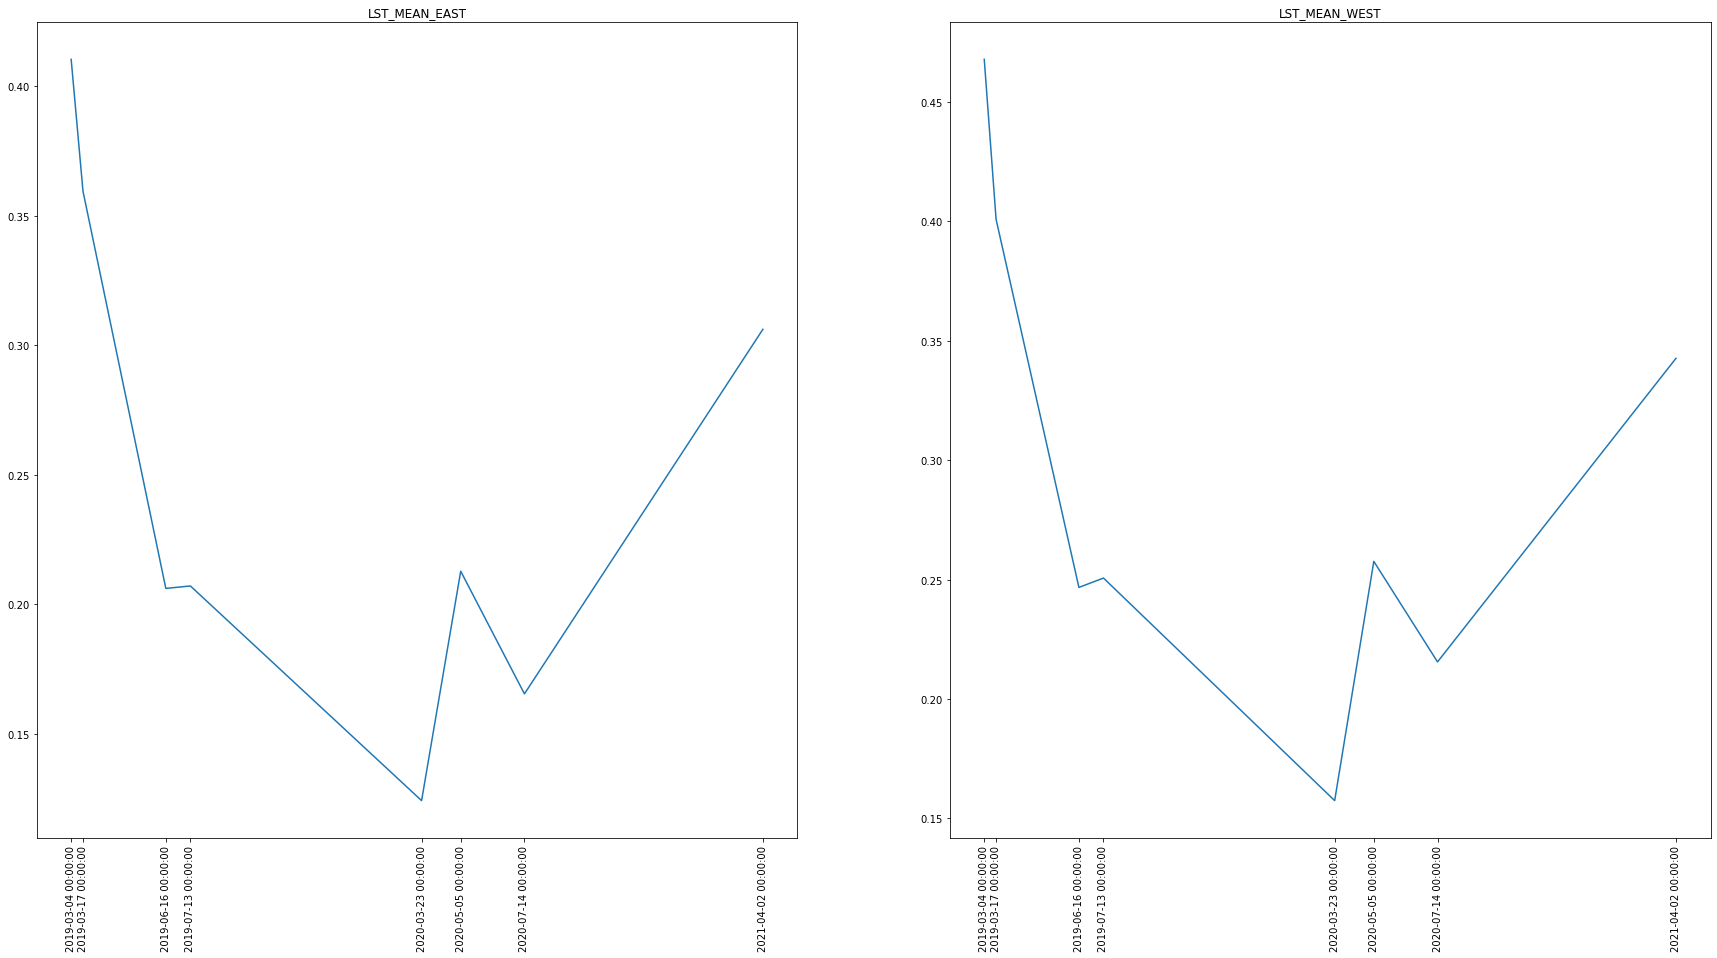

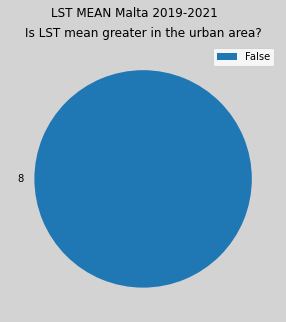

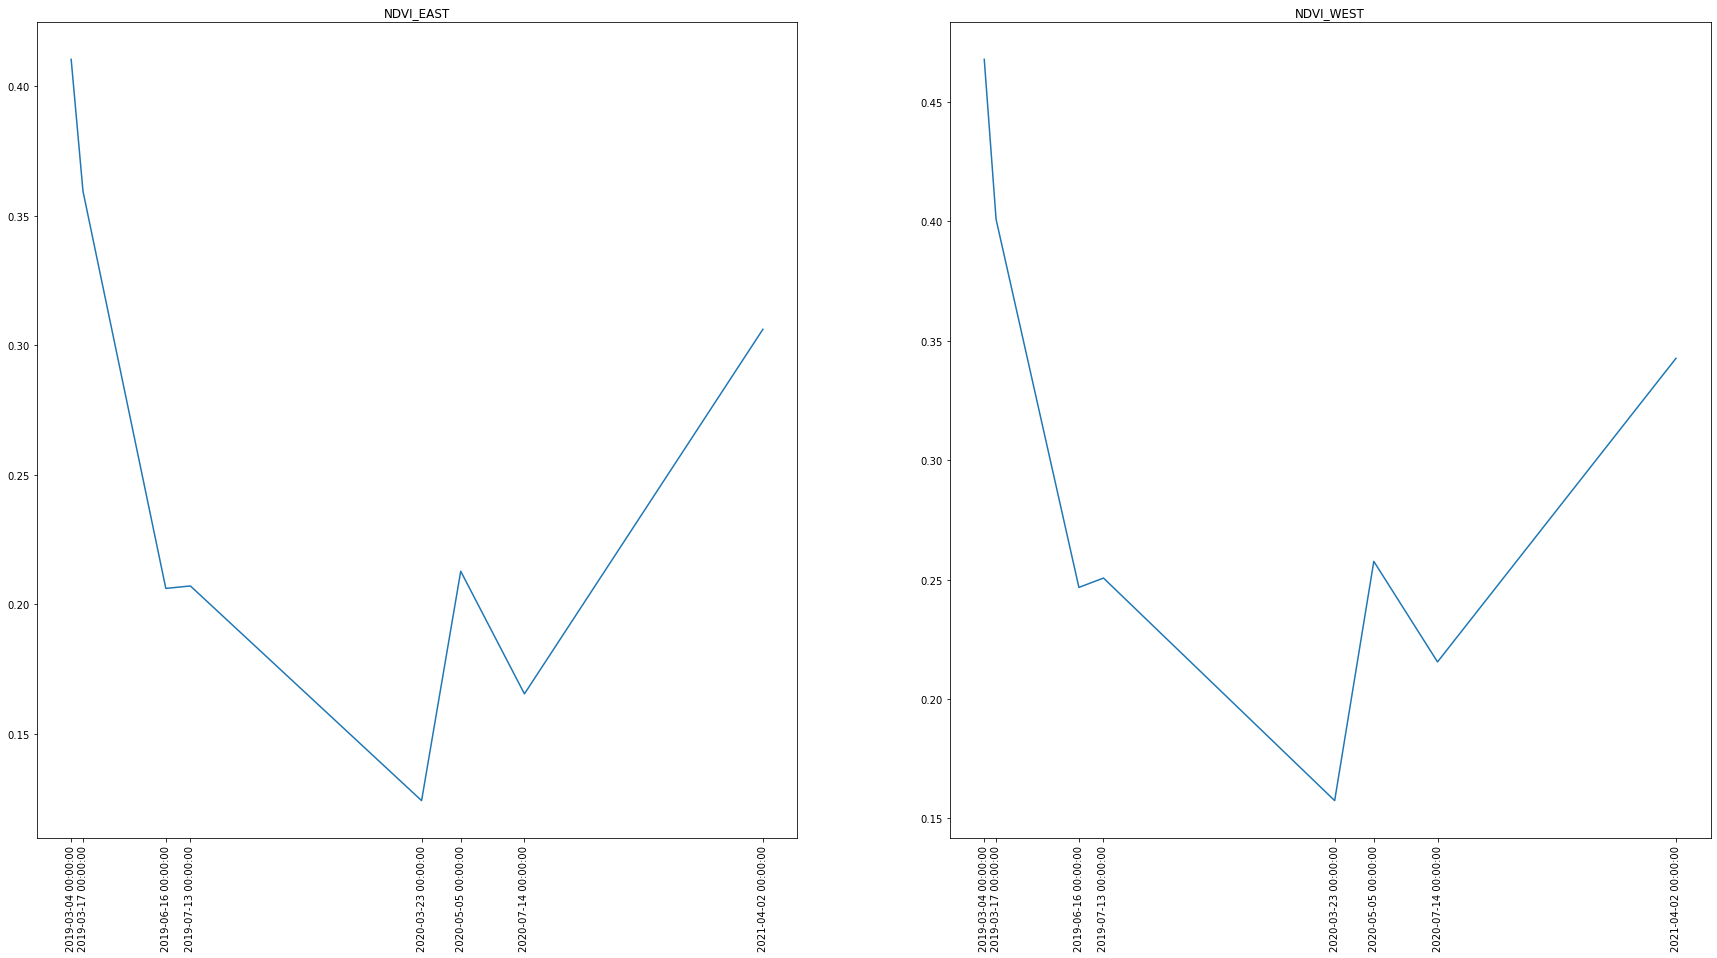

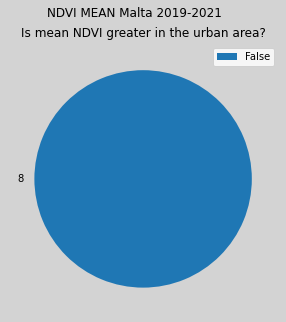

In [18]:
##Visualise Data with bars and pies
##Malta Urb vs Rur 
#LST
quota_count = malta_ss.LST_MEAN_Greater_In_Urban.value_counts()
quota_legend = quota_count.keys().to_list()
column_name1 = 'LST_MEAN_EAST'
column_name2 = 'LST_MEAN_WEST'
title = 'Is LST mean greater in the urban area?'
subtitle = 'LST MEAN Malta 2019-2021'
generatePlotQuota(malta_ss, column_name1, column_name2, quota_count, quota_legend, title, subtitle)

#NDVI
quota_count = malta_ss.NDVI_Greater_In_Urban.value_counts()
quota_legend = quota_count.keys().to_list()
column_name1 = 'NDVI_EAST'
column_name2 = 'NDVI_WEST'
title = 'Is mean NDVI greater in the urban area?'
subtitle = 'NDVI MEAN Malta 2019-2021'
generatePlotQuota(malta_ss, column_name1, column_name2, quota_count, quota_legend, title, subtitle)


In [19]:
##Descriptive
def show_distribution(var_data, value, title):

    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    #print ('Min {:.2f}\nMax {:.2f}\nMean {:.2f}\nMedian {:.2f}\nMode {:.2f}\n'.format(min_val, max_val, mean_val, med_val, mod_val))

    fig, ax = plt.subplots(2, 1, figsize=(10,4))

    ax[0].hist(var_data, bins=9)
    ax[0].set_ylabel('Frequency')
    ax[0].axvline(x=min_val, color='gray', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=max_val, color='gray', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=med_val, color='red', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=mod_val, color='yellow', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=mean_val, color='cyan', linestyle='dashed', linewidth=2)

    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel(value)

    fig.suptitle(title)
    plt.savefig('./PNG/BoxPlots/' + title + '_' + '.png')


c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and m

KeyError: 0

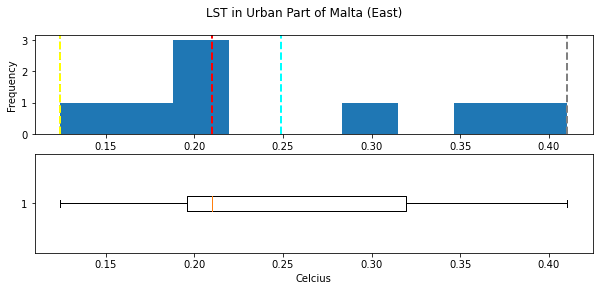

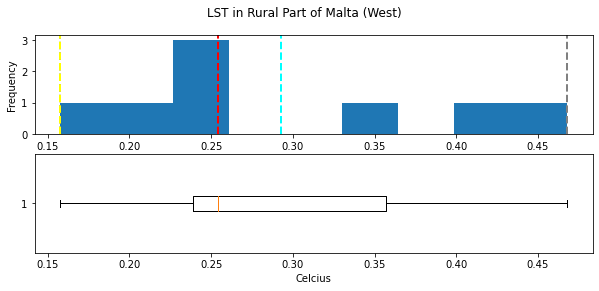

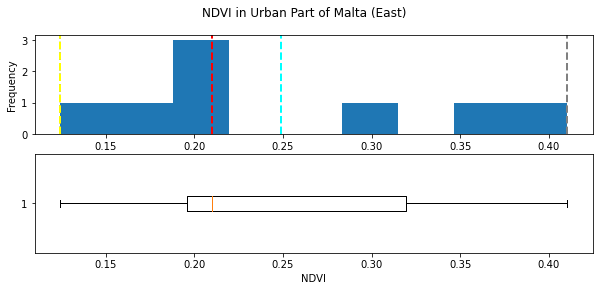

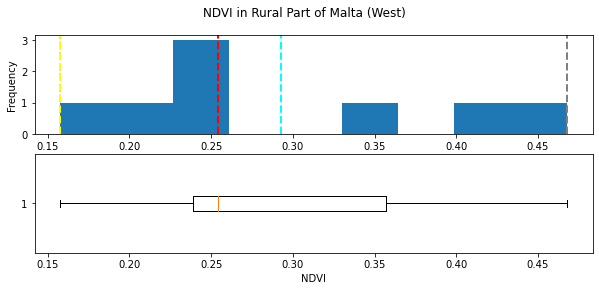

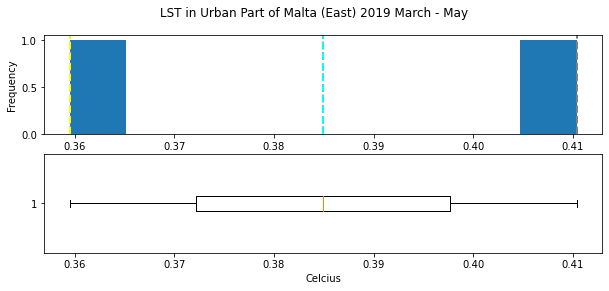

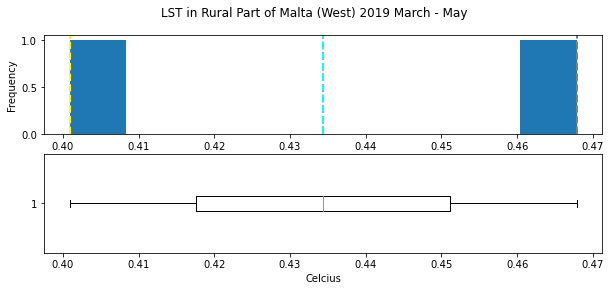

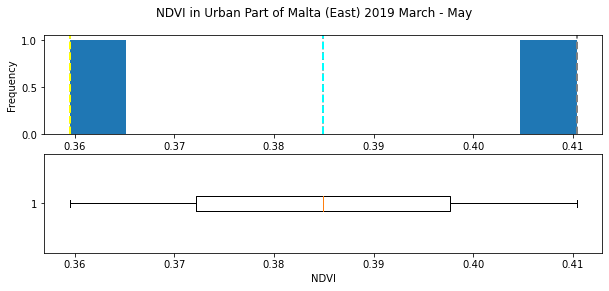

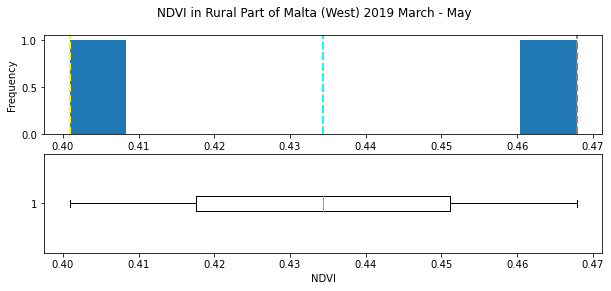

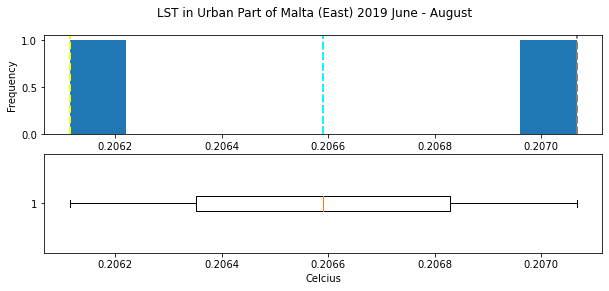

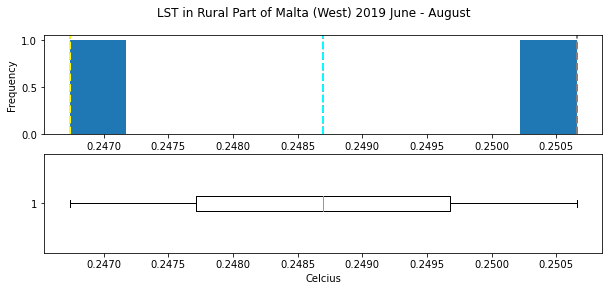

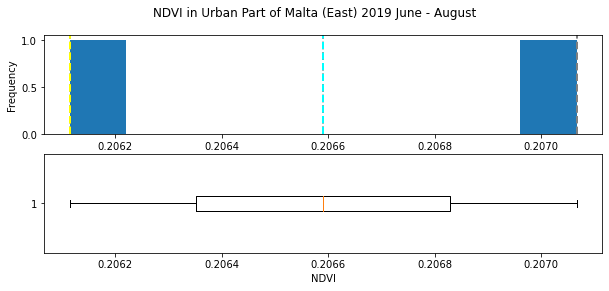

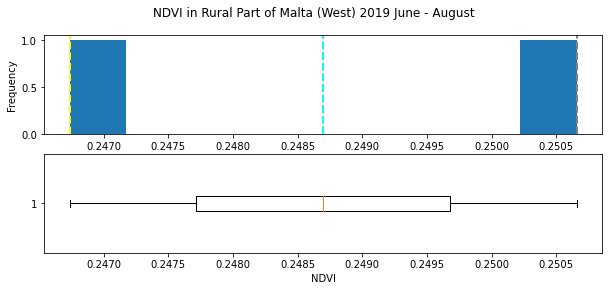

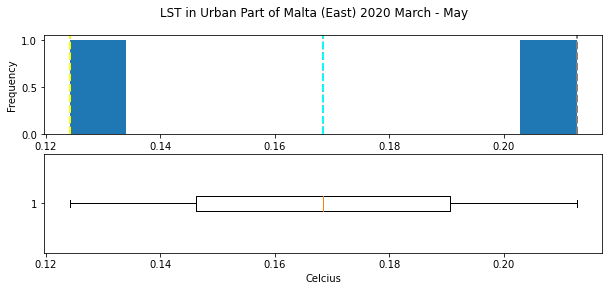

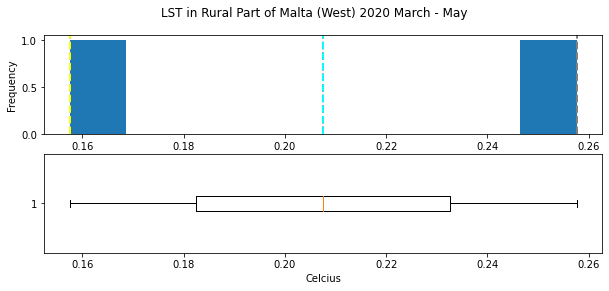

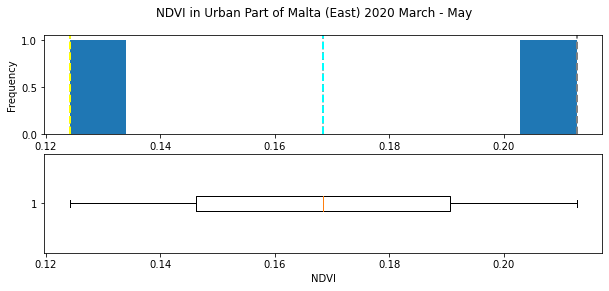

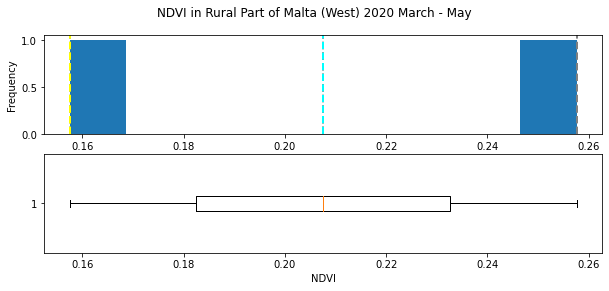

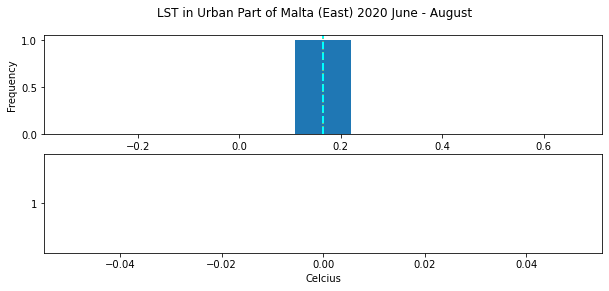

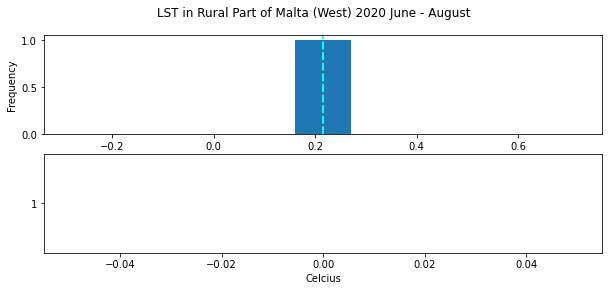

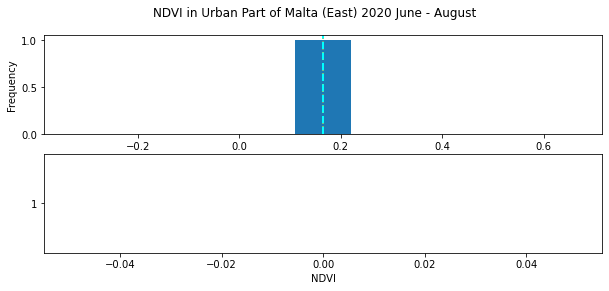

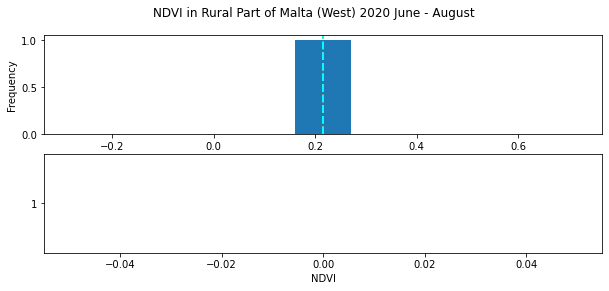

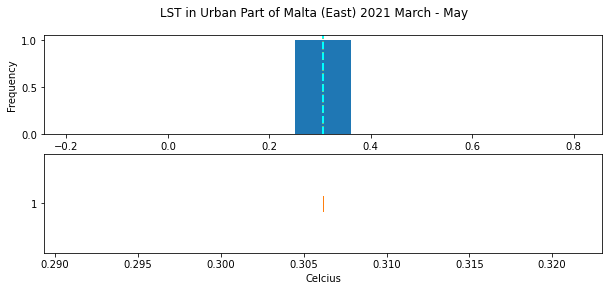

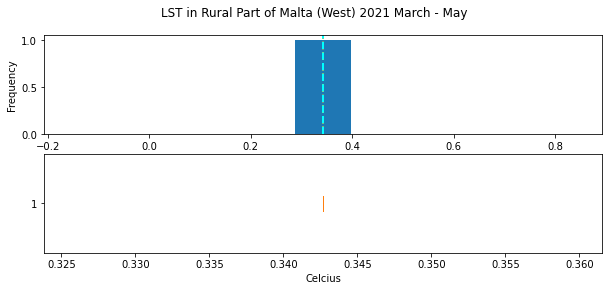

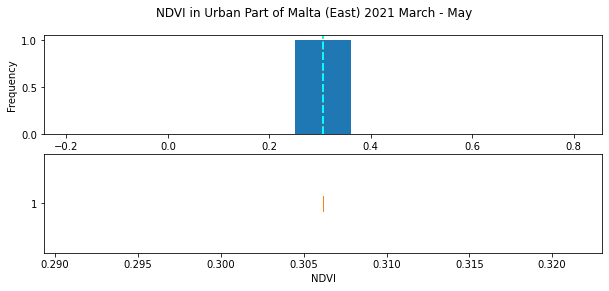

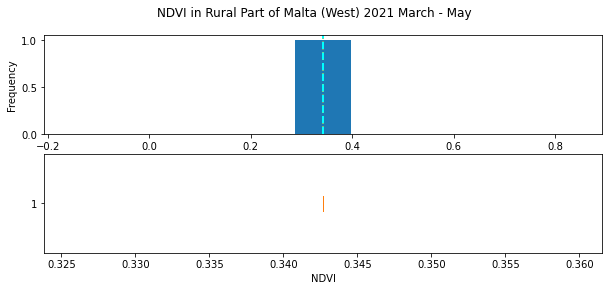

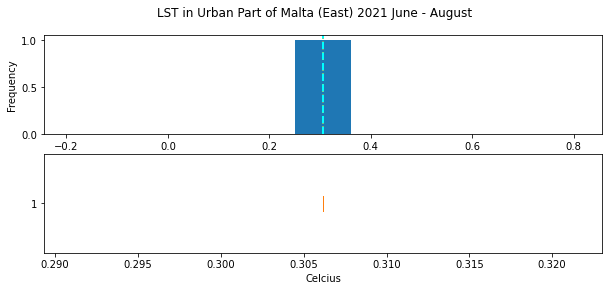

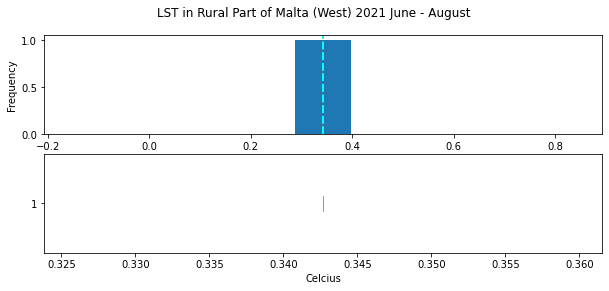

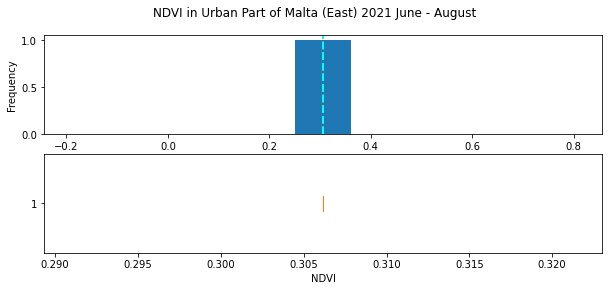

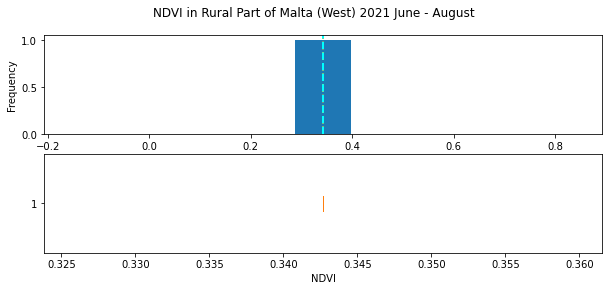

In [21]:
##Malta All periods
value = 'Celcius'
title1 = 'LST in Urban Part of Malta (East)'
title2 = 'LST in Rural Part of Malta (West)'
show_distribution(dataframe.LST_MEAN_EAST, value, title1)
show_distribution(dataframe.LST_MEAN_WEST, value, title2)
value = 'NDVI'
title1 = 'NDVI in Urban Part of Malta (East)'
title2 = 'NDVI in Rural Part of Malta (West)'
show_distribution(dataframe.NDVI_EAST, value, title1)
show_distribution(dataframe.NDVI_WEST, value, title2)

###2019
##Malta 2019 Covid
value = 'Celcius'
title1 = 'LST in Urban Part of Malta (East) 2019 March - May'
title2 = 'LST in Rural Part of Malta (West) 2019 March - May'
show_distribution(malta_2019Covid_ss.LST_MEAN_EAST, value, title1)
show_distribution(malta_2019Covid_ss.LST_MEAN_WEST, value, title2)
value = 'NDVI'
title1 = 'NDVI in Urban Part of Malta (East) 2019 March - May'
title2 = 'NDVI in Rural Part of Malta (West) 2019 March - May'
show_distribution(malta_2019Covid_ss.NDVI_EAST, value, title1)
show_distribution(malta_2019Covid_ss.NDVI_WEST, value, title2)

##Malta 2019 Summer
value = 'Celcius'
title1 = 'LST in Urban Part of Malta (East) 2019 June - August'
title2 = 'LST in Rural Part of Malta (West) 2019 June - August'
show_distribution(malta_2019Summer_ss.LST_MEAN_EAST, value, title1)
show_distribution(malta_2019Summer_ss.LST_MEAN_WEST, value, title2)
value = 'NDVI'
title1 = 'NDVI in Urban Part of Malta (East) 2019 June - August'
title2 = 'NDVI in Rural Part of Malta (West) 2019 June - August'
show_distribution(malta_2019Summer_ss.NDVI_EAST, value, title1)
show_distribution(malta_2019Summer_ss.NDVI_WEST, value, title2)

###2020
##Malta 2020 Covid
value = 'Celcius'
title1 = 'LST in Urban Part of Malta (East) 2020 March - May'
title2 = 'LST in Rural Part of Malta (West) 2020 March - May'
show_distribution(malta_2020Covid_ss.LST_MEAN_EAST, value, title1)
show_distribution(malta_2020Covid_ss.LST_MEAN_WEST, value, title2)
value = 'NDVI'
title1 = 'NDVI in Urban Part of Malta (East) 2020 March - May'
title2 = 'NDVI in Rural Part of Malta (West) 2020 March - May'
show_distribution(malta_2020Covid_ss.NDVI_EAST, value, title1)
show_distribution(malta_2020Covid_ss.NDVI_WEST, value, title2)

##Malta 2020 Summer
value = 'Celcius'
title1 = 'LST in Urban Part of Malta (East) 2020 June - August'
title2 = 'LST in Rural Part of Malta (West) 2020 June - August'
show_distribution(malta_2020Summer_ss.LST_MEAN_EAST, value, title1)
show_distribution(malta_2020Summer_ss.LST_MEAN_WEST, value, title2)
value = 'NDVI'
title1 = 'NDVI in Urban Part of Malta (East) 2020 June - August'
title2 = 'NDVI in Rural Part of Malta (West) 2020 June - August'
show_distribution(malta_2020Summer_ss.NDVI_EAST, value, title1)
show_distribution(malta_2020Summer_ss.NDVI_WEST, value, title2)

###2021
##Malta 2021 Covid
value = 'Celcius'
title1 = 'LST in Urban Part of Malta (East) 2021 March - May'
title2 = 'LST in Rural Part of Malta (West) 2021 March - May'
show_distribution(malta_2021Covid_ss.LST_MEAN_EAST, value, title1)
show_distribution(malta_2021Covid_ss.LST_MEAN_WEST, value, title2)
value = 'NDVI'
title1 = 'NDVI in Urban Part of Malta (East) 2021 March - May'
title2 = 'NDVI in Rural Part of Malta (West) 2021 March - May'
show_distribution(malta_2021Covid_ss.NDVI_EAST, value, title1)
show_distribution(malta_2021Covid_ss.NDVI_WEST, value, title2)

##Malta 2021 Summer
value = 'Celcius'
title1 = 'LST in Urban Part of Malta (East) 2021 June - August'
title2 = 'LST in Rural Part of Malta (West) 2021 June - August'
show_distribution(malta_2021Summer_ss.LST_MEAN_EAST, value, title1)
show_distribution(malta_2021Summer_ss.LST_MEAN_WEST, value, title2)
value = 'NDVI'
title1 = 'NDVI in Urban Part of Malta (East) 2021 June - August'
title2 = 'NDVI in Rural Part of Malta (West) 2021 June - August'
show_distribution(malta_2021Summer_ss.NDVI_EAST, value, title1)
show_distribution(malta_2021Summer_ss.NDVI_WEST, value, title2)

###2022
##Malta 2022 Covid
value = 'Celcius'
title1 = 'LST in Urban Part of Malta (East) 2022 March - May'
title2 = 'LST in Rural Part of Malta (West) 2022 March - May'
show_distribution(malta_2022Covid_ss.LST_MEAN_EAST, value, title1)
show_distribution(malta_2022Covid_ss.LST_MEAN_WEST, value, title2)
value = 'NDVI'
title1 = 'NDVI in Urban Part of Malta (East) 2022 March - May'
title2 = 'NDVI in Rural Part of Malta (West) 2022 March - May'
show_distribution(malta_2022Covid_ss.NDVI_EAST, value, title1)
show_distribution(malta_2022Covid_ss.NDVI_WEST, value, title2)

In [28]:
#print(np.corrcoef(dataframe.LST_MEAN_EAST, dataframe.NDVI_EAST)[0,1])
#print(dataframe['LST_MEAN_EAST'].corr(dataframe['NDVI_EAST']))

data = [['2019-2021 March - August', dataframe['LST_MEAN'].min(), dataframe['LST_MEAN'].max(), 
    dataframe['LST_MEAN'].mean(), dataframe['LST_MEAN'].median(),dataframe['NDVI_MEAN'].min(), 
    dataframe['NDVI_MEAN'].max(), dataframe['NDVI_MEAN'].mean(), dataframe['NDVI_MEAN'].median(), 
    dataframe['LST_MEAN_EAST'].corr(dataframe['NDVI_EAST'])],

    ['2019 March - May', malta_2019Covid_ss['LST_MEAN'].min(), malta_2019Covid_ss['LST_MEAN'].max(), 
    malta_2019Covid_ss['LST_MEAN'].mean(), malta_2019Covid_ss['LST_MEAN'].median(),malta_2019Covid_ss['NDVI_MEAN'].min(), 
    malta_2019Covid_ss['NDVI_MEAN'].max(), malta_2019Covid_ss['NDVI_MEAN'].mean(), malta_2019Covid_ss['NDVI_MEAN'].median(), 
    malta_2019Covid_ss['LST_MEAN_EAST'].corr(malta_2019Covid_ss['NDVI_EAST'])],
    ['2019 June - August', malta_2019Summer_ss['LST_MEAN'].min(), malta_2019Summer_ss['LST_MEAN'].max(), 
    malta_2019Summer_ss['LST_MEAN'].mean(), malta_2019Summer_ss['LST_MEAN'].median(),malta_2019Summer_ss['NDVI_MEAN'].min(), 
    malta_2019Summer_ss['NDVI_MEAN'].max(), malta_2019Summer_ss['NDVI_MEAN'].mean(), malta_2019Summer_ss['NDVI_MEAN'].median(), 
    malta_2019Summer_ss['LST_MEAN_EAST'].corr(malta_2019Summer_ss['NDVI_EAST'])],

    ['2020 March - May', malta_2020Covid_ss['LST_MEAN'].min(), malta_2020Covid_ss['LST_MEAN'].max(), 
    malta_2020Covid_ss['LST_MEAN'].mean(), malta_2020Covid_ss['LST_MEAN'].median(),malta_2020Covid_ss['NDVI_MEAN'].min(), 
    malta_2020Covid_ss['NDVI_MEAN'].max(), malta_2020Covid_ss['NDVI_MEAN'].mean(), malta_2020Covid_ss['NDVI_MEAN'].median(), 
    malta_2020Covid_ss['LST_MEAN_EAST'].corr(malta_2020Covid_ss['NDVI_EAST'])],
    ['2020 June - August', malta_2020Summer_ss['LST_MEAN'].min(), malta_2020Summer_ss['LST_MEAN'].max(), 
    malta_2020Summer_ss['LST_MEAN'].mean(), malta_2020Summer_ss['LST_MEAN'].median(),malta_2020Summer_ss['NDVI_MEAN'].min(), 
    malta_2020Summer_ss['NDVI_MEAN'].max(), malta_2020Summer_ss['NDVI_MEAN'].mean(), malta_2020Summer_ss['NDVI_MEAN'].median(), 
    malta_2020Summer_ss['LST_MEAN_EAST'].corr(malta_2020Summer_ss['NDVI_EAST'])],

    ['2021 March - May', malta_2021Covid_ss['LST_MEAN'].min(), malta_2021Covid_ss['LST_MEAN'].max(), 
    malta_2021Covid_ss['LST_MEAN'].mean(), malta_2021Covid_ss['LST_MEAN'].median(),malta_2021Covid_ss['NDVI_MEAN'].min(), 
    malta_2021Covid_ss['NDVI_MEAN'].max(), malta_2021Covid_ss['NDVI_MEAN'].mean(), malta_2021Covid_ss['NDVI_MEAN'].median(), 
    malta_2021Covid_ss['LST_MEAN_EAST'].corr(malta_2021Covid_ss['NDVI_EAST'])],
    ['2021 June - August', malta_2021Summer_ss['LST_MEAN'].min(), malta_2021Summer_ss['LST_MEAN'].max(), 
    malta_2021Summer_ss['LST_MEAN'].mean(), malta_2021Summer_ss['LST_MEAN'].median(),malta_2021Summer_ss['NDVI_MEAN'].min(), 
    malta_2021Summer_ss['NDVI_MEAN'].max(), malta_2021Summer_ss['NDVI_MEAN'].mean(), malta_2021Summer_ss['NDVI_MEAN'].median(), 
    malta_2021Summer_ss['LST_MEAN_EAST'].corr(malta_2021Summer_ss['NDVI_EAST'])],

    ['2022 March - May', malta_2022Covid_ss['LST_MEAN'].min(), malta_2022Covid_ss['LST_MEAN'].max(), 
    malta_2022Covid_ss['LST_MEAN'].mean(), malta_2022Covid_ss['LST_MEAN'].median(),malta_2022Covid_ss['NDVI_MEAN'].min(), 
    malta_2022Covid_ss['NDVI_MEAN'].max(), malta_2022Covid_ss['NDVI_MEAN'].mean(), malta_2022Covid_ss['NDVI_MEAN'].median(), 
    malta_2022Covid_ss['LST_MEAN_EAST'].corr(malta_2022Covid_ss['NDVI_EAST'])]
    ]

resultDf = pd.DataFrame(data, columns = ['Period', 'LST_MIN', 'LST_MAX', 'LST_MEAN', 'LST_MEDIAN', 'NDVI_MIN', 'NDVI_MAX', 'NDVI_MEAN', 'NDVI_MEDIAN', 'NDVI_LST_CORR'])

resultDf.head()

c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\Users\Massimo\anaconda3\envs\snap\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Period,LST_MIN,LST_MAX,LST_MEAN,LST_MEDIAN,NDVI_MIN,NDVI_MAX,NDVI_MEAN,NDVI_MEDIAN,NDVI_LST_CORR
0,2019-2021 March - August,-272.866909,-272.567477,-272.733898,-272.770828,0.133091,0.432523,0.266102,0.229172,1.0
1,2019 March - May,-272.628923,-272.567477,-272.598200,-272.598200,0.371077,0.432523,0.401800,0.401800,1.0
2,2019 June - August,-272.775248,-272.772467,-272.773857,-272.773857,0.224752,0.227533,0.226143,0.226143,1.0
3,2020 March - May,-272.866909,-272.769189,-272.818049,-272.818049,0.133091,0.230811,0.181951,0.181951,1.0
4,2020 June - August,-272.814877,-272.814877,-272.814877,-272.814877,0.185123,0.185123,0.185123,0.185123,NaN


In [29]:
##Save to Csv
resultDf.to_csv('./CSV/SummaryCSV.csv')